# Gradient Boosting for Cambridge UK Weather Forecasting

Gradient boosting models for time series analysis of Cambridge UK temperature measurements taken at the [University computer lab weather station](https://www.cl.cam.ac.uk/research/dtg/weather/).

This notebook is being developed on [Google Colab](https://colab.research.google.com), primarily using [LightGBM](https://lightgbm.readthedocs.io/), [CatBoost](https://catboost.ai/) and the [Darts](https://unit8co.github.io/darts/) time series package.  Initially I was most interested in short term temperature forecasts (less than 2 hours) but now mostly produce results up to 24 hours in the future for comparison with earlier [baselines](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/cammet_baselines_2021.ipynb).

See my previous notebooks, web apps etc:
 * [Cambridge UK temperature forecast python notebooks](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks)
 * [Cambridge UK temperature forecast R models](https://github.com/makeyourownmaker/CambridgeTemperatureModel)
 * [Bayesian optimisation of prophet temperature model](https://github.com/makeyourownmaker/BayesianProphet)
 * [Cambridge University Computer Laboratory weather station R shiny web app](https://github.com/makeyourownmaker/ComLabWeatherShiny)

The linked notebooks, web apps etc contain further details including:
 * data description
 * data cleaning and preparation
 * data exploration

In particular, see the notebooks:
 * [cammet_baselines_2021](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/cammet_baselines_2021.ipynb) including persistent, simple exponential smoothing, Holt Winter's exponential smoothing and vector autoregression
 * [keras_mlp_fcn_resnet_time_series](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/keras_mlp_fcn_resnet_time_series.ipynb), which uses a streamlined version of data preparation from [Tensorflow time series forecasting tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series)
 * [lstm_time_series](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/lstm_time_series.ipynb) with stacked LSTMs, bidirectional LSTMs and ConvLSTM1D networks
 * [cnn_time_series](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/cnn_time_series.ipynb) with Conv1D, multi-head Conv1D, Conv2D and Inception-style models
 * [encoder_decoder](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/encoder_decoder.ipynb) which includes autoencoder with attention, encoder decoder with teacher forcing, transformer with teacher forcing and padding, encoder only with MultiHeadAttention
 * [tsfresh_feature_engineering](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/tsfresh_feature_engineering.ipynb) automated feature engineering and selection for time series analysis of Cambridge UK weather measurements

Most of the above repositories, notebooks, web apps etc were built on both less data and less thoroughly cleaned data.

---

Install [darts](https://unit8co.github.io/darts/) because it is currently not available on google colab.

**WARNING**: You must restart the google colab runtime after this install.

In [1]:
#!pip install darts
# ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
# tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.10.1 which is incompatible.

#!pip install "u8darts[torch]"
# ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
# tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.10.1 which is incompatible.

!pip install "u8darts[pmdarima]"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 592.2/592.2 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 KB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.7/147.7 KB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 KB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   

Load most of the other required packages.

In [2]:
import sys
import math
import datetime
import itertools
import subprocess
import pkg_resources

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm
from scipy import stats, special
from prophet import Prophet
from itertools import product
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, SplineTransformer


# Reduces variance in results but won't eliminate it :-(
%env PYTHONHASHSEED=0
import random
random.seed(42)
np.random.seed(42)

%matplotlib inline

env: PYTHONHASHSEED=0



### Environment variables

Set some environment variables.

 * `TSFRESH` - include tsfresh features or not



In [3]:
TSFRESH = False
HORIZON = 48
Y_COL   = 'y_des'  # 'y_res' 'y'

DAY  = 24 * 60 * 60
YEAR = 365.2425 * DAY

DAILY_OBS  = 48
YEARLY_OBS = int(365.2425 * DAILY_OBS)  # annual observations
DAY_SECS_STEP = int(DAY / DAILY_OBS)



## Import ComLab Data

The measurements are relatively noisy and there are usually several hundred missing values every year; often across multiple variables.
Observations have been extensively cleaned but may still have issues.  Interpolation and missing value imputation have been used to fill all missing values.  See the [cleaning section](https://github.com/makeyourownmaker/CambridgeTemperatureModel#Cleaning) in the [Cambridge Temperature Model repository](https://github.com/makeyourownmaker/CambridgeTemperatureModel) for details.  Observations start in August 2008 and end in September 2022 and occur every 30 mins.

**TODO** This code has grown to the point where moving more of it into functions makes sense.

Shape:


(239887, 60)


Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 239887 entries, 2008-08-01 08:30:00 to 2022-09-19 00:00:00
Data columns (total 60 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   ds                        239743 non-null  datetime64[ns]
 1   y                         239743 non-null  float64       
 2   y_daily                   239743 non-null  float64       
 3   y_yearly                  239743 non-null  float64       
 4   y_res                     239743 non-null  float64       
 5   humidity                  239743 non-null  float64       
 6   humidity_daily            239743 non-null  float64       
 7   humidity_yearly           239743 non-null  float64       
 8   humidity_res              239743 non-null  float64       
 9   dew.point                 239743 non-null  float64       
 10  dew.point_daily           239743 non-null  float64       
 11  dew.point_yearly        

None


Summary stats:


y        y_daily       y_yearly          y_res  \
count  239743.000000  239743.000000  239743.000000  239743.000000   
mean       10.117427       0.019373      10.166712      -0.068657   
std         6.521537       2.179876       4.982561       3.474144   
min        -7.000000      -2.895738       1.401510     -14.611490   
25%         5.200000      -2.061429       5.442148      -2.412199   
50%         9.600000      -0.304739       9.799405      -0.196803   
75%        14.500000       2.297913      14.946819       2.174616   
max        37.800000       3.270954      19.589207      14.939839   

            humidity  humidity_daily  humidity_yearly   humidity_res  \
count  239743.000000   239743.000000    239743.000000  239743.000000   
mean       78.163125       -0.083195        78.055728       0.190593   
std        17.537268        9.452725         7.133912      12.730444   
min        20.000000      -14.386642        63.824978     -54.293192   
25%        68.000000       -9.869046        71.796842      -8.137356   
50%        82.000000        1.396999        77.186508       0.438554   
75%        92.000000        8.859896        84.880272       8.629885   
max       100.000000       12.272356        93.500000      46.504943   

           dew.point  dew.point_daily  ...    isd_outlier       long_run  \
count  239743.000000    239743.000000  ...  239743.000000  239743.000000   
mean        5.979012         0.000264  ...       0.013314       0.010211   
std         5.165345         0.142661  ...       0.114617       0.100532   
min       -10.000000        -0.249417  ...       0.000000       0.000000   
25%         2.200000        -0.113167  ...       0.000000       0.000000   
50%         6.100000         0.013928  ...       0.000000       0.000000   
75%         9.800000         0.118302  ...       0.000000       0.000000   
max        20.900000         0.240955  ...       1.000000       1.000000   

               spike     cooksd_out    isd_3_sigma     isd_filled  \
count  239743.000000  239743.000000  239743.000000  239743.000000   
mean        0.001272       0.000229       0.000634       0.011546   
std         0.035645       0.015145       0.025172       0.106829   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

       hist_average  mi_filled  mi_spike_interp     lin_interp  
count      239743.0   239743.0    239743.000000  239743.000000  
mean            0.0        0.0         0.000029       0.000029  
std             0.0        0.0         0.005403       0.005403  
min             0.0        0.0         0.000000       0.000000  
25%             0.0        0.0         0.000000       0.000000  
50%             0.0        0.0         0.000000       0.000000  
75%             0.0        0.0         0.000000       0.000000  
max             0.0        0.0         1.000000       1.000000  

[8 rows x 59 columns]


Raw data:


ds     y   y_daily   y_yearly     y_res  \
ds                                                                             
2008-08-01 08:30:00 2008-08-01 08:30:00  18.6 -0.327321  18.273750  0.653571   
2008-08-01 09:00:00 2008-08-01 09:00:00  19.1  0.222570  18.273750  0.603680   
2008-08-01 09:30:00 2008-08-01 09:30:00  19.5  0.764780  18.273750  0.461470   
2008-08-01 10:00:00 2008-08-01 10:00:00  20.0  1.241978  18.273750  0.484272   
2008-08-01 10:30:00 2008-08-01 10:30:00  21.3  1.699089  18.273750  1.327161   
...                                 ...   ...       ...        ...       ...   
2022-09-18 22:00:00 2022-09-18 22:00:00   9.2 -1.131317  13.501054 -3.169737   
2022-09-18 22:30:00 2022-09-18 22:30:00   9.2 -1.354145  13.501054 -2.946908   
2022-09-18 23:00:00 2022-09-18 23:00:00   9.2 -1.559035  13.501054 -2.742019   
2022-09-18 23:30:00 2022-09-18 23:30:00   9.2 -1.740994  13.501054 -2.560060   
2022-09-19 00:00:00 2022-09-19 00:00:00   9.2 -1.908509  13.926279 -2.817770   

                     humidity  humidity_daily  humidity_yearly  humidity_res  \
ds                                                                             
2008-08-01 08:30:00      69.0        1.962292        69.357323     -2.319616   
2008-08-01 09:00:00      70.0       -0.477817        69.357323      1.120494   
2008-08-01 09:30:00      68.0       -2.898169        69.357323      1.540846   
2008-08-01 10:00:00      68.0       -5.220096        69.357323      3.862772   
2008-08-01 10:30:00      61.0       -7.348509        69.357323     -1.008815   
...                       ...             ...              ...           ...   
2022-09-18 22:00:00      82.0        4.879728        75.230585      1.889687   
2022-09-18 22:30:00      81.0        5.858070        75.230585     -0.088656   
2022-09-18 23:00:00      81.0        6.717624        75.230585     -0.948209   
2022-09-18 23:30:00      75.0        7.537405        75.230585     -7.767990   
2022-09-19 00:00:00      86.0        8.190356        77.341435      0.468209   

                     dew.point  ...  isd_outlier  long_run  spike  cooksd_out  \
ds                              ...                                             
2008-08-01 08:30:00       12.8  ...          0.0       0.0    0.0         0.0   
2008-08-01 09:00:00       13.5  ...          0.0       0.0    0.0         0.0   
2008-08-01 09:30:00       13.4  ...          0.0       0.0    0.0         0.0   
2008-08-01 10:00:00       13.9  ...          0.0       0.0    0.0         0.0   
2008-08-01 10:30:00       13.5  ...          0.0       0.0    0.0         0.0   
...                        ...  ...          ...       ...    ...         ...   
2022-09-18 22:00:00        6.3  ...          0.0       0.0    0.0         0.0   
2022-09-18 22:30:00        6.1  ...          0.0       0.0    0.0         0.0   
2022-09-18 23:00:00        6.1  ...          0.0       0.0    0.0         0.0   
2022-09-18 23:30:00        5.0  ...          0.0       0.0    0.0         0.0   
2022-09-19 00:00:00        7.0  ...          0.0       0.0    0.0         0.0   

                     isd_3_sigma  isd_filled  hist_average  mi_filled  \
ds                                                                      
2008-08-01 08:30:00          0.0         0.0           0.0        0.0   
2008-08-01 09:00:00          0.0         0.0           0.0        0.0   
2008-08-01 09:30:00          0.0         0.0           0.0        0.0   
2008-08-01 10:00:00          0.0         0.0           0.0        0.0   
2008-08-01 10:30:00          0.0         0.0           0.0        0.0   
...                          ...         ...           ...        ...   
2022-09-18 22:00:00          0.0         0.0           0.0        0.0   
2022-09-18 22:30:00          0.0         0.0           0.0        0.0   
2022-09-18 23:00:00          0.0         0.0           0.0        0.0   
2022-09-18 23:30:00          0.0         0.0           0.0        0.0   
2022-09-19 00:00:00      

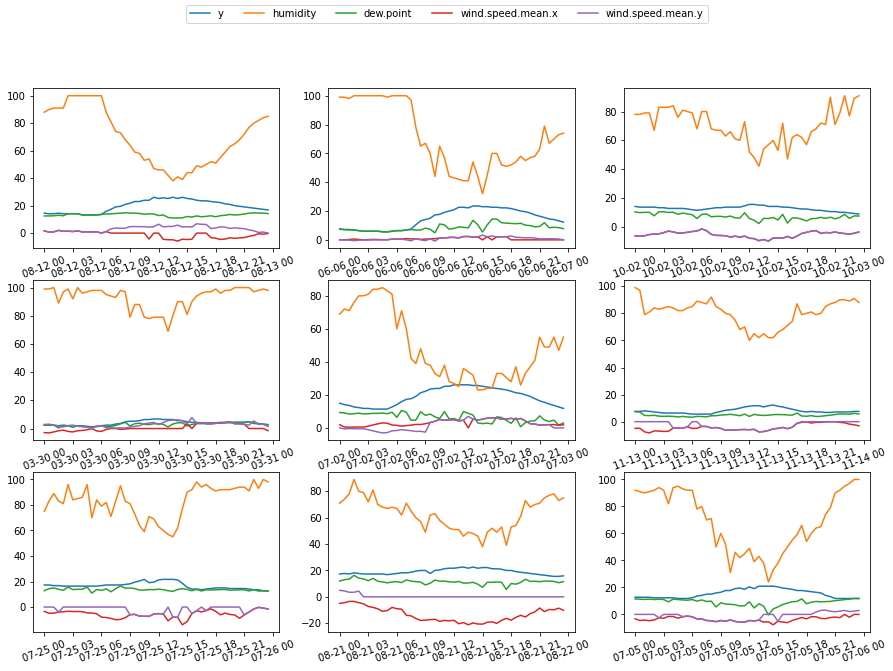

In [4]:
if 'google.colab' in str(get_ipython()):
    data_url = "https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/data/CamMetCleanishMissAnnotated2022.09.20.csv?raw=true"
else:
    data_url = "../data/CamMetCleanishMissAnnotated2022.09.20.csv"

df = pd.read_csv(data_url, parse_dates=['ds'])
df.set_index('ds', drop=False, inplace=True)
df = df[~df.index.duplicated(keep='first')]
df = df.asfreq(freq='30min')
df_orig = df


# Data reformating - https://www.cl.cam.ac.uk/research/dtg/weather/weather-raw-format.txt
for column in ['temperature', 'dew.point', 'wind.speed.mean']:
    df[column] /= 10

df['y'] = df['temperature']
    
# Deep copy avoids SettingWithCopyWarning
df = df.loc['2008-08-01 00:00:00':'2022-09-19 00:00:00', :].copy(deep=True)


# Convert wind direction and speed to x and y vectors, so the model can more easily interpret them
#wv = df['wind.speed.mean']
#wd_rad = df['wind.bearing.mean'] * np.pi / 180  # Convert to radians
#
# Calculate the wind x and y components
#df['wind.x'] = wv * np.cos(wd_rad)
#df['wind.y'] = wv * np.sin(wd_rad)


def convert_wind_to_xy(data, speed, bearing, var = ''):
  # Convert wind direction and speed to x and y vectors, so the model can more easily interpret them
  wd_rad = data[bearing] * np.pi / 180  # Convert to radians
  wv = data[speed + var]

  # Calculate the wind x and y components
  data[speed + var + '.x'] = wv * np.cos(wd_rad)
  data[speed + var + '.y'] = wv * np.sin(wd_rad)

  return data


df['pressure.log'] = np.log(df['pressure'])
df['wind.speed.mean.sqrt'] = np.sqrt(df['wind.speed.mean'])
df = convert_wind_to_xy(df, 'wind.speed.mean', 'wind.bearing.mean')
df = convert_wind_to_xy(df, 'wind.speed.mean.sqrt', 'wind.bearing.mean')


# From https://carnotcycle.wordpress.com/2012/08/04/how-to-convert-relative-humidity-to-absolute-humidity/
# Neither ah (absolute humidity) nor rh (relative humidity) proved useful for 
# forecasting but they may have utility for imputation
# See also: https://carnotcycle.wordpress.com/2017/08/01/compute-dewpoint-temperature-from-rh-t/
#           https://carnotcycle.wordpress.com/tag/formula/
# df['rh'] = 100 * (np.exp((18.678 * df['dew.point']) / (257.14 + df['dew.point'])) / np.exp((18.678 * df['y']) / (257.14 + df['y'])))
# df.loc[df['rh'] > 100.0, 'rh'] = 100.0
# df.loc[df['rh'] <  20.0, 'rh'] =  20.0
df['ah'] = 13.24715 * df['humidity'] * (np.exp((17.67 * df['y']) / (243.5 + df['y']))) / (273.15 + df['y'])
df['mixing_ratio'] = 6.112 * 6.2218 * df['humidity'] * np.exp(17.67 * df['y'] / (df['y'] + 243.5)) / \
                     (df['pressure'] - 0.06112 * df['humidity'] * np.exp(17.67 * df['y'] / (df['y'] + 243.5)))


# Convert to secs and add daily and yearly sinusoidal time terms
date_time   = pd.to_datetime(df['ds'], format = '%Y.%m.%d %H:%M:%S')
timestamp_s = date_time.map(datetime.datetime.timestamp)


def sinusoidal_arg(timestamp_s, denominator):
    return 2 * np.pi * timestamp_s / denominator


# df['day.sin']  = np.sin(sinusoidal_arg(timestamp_s, day))
# df['day.cos']  = np.cos(sinusoidal_arg(timestamp_s, day))
# df['year.sin'] = np.sin(timestamp_s * (2 * np.pi / year))
# df['year.cos'] = np.cos(timestamp_s * (2 * np.pi / year))

#for i in [1, 2, 3]:
#    df['day.sin.'  + str(i)] = np.sin(sinusoidal_arg(timestamp_s, i * day))
#    df['day.cos.'  + str(i)] = np.cos(sinusoidal_arg(timestamp_s, i * day))
#    df['year.sin.' + str(i)] = np.sin(sinusoidal_arg(timestamp_s, i * year))
#    df['year.cos.' + str(i)] = np.cos(sinusoidal_arg(timestamp_s, i * year))

# ps - phase shift
for i, ps in enumerate([0, np.pi], start=1):
    df['day.sin.'  + str(i)] = np.sin(sinusoidal_arg(timestamp_s, DAY)  + ps)
    df['day.cos.'  + str(i)] = np.cos(sinusoidal_arg(timestamp_s, DAY)  + ps)
    df['year.sin.' + str(i)] = np.sin(sinusoidal_arg(timestamp_s, YEAR) + ps)
    df['year.cos.' + str(i)] = np.cos(sinusoidal_arg(timestamp_s, YEAR) + ps)


# Add daily spline-based time terms
def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree  = degree,
        n_knots = n_knots,
        knots   = np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation = "periodic",
        include_bias  = True,
    )


hour_df = pd.DataFrame(
    np.linspace(0, DAY, DAILY_OBS + 1).reshape(-1, 1),
    columns=["secs"],
)

month_df = pd.DataFrame(
    np.linspace(0, YEAR, YEARLY_OBS + 1).reshape(-1, 1),
    columns=["secs"],
)

# 12 splines approximating 12 month-like time components
day_splines = periodic_spline_transformer(DAY, n_splines=12).fit_transform(hour_df)
day_splines_df = pd.DataFrame(
    day_splines,
    columns=[f"day_spline_{i}" for i in range(day_splines.shape[1])],
)
day_splines_df['secs_since_midnight'] = range(0, DAY + DAY_SECS_STEP, DAY_SECS_STEP)

# pd.concat([hour_df, day_splines_df], axis="columns").plot(x="secs", cmap=plt.cm.tab20b)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

year_splines = periodic_spline_transformer(YEAR, n_splines=12).fit_transform(month_df)
year_splines_df = pd.DataFrame(
    year_splines,
    columns=[f"year_spline_{i}" for i in range(year_splines.shape[1])],
)
year_splines_df['secs_elapsed'] = range(0, int(YEAR), DAY_SECS_STEP)



# Add seasonal mean temperature (y_seasonal), humidity and dew.point
df['secs_since_midnight'] = ((df['ds'] - df['ds'].dt.normalize()) / pd.Timedelta('1 second')).astype(int)
df['doy'] = df['ds'].apply(lambda x: x.dayofyear - 1)
df['secs_elapsed'] = df['secs_since_midnight'] + df['doy'] * DAY

# NOTE: Potential data leak here 
#       Seasonality should be calculated on train data only
for var in ['y', 'humidity', 'dew.point', 'pressure', 'wind.speed.mean']:
  df_seasonal_var = df[[var, 'secs_elapsed']].groupby('secs_elapsed').mean(var)
  df_seasonal_var.rename(columns={var: var + '_seasonal'}, inplace=True)
  df = pd.merge(df, df_seasonal_var,   on='secs_elapsed')
  df[var + '_des'] = df[var] - df[var + '_seasonal']  # des - deseasonal

df = pd.merge(df, day_splines_df,  on='secs_since_midnight')
df = pd.merge(df, year_splines_df, on='secs_elapsed')


def simple_daily_yearly_res_decomp(data, var):
# NOTE: Potential data leak here 
#       Seasonality should be calculated on train data only

  df_des = data[[var, 'ds', 'secs_since_midnight', 'doy', 'secs_elapsed']].dropna()
  df_des.set_index('ds', drop=False, inplace=True)
  data.set_index('ds', drop=False, inplace=True)

  #df_des['secs_since_midnight'] = ((df_des['ds'] - df_des['ds'].dt.normalize()) / pd.Timedelta('1 second')).astype(int)
  #df_des['doy'] = df_des['ds'].apply(lambda x: x.dayofyear - 1)
  #display(df_des.info())
  #df_des['secs_elapsed'] = df_des['secs_since_midnight'] + df_des['doy'] * DAY

  # df_des['y_det'] = df_des.y - df_des.y.mean()

  df_yearly = df_des[[var, 'doy']].groupby('doy').mean(var)
  df_yearly = df_yearly.rename(columns={var: var+'_yearly'})
  df_des = pd.merge(df_des, df_yearly, on='doy')
  df_des.set_index('ds', drop=False, inplace=True)
  # display(df_des)

  df_des[var+'_des_1'] = df_des[var] - df_des[var+'_yearly']

  df_daily = df_des[[var+'_des_1', 'secs_since_midnight']].groupby('secs_since_midnight').mean(var+'_des_1')
  df_daily = df_daily.rename(columns={var+'_des_1': var+'_daily'})
  df_des = pd.merge(df_des, df_daily, on='secs_since_midnight')
  df_des.set_index('ds', drop=False, inplace=True)

  df_des[var+'_res'] = df[var] - df_des[var+'_yearly'] - df_des[var+'_daily']

  del df_des[var+'_des_1']
  df_des_cols = [var+'_yearly', var+'_daily', var+'_res']
  data = pd.merge(data, df_des[df_des_cols], right_index=True, left_index=True)
  # display(data)
  data.set_index('ds', drop=False, inplace=True)

  return data


for var in ['y', 'humidity', 'dew.point', 'pressure', 'wind.speed.mean']:
  df = simple_daily_yearly_res_decomp(df, var)
  # display(df.info())


# NOTE: Potential data leak here 
#       Aggregate stats should be calculated on train data only
# Add lagged mean and/or std devs
# for var in ['y_des', 'humidity_des', 'pressure', 'dew.point_des', 'wind.x', 'wind.y']:
#  for win in [6, 12]:
#    df[var + '_mean_' + str(win)] = df[var].rolling(window=win).mean()
#    df[var + '_std_'  + str(win)] = df[var].rolling(window=win).std()


# Add Boruta-style "shadow" variables for feature selection
for var in ['y', 'humidity', 'pressure', 'dew.point', 'wind.speed.mean.x', 'wind.speed.mean.y']:
    df[var + '_shadow'] = np.random.permutation(df[var])


df.set_index('ds', drop=False, inplace=True)
df = df.asfreq(freq='30min')


# Reorder and drop temporary calculation columns
cols = ['ds', 'y', 'y_daily', 'y_yearly', 'y_res', 
        'humidity', 'humidity_daily', 'humidity_yearly', 'humidity_res', 
        'dew.point', 'dew.point_daily', 'dew.point_yearly', 'dew.point_res', 
        'pressure', 'pressure_daily', 'pressure_yearly', 'pressure_res', 
        'pressure.log', 'wind.speed.mean.sqrt',
        'wind.speed.mean', 'wind.speed.mean_daily', 'wind.speed.mean_yearly', 'wind.speed.mean_res', 
        'wind.bearing.mean', 'wind.speed.mean.x', 'wind.speed.mean.y', 
        'wind.speed.mean.sqrt.x', 'wind.speed.mean.sqrt.y', 
       #'mixing_ratio', 'ah', 
        'y_seasonal', 'y_des',
        'humidity_seasonal', 'humidity_des',
        'dew.point_seasonal', 'dew.point_des',
        'pressure_seasonal', 'pressure_des', 
        'wind.speed.mean_seasonal', 'wind.speed.mean_des', 
        'day.sin.1', 'day.cos.1', 'year.sin.1', 'year.cos.1', 
        'y_shadow', 'humidity_shadow', 'pressure_shadow', 
        'dew.point_shadow', 'wind.speed.mean.x_shadow', 'wind.speed.mean.y_shadow', 
        'missing', 'known_inaccuracy', 'isd_outlier', 'long_run', 'spike', 
        'cooksd_out', 'isd_3_sigma', 'isd_filled', 'hist_average', 
        'mi_filled', 'mi_spike_interp', 'lin_interp']
df = df[cols]

# df = df.loc[df['missing'] == 0.0, :]
df = df.loc[(df['mi_filled'] != 1.0) & (df['hist_average'] != 1.0), :]

# For use in other notebooks
if not 'google.colab' in str(get_ipython()):
    data_loc = "../data/CamMetPrepped2022.09.20.csv"
    df.to_csv(data_loc)


print("Shape:")
display(df.shape)
print("\nInfo:")
display(df.info())
print("\nSummary stats:")
display(df.describe())
print("\nRaw data:")
display(df)
print("\n")


def plot_observation_examples(df, cols, num_plots = 9):
    """Plot 9 sets of observations in 3 * 3 matrix"""

    num_plots_sqrt = int(np.sqrt(num_plots))
    assert num_plots_sqrt ** 2 == num_plots

    days = df.ds.dt.date.sample(n = num_plots).sort_values()
    p_data = [df[df.ds.dt.date.eq(days[i])] for i in range(num_plots)]

    fig, axs = plt.subplots(num_plots_sqrt, num_plots_sqrt, figsize = (15, 10))
    axs = axs.ravel()  # apl for the win :-)

    for i in range(num_plots):
        for col in cols:
            axs[i].plot(p_data[i]['ds'], p_data[i][col])
            axs[i].xaxis.set_tick_params(rotation = 20, labelsize = 10)
    
    fig.legend(cols, loc = 'upper center',  ncol = len(cols))
    
    return None


plot_cols = ['y', 'humidity', 'dew.point', 'wind.speed.mean.x', 'wind.speed.mean.y']  # 'pressure'
plot_observation_examples(df, plot_cols)

I didn't include `pressure` in example observation plots because those values are an order of magnitude higher than the other features.  

A few other things to note:
 * features which did not prove useful this time
    * absolute humidity
    * mixing ratio
    * spline-based time components
    * higher frequency sinusoidal time components
    * phase-shifted sinusoidal time components
    * I leave the code for generating these features incase it is useful later
       * for example with the inclusion of the rainfall feature
 * the temperature, `y`, has been deseasonalised giving `y_des`
 * I have excluded the `mi_filled` and `hist_average` imputed values
    * `mi_filled` - multiple imputation
    * `hist_average` - historic average
    * some of these values were very poor imputations
    * none of the other missing observation features were selected


#### Calculate solar irradiance, zenith angle and declination

[Solar irradiance](https://en.wikipedia.org/wiki/Solar_irradiance) is the power per unit area (surface power density) received from the Sun.  Irradiance plays a part in weather forecasting.  I calculate solar irradiance for Cambridge using the python [solarpy](https://github.com/aqreed/solarpy) module.  I suspect forecasts could be substantially improved if solar irradiance could be combined with a measure of cloud cover.  It could also be used as a future covariate with models built with the darts package.

The [solar zenith angle](https://en.wikipedia.org/wiki/Solar_zenith_angle) is the angle between the sun’s rays and the vertical direction.  I use the [pysolar](https://github.com/pingswept/pysolar) python package for zenith angle calculations.  Similarly to irradiance, it could be used as a future covariate.  See this [stackoverflow question](https://stackoverflow.com/questions/45238223/how-to-get-solar-zenith-angle-using-pysolar) and the [source code](https://github.com/pingswept/pysolar/blob/master/pysolar/solar.py) for calculation details.  There is a refraction correction term which assumes 'standard' pressure and temperature values.

[Solar declination](https://www.sciencedirect.com/topics/engineering/solar-declination) is the angle between the equator and a line drawn from the centre of the Earth to the centre of the sun.  It can be calculated with the solarpy module.  It did not prove useful in the lightgbm or catboost models.
I've commented it out for now.

Calculations:
  * just calculate irradiance for a single year (arbitrarily 2020)
  * then repeat values for the other years
  * **TODO** integrate into main data transformations above

Installing {'pysolar', 'solarpy'} ... Done


Calculating zenith: 100%|██████████| 17338/17338 [00:21<00:00, 817.10it/s]


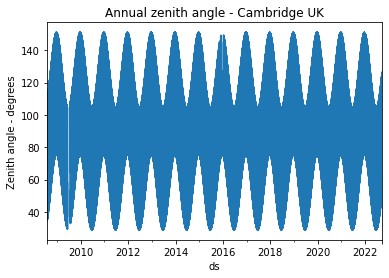

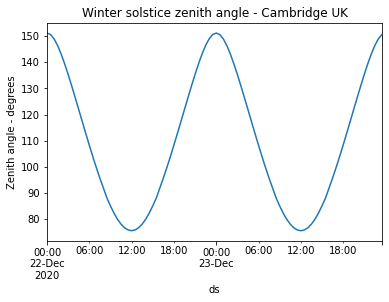

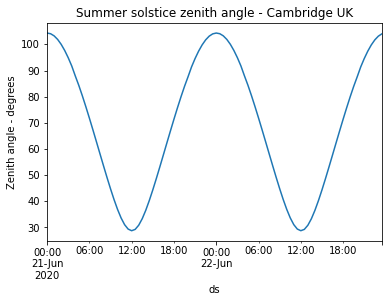

Zenith angles (degrees):


count    236948.000000
mean         89.267922
std          29.679325
min          28.767886
25%          67.542727
50%          88.824724
75%         110.897925
max         151.223633
Name: za, dtype: float64

Calculating irradiance: 100%|██████████| 17338/17338 [00:05<00:00, 3036.87it/s]


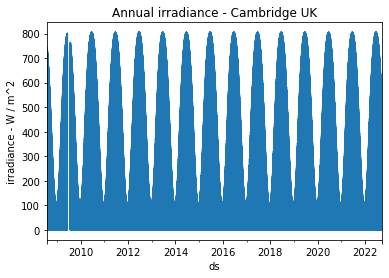

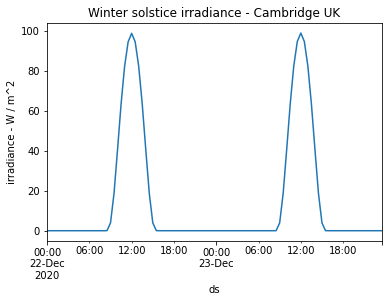

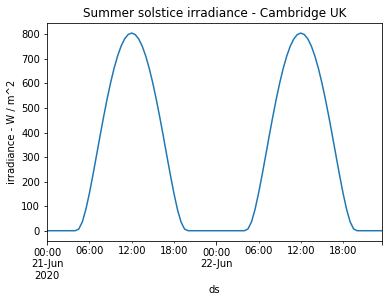

Irradiances:


count    236948.000000
mean        144.590234
std         227.286088
min           0.000000
25%           0.000000
50%           0.002045
75%         224.316841
max         805.382014
Name: irradiance, dtype: float64

In [5]:
required  = {'pysolar', 'solarpy'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing   = required - installed

if missing == required:
    print('Installing', missing, '...', sep=' ', end='')
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing])  #, stdout=subprocess.DEVNULL)
    print(' Done')


from pysolar.solar import *
from solarpy import irradiance_on_plane, declination


def calc_solar_data(df, solar_calc):
  IYEAR = 2020  # arbitrary year
  LAT   = 52.210922
  LON   =  0.091964


  df['year'] = df['ds'].dt.year
  data = pd.DataFrame()
  data.index = df.loc[df['year'] == IYEAR, 'ds']
  data.index = pd.to_datetime(data.index)

  if solar_calc == 'declination':
    declinations = [0] * len(data)
    i = 0

    for d in tqdm(data.index, desc='Calculating ' + solar_calc):
      declinations[i] = declination(d)
      i += 1

    data['declination'] = declinations
  elif solar_calc == 'irradiance':
    HEIGHT = 6  # height above sea level
    VNORM  = np.array([0, 0, -1])  # plane pointing zenith
    irradiances  = [0] * len(data)
    i = 0

    for d in tqdm(data.index, desc='Calculating ' + solar_calc):
      irradiances[i] = irradiance_on_plane(VNORM, HEIGHT, d, LAT)
      i += 1

    data['irradiance'] = irradiances
  elif solar_calc == 'zenith':
    za = [0] * len(data)
    za_rad = [0] * len(data)
    i = 0

    for d in tqdm(data.index, desc='Calculating ' + solar_calc):
      ts = pd.Timestamp(d, tz='UTC').to_pydatetime()
      za[i] = float(90) - get_altitude(LAT, LON, ts)
      za_rad[i] = np.radians(za[i])
      i += 1

    data['za'] = za
    data['za_rad'] = za_rad
  else:
    print("Unknown solar_calc parameter:", solar_calc, 
          "\nUse 'declination', 'irradiance' or 'zenith'")

  print()
  data['month']  = data.index.month
  data['day']    = data.index.day
  data['hour']   = data.index.hour
  data['minute'] = data.index.minute

  df['month']  = df.index.month
  df['day']    = df.index.day
  df['hour']   = df.index.hour
  df['minute'] = df.index.minute

  merge_cols = ['month', 'day', 'hour', 'minute']
  df = df.merge(data, on=merge_cols)
  df.drop(merge_cols, inplace=True, axis=1)
  df.set_index('ds', drop=False, inplace=True)
  df = df[~df.index.duplicated(keep='first')]
  df = df.asfreq(freq='30min')

  return df


def plot_solar_data(solar, title, ylab):
  solar.plot()
  plt.ylabel(ylab)
  plt.title(title)
  plt.show()


df = calc_solar_data(df, 'zenith')
za_lab = 'Zenith angle - degrees'
plot_solar_data(df['za'], 
                'Annual zenith angle - Cambridge UK', 
                za_lab)
plot_solar_data(df.loc['2020-12-22':'2020-12-23', 'za'], 
                'Winter solstice zenith angle - Cambridge UK',
                za_lab)
plot_solar_data(df.loc['2020-06-21':'2020-06-22', 'za'],
                'Summer solstice zenith angle - Cambridge UK',
                za_lab)

print('Zenith angles (degrees):')
display(df['za'].describe())


df = calc_solar_data(df, 'irradiance')
irr_ylab = 'irradiance - W / m^2'
plot_solar_data(df['irradiance'], 
                'Annual irradiance - Cambridge UK', 
                irr_ylab)
plot_solar_data(df.loc['2020-12-22':'2020-12-23', 'irradiance'], 
                'Winter solstice irradiance - Cambridge UK',
                irr_ylab)
plot_solar_data(df.loc['2020-06-21':'2020-06-22', 'irradiance'],
                'Summer solstice irradiance - Cambridge UK',
                irr_ylab)

print('Irradiances:')
display(df['irradiance'].describe())
print()


# df = calc_solar_data(df, 'declination')
# plot_solar_data(df['declination'], 
#                 'Annual declination - Cambridge UK', 
#                 'declination - radians')
#
# print('Declinations:')
# display(df['declination'].describe())

There is zero solar irradiance at night.  Hence the near zero median value for irradiance.

---

### Import tsfresh features

[tsfresh](https://tsfresh.readthedocs.io/en/latest/) features were generated and filtered in [this notebook]().  [Here](https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html) is a list of the features extracted by tsfresh.

Features were generated for:
 * individual observations
   * no data leakage concerns so generated features are saved in a single file
 * rolling observations with window size of 50
   * 48 + 2 to capture all lagged features from the previous 24 hours
   * data leakage concerns mean features are generated and saved in 3 files
     * training data
     * validation data
     * testing data

The rolling window features are loaded after the data is split into train, valid and test sets.

First, load the individual observations features and merge with existing data:

In [6]:
if TSFRESH:
    if 'google.colab' in str(get_ipython()):
        tsf_url = "https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/data/tsfresh.2022.09.20.csv.xz?raw=true"
    else:
        tsf_url = "../data/tsfresh.2022.09.20.csv.xz"


    tsf = pd.read_csv(tsf_url, compression='xz', parse_dates=['ds'])
    tsf.set_index('ds', drop=True, inplace=True)
    # tsf = tsf.asfreq(freq='30min')

    print("tsf:")
    print(tsf.info())
    print(tsf.columns, "\n")
    print("df:")
    print(df.info(), "\n")

    df = pd.merge(df, tsf, left_index=True, right_index=True)

    df.set_index('ds', drop=False, inplace=True)
    df = df[~df.index.duplicated(keep='first')]
    df = df.asfreq(freq='30min')
    df.drop('ds.1', axis=1, inplace=True)
    print("df:")
    print(df.info())

Ultimately, the tsfresh features did not prove useful.  I leave the tsfresh import code here for possible future experiments.

---

### Split data¶

I use data from 2018 for validation, 2019 for testing and the remaining data for training. These are entirely arbitrary choices. This results in an approximate 88%, 6%, 6% split for the training, validation, and test sets respectively.

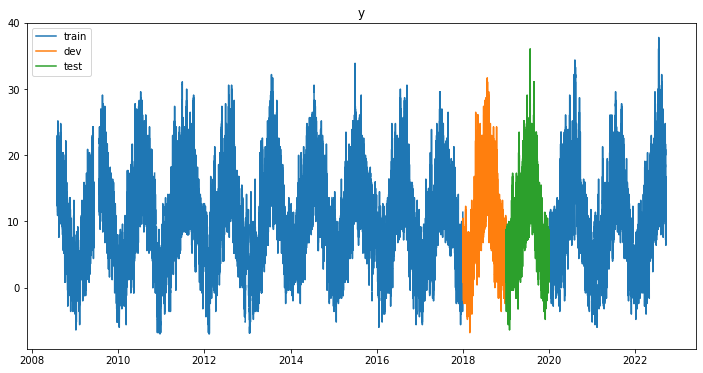

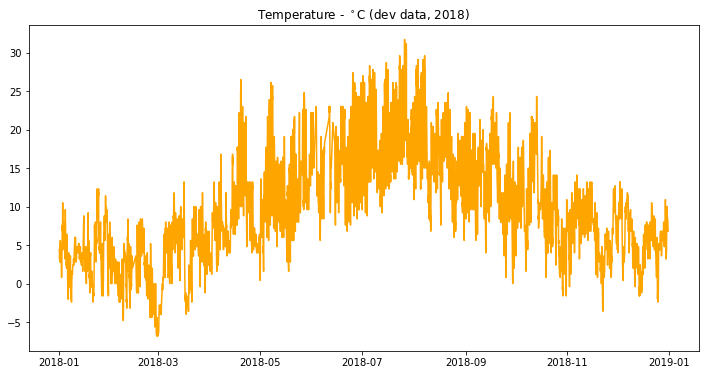

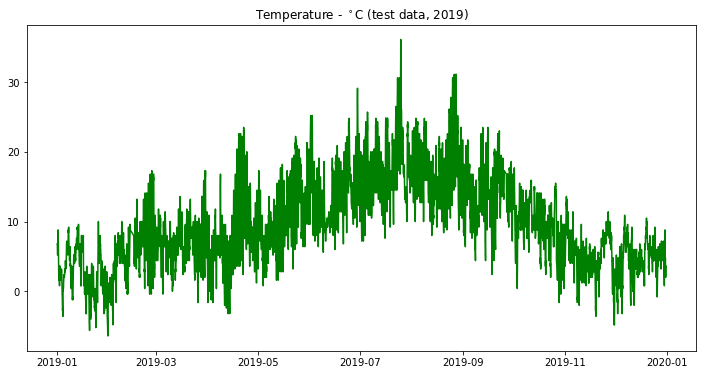

df.drop shape:  (247760, 63)
train shape:    (247760, 63)
valid shape:    (17484, 63)
test shape:     (17484, 63)


In [7]:
# df['year'] = df['ds'].dt.year
# train_df = df.loc[(df['year'] == 2015) | (df['year'] == 2016) | (df['year'] == 2017)]
# train_df = df.loc[(df['year'] == 2016) | (df['year'] == 2017)]
# train_df = df.loc[df['year'] <= 2017]
# train_df = df.loc[df['year'] == 2016]

train_df = df.loc[(df['year'] != 2018) & (df['year'] != 2019)]
valid_df = df.loc[df['year'] == 2018]
test_df  = df.loc[df['year'] == 2019]


def plot_feature_history(var):
    plt.figure(figsize = (12, 6))
    plt.plot(train_df.index, train_df[var])
    plt.plot(valid_df.index, valid_df[var])
    plt.plot(test_df.index,  test_df[var])
    plt.title(var)
    plt.legend(['train', 'dev', 'test'])
    plt.show()


plot_feature_history('y')


plt.figure(figsize = (12, 6))
plt.plot(valid_df.ds, valid_df.y, color='orange')
plt.title('Temperature - $^\circ$C (dev data, 2018)')
plt.show()

plt.figure(figsize = (12, 6))
plt.plot(test_df.ds, test_df.y, color='green')
plt.title('Temperature - $^\circ$C (test data, 2019)')
plt.show()


del_cols = ['year']
train_df = train_df.drop(del_cols, axis = 1)
valid_df = valid_df.drop(del_cols, axis = 1)
test_df  = test_df.drop(del_cols,  axis = 1)
df = df.drop(['year'], axis = 1)

# DO NOT USE ffill with train_df - ffills 2018 & 2019!
# train_df = train_df.asfreq(freq='30min', method='ffill')
train_df = train_df.asfreq(freq='30min', fill_value=np.nan)

# DO USE ffill with valid_df, test_df
# avoids missing value errors when calculating metrics etc
valid_df = valid_df.asfreq(freq='30min', fill_value=np.nan)
test_df  =  test_df.asfreq(freq='30min', fill_value=np.nan)
# valid_df = valid_df.asfreq(freq='30min', method='ffill')
# test_df  =  test_df.asfreq(freq='30min', method='ffill')


print("df.drop shape: ", df.shape)
print("train shape:   ", train_df.shape)
print("valid shape:   ", valid_df.shape)
print("test shape:    ", test_df.shape)

...

---

### Time series decomposition with prophet

Decomposition transforms time series into trend, seasonal and noise (residual) components.  These components are combined either additively or multiplicatively.  It is important to understand the time series components to better model and forecast future values.

[Prophet](https://facebook.github.io/prophet/) is a python and R package for forecasting.  It is based on a model where non-linear trends are fit with yearly, weekly, and daily seasonality but is quite flexible.  It works best with time series that have strong seasonal effects and several seasons of historical data.  In my experience it does not produce the best forecasts but I like its API and it can produce both additive and multiplicative multi-seasonal harmonic-based decompositions.  Like loess-based decompositions, a little parameter tuning is beneficial.  The details of how Prophet calculates multiplicative seasonality is outlined [here](https://github.com/facebook/prophet/issues/1245) and [here](https://www.kaggle.com/code/smakarychev/what-is-facebook-prophet-forecasting-model#Multiplicative-and-additive-terms).

The [Season-Trend decomposition using LOESS for multiple seasonalities](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.MSTL.html) from statsmodels is currently additive only and only available in the development version on github.

DEBUG:cmdstanpy:input tempfile: /tmp/tmp4f0x6o_u/qa_ic2l2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4f0x6o_u/fxku90bx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43284', 'data', 'file=/tmp/tmp4f0x6o_u/qa_ic2l2.json', 'init=/tmp/tmp4f0x6o_u/fxku90bx.json', 'output', 'file=/tmp/tmp4f0x6o_u/prophet_modelxurqtk91/prophet_model-20230306114928.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:49:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:49:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


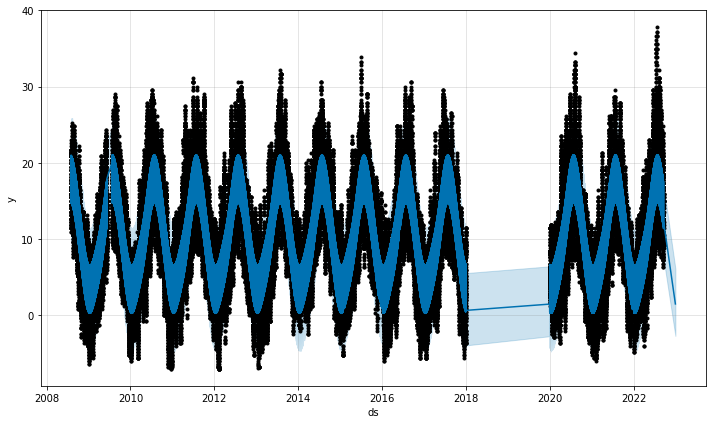

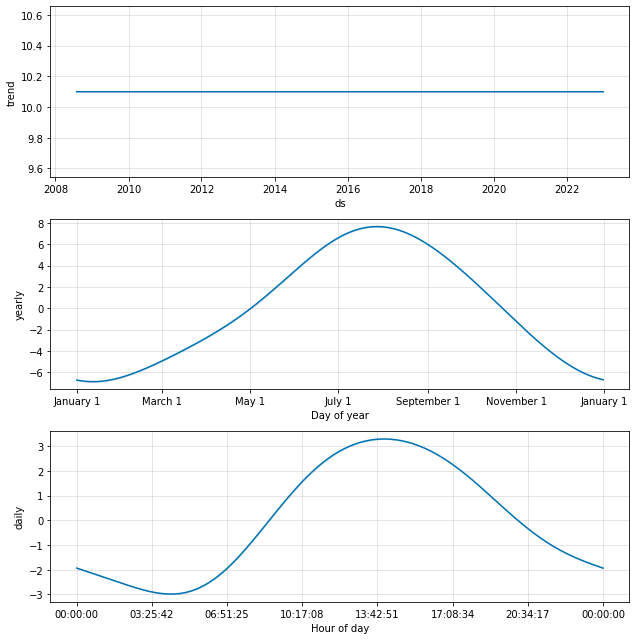

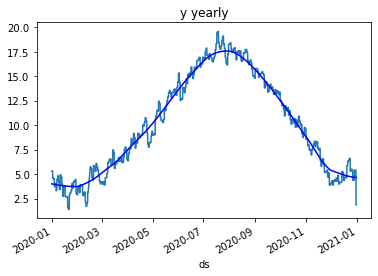

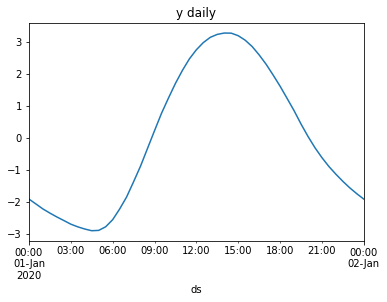

ds     y     y_res  humidity  \
ds                                                                  
2008-08-01 08:30:00 2008-08-01 08:30:00  18.6  0.653571      69.0   
2008-08-01 09:00:00 2008-08-01 09:00:00  19.1  0.603680      70.0   
2008-08-01 09:30:00 2008-08-01 09:30:00  19.5  0.461470      68.0   
2008-08-01 10:00:00 2008-08-01 10:00:00  20.0  0.484272      68.0   
2008-08-01 10:30:00 2008-08-01 10:30:00  21.3  1.327161      61.0   
...                                 ...   ...       ...       ...   
2022-09-18 22:00:00 2022-09-18 22:00:00   9.2 -3.169737      82.0   
2022-09-18 22:30:00 2022-09-18 22:30:00   9.2 -2.946908      81.0   
2022-09-18 23:00:00 2022-09-18 23:00:00   9.2 -2.742019      81.0   
2022-09-18 23:30:00 2022-09-18 23:30:00   9.2 -2.560060      75.0   
2022-09-19 00:00:00 2022-09-19 00:00:00   9.2 -2.817770      86.0   

                     humidity_daily  humidity_yearly  humidity_res  dew.point  \
ds                                                                              
2008-08-01 08:30:00        1.962292        69.357323     -2.319616       12.8   
2008-08-01 09:00:00       -0.477817        69.357323      1.120494       13.5   
2008-08-01 09:30:00       -2.898169        69.357323      1.540846       13.4   
2008-08-01 10:00:00       -5.220096        69.357323      3.862772       13.9   
2008-08-01 10:30:00       -7.348509        69.357323     -1.008815       13.5   
...                             ...              ...           ...        ...   
2022-09-18 22:00:00        4.879728        75.230585      1.889687        6.3   
2022-09-18 22:30:00        5.858070        75.230585     -0.088656        6.1   
2022-09-18 23:00:00        6.717624        75.230585     -0.948209        6.1   
2022-09-18 23:30:00        7.537405        75.230585     -7.767990        5.0   
2022-09-19 00:00:00        8.190356        77.341435      0.468209        7.0   

                     dew.point_daily  dew.point_yearly  ...  lin_interp  \
ds                                                      ...               
2008-08-01 08:30:00         0.155809         11.925293  ...         0.0   
2008-08-01 09:00:00         0.161065         11.925293  ...         0.0   
2008-08-01 09:30:00         0.167822         11.925293  ...         0.0   
2008-08-01 10:00:00         0.118302         11.925293  ...         0.0   
2008-08-01 10:30:00         0.071114         11.925293  ...         0.0   
...                              ...               ...  ...         ...   
2022-09-18 22:00:00         0.174554          8.588096  ...         0.0   
2022-09-18 22:30:00         0.134950          8.588096  ...         0.0   
2022-09-18 23:00:00         0.092988          8.588096  ...         0.0   
2022-09-18 23:30:00         0.080032          8.588096  ...         0.0   
2022-09-19 00:00:00         0.034972          9.581225  ...         0.0   

                             za    za_rad  irradiance  y_orig    y_trend  \
ds                                                                         
2008-08-01 08:30:00   54.151072  0.945114  466.076978    18.6  10.099971   
2008-08-01 09:00:00   49.896325  0.870855  534.939248    19.1  10.099971   
2008-08-01 09:30:00   45.905902  0.801209  596.151212    19.5  10.099971   
2008-08-01 10:00:00   42.289087  0.738084  648.222216    20.0  10.099971   
2008-08-01 10:30:00   39.178783  0.683799  689.953261    21.3  10.099971   
...                         ...       ...         ...     ...        ...   
2022-09-18 22:00:00  121.304701  2.117166    0.000000     9.2  10.099971   
2022-09-18 22:30:00  123.577372  2.156832    0.000000     9.2  10.099971   
2022-09-18 23:00:00  125.221336  2.185525    0.000000     9.2  10.099971   
2022-09-18 23:30:00  126.171761  2.202113    0.000000     9.2  10.099971   
2022-09-19 00:00:00  126.387817  2.205884    0.000000     9.2  10.099971   

                      y_daily  y_yearly     y_yhat     y_des  
ds                                                       

DEBUG:cmdstanpy:input tempfile: /tmp/tmp4f0x6o_u/k8vusud5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4f0x6o_u/dzn0opyu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27831', 'data', 'file=/tmp/tmp4f0x6o_u/k8vusud5.json', 'init=/tmp/tmp4f0x6o_u/dzn0opyu.json', 'output', 'file=/tmp/tmp4f0x6o_u/prophet_modeli1z7p_50/prophet_model-20230306115146.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:51:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:51:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


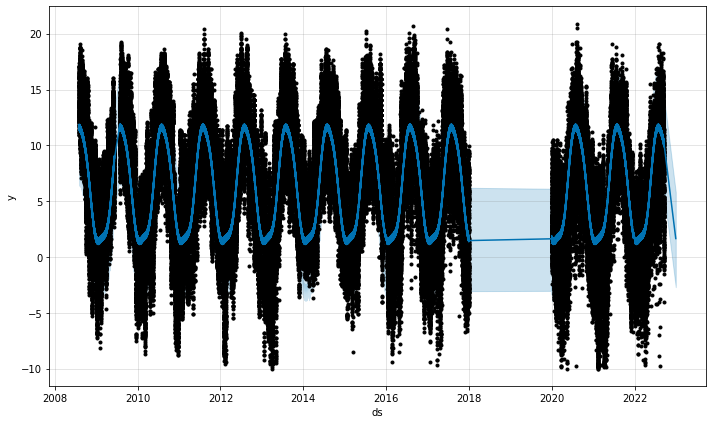

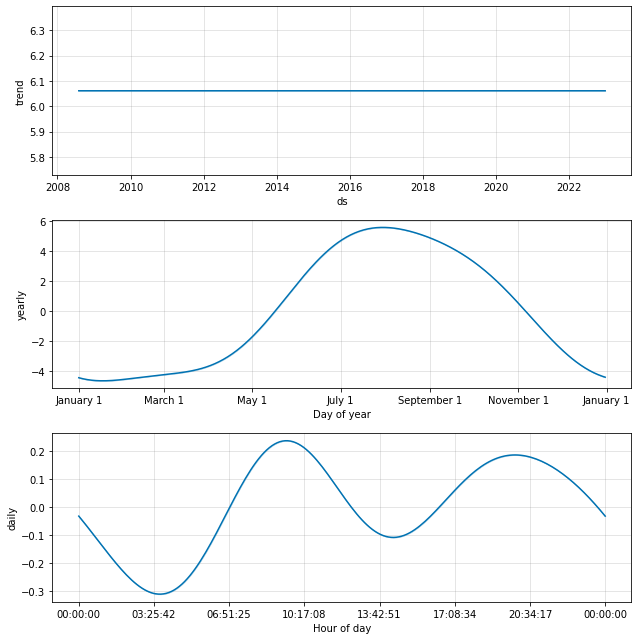

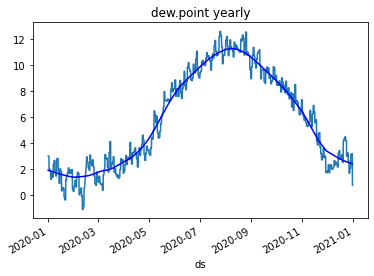

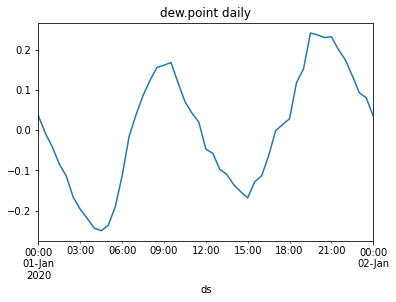

ds     y     y_res  humidity  \
ds                                                                  
2008-08-01 08:30:00 2008-08-01 08:30:00  12.8  0.653571      69.0   
2008-08-01 09:00:00 2008-08-01 09:00:00  13.5  0.603680      70.0   
2008-08-01 09:30:00 2008-08-01 09:30:00  13.4  0.461470      68.0   
2008-08-01 10:00:00 2008-08-01 10:00:00  13.9  0.484272      68.0   
2008-08-01 10:30:00 2008-08-01 10:30:00  13.5  1.327161      61.0   
...                                 ...   ...       ...       ...   
2022-09-18 22:00:00 2022-09-18 22:00:00   6.3 -3.169737      82.0   
2022-09-18 22:30:00 2022-09-18 22:30:00   6.1 -2.946908      81.0   
2022-09-18 23:00:00 2022-09-18 23:00:00   6.1 -2.742019      81.0   
2022-09-18 23:30:00 2022-09-18 23:30:00   5.0 -2.560060      75.0   
2022-09-19 00:00:00 2022-09-19 00:00:00   7.0 -2.817770      86.0   

                     humidity_daily  humidity_yearly  humidity_res  dew.point  \
ds                                                                              
2008-08-01 08:30:00        1.962292        69.357323     -2.319616       12.8   
2008-08-01 09:00:00       -0.477817        69.357323      1.120494       13.5   
2008-08-01 09:30:00       -2.898169        69.357323      1.540846       13.4   
2008-08-01 10:00:00       -5.220096        69.357323      3.862772       13.9   
2008-08-01 10:30:00       -7.348509        69.357323     -1.008815       13.5   
...                             ...              ...           ...        ...   
2022-09-18 22:00:00        4.879728        75.230585      1.889687        6.3   
2022-09-18 22:30:00        5.858070        75.230585     -0.088656        6.1   
2022-09-18 23:00:00        6.717624        75.230585     -0.948209        6.1   
2022-09-18 23:30:00        7.537405        75.230585     -7.767990        5.0   
2022-09-19 00:00:00        8.190356        77.341435      0.468209        7.0   

                     dew.point_res  pressure  ...    y_trend   y_daily  \
ds                                            ...                        
2008-08-01 08:30:00       0.718899    1010.0  ...  10.099971 -0.307252   
2008-08-01 09:00:00       1.413642    1010.0  ...  10.099971  0.244166   
2008-08-01 09:30:00       1.306885    1010.0  ...  10.099971  0.784777   
2008-08-01 10:00:00       1.856405    1010.0  ...  10.099971  1.296260   
2008-08-01 10:30:00       1.503593    1010.0  ...  10.099971  1.763478   
...                            ...       ...  ...        ...       ...   
2022-09-18 22:00:00      -2.462651    1024.0  ...  10.099971 -1.187096   
2022-09-18 22:30:00      -2.623047    1024.0  ...  10.099971 -1.413568   
2022-09-18 23:00:00      -2.581084    1024.0  ...  10.099971 -1.608371   
2022-09-18 23:30:00      -3.668128    1024.0  ...  10.099971 -1.779094   
2022-09-19 00:00:00      -2.616197    1024.0  ...  10.099971 -1.934429   

                     y_yearly     y_yhat     y_des  dew.point_trend  \
ds                                                                    
2008-08-01 08:30:00  7.608836  17.401555  1.198445         6.061397   
2008-08-01 09:00:00  7.608526  17.952663  1.147337         6.061397   
2008-08-01 09:30:00  7.608215  18.492963  1.007037         6.061397   
2008-08-01 10:00:00  7.607903  19.004134  0.995866         6.061397   
2008-08-01 10:30:00  7.607589  19.471038  1.828962         6.061397   
...                       ...        ...       ...              ...   
2022-09-18 22:00:00  4.175627  13.088502 -3.888502         6.061397   
2022-09-18 22:30:00  4.173290  12.859694 -3.659694         6.061397   
2022-09-18 23:00:00  4.170953  12.662553 -3.462553         6.061397   
2022-09-18 23:30:00  4.168615  12.489493 -3.289493         6.061397   
2022-09-19 00:00:00  4.166277  12.331818 -3.131818         6.061397   

                     dew.point_daily  dew.point_yearly  dew.point_yhat  \
ds                                                                       
2008-08-01 08:30:00         0.197763          5.57

DEBUG:cmdstanpy:input tempfile: /tmp/tmp4f0x6o_u/xnpt9av2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4f0x6o_u/ll0v8a2m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5521', 'data', 'file=/tmp/tmp4f0x6o_u/xnpt9av2.json', 'init=/tmp/tmp4f0x6o_u/ll0v8a2m.json', 'output', 'file=/tmp/tmp4f0x6o_u/prophet_modelnpsybhm_/prophet_model-20230306115357.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:53:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:54:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


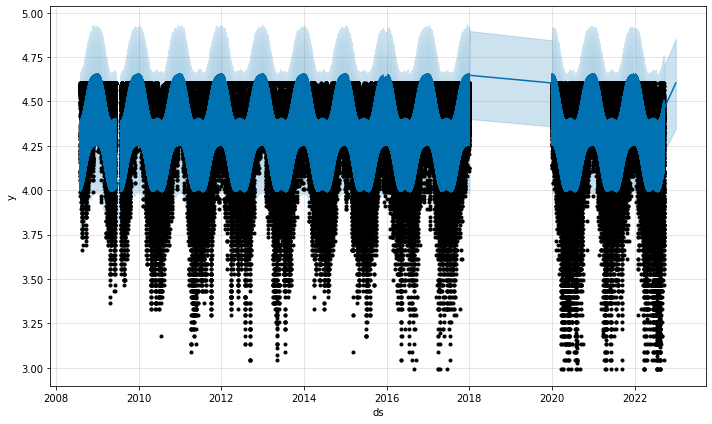

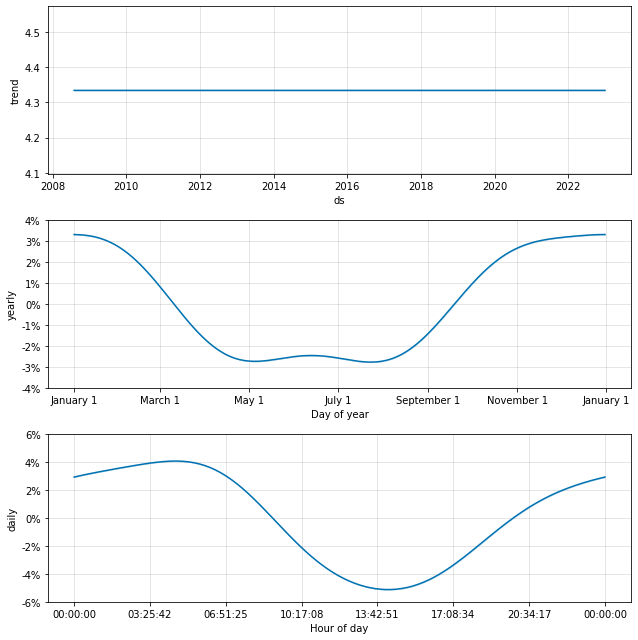

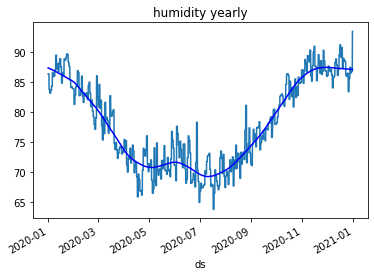

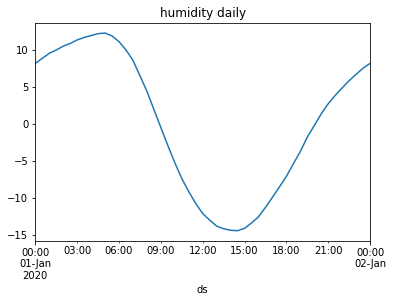

ds         y     y_res  humidity  \
ds                                                                      
2008-08-01 08:30:00 2008-08-01 08:30:00  4.234107  0.653571      69.0   
2008-08-01 09:00:00 2008-08-01 09:00:00  4.248495  0.603680      70.0   
2008-08-01 09:30:00 2008-08-01 09:30:00  4.219508  0.461470      68.0   
2008-08-01 10:00:00 2008-08-01 10:00:00  4.219508  0.484272      68.0   
2008-08-01 10:30:00 2008-08-01 10:30:00  4.110874  1.327161      61.0   
...                                 ...       ...       ...       ...   
2022-09-18 22:00:00 2022-09-18 22:00:00  4.406719 -3.169737      82.0   
2022-09-18 22:30:00 2022-09-18 22:30:00  4.394449 -2.946908      81.0   
2022-09-18 23:00:00 2022-09-18 23:00:00  4.394449 -2.742019      81.0   
2022-09-18 23:30:00 2022-09-18 23:30:00  4.317488 -2.560060      75.0   
2022-09-19 00:00:00 2022-09-19 00:00:00  4.454347 -2.817770      86.0   

                     humidity_res  dew.point  dew.point_res  pressure  \
ds                                                                      
2008-08-01 08:30:00     -2.319616       12.8       0.718899    1010.0   
2008-08-01 09:00:00      1.120494       13.5       1.413642    1010.0   
2008-08-01 09:30:00      1.540846       13.4       1.306885    1010.0   
2008-08-01 10:00:00      3.862772       13.9       1.856405    1010.0   
2008-08-01 10:30:00     -1.008815       13.5       1.503593    1010.0   
...                           ...        ...            ...       ...   
2022-09-18 22:00:00      1.889687        6.3      -2.462651    1024.0   
2022-09-18 22:30:00     -0.088656        6.1      -2.623047    1024.0   
2022-09-18 23:00:00     -0.948209        6.1      -2.581084    1024.0   
2022-09-18 23:30:00     -7.767990        5.0      -3.668128    1024.0   
2022-09-19 00:00:00      0.468209        7.0      -2.616197    1024.0   

                     pressure_daily  pressure_yearly  ...  dew.point_trend  \
ds                                                    ...                    
2008-08-01 08:30:00        0.246341      1014.181521  ...         6.061397   
2008-08-01 09:00:00        0.294896      1014.181521  ...         6.061397   
2008-08-01 09:30:00        0.310954      1014.181521  ...         6.061397   
2008-08-01 10:00:00        0.326464      1014.181521  ...         6.061397   
2008-08-01 10:30:00        0.306592      1014.181521  ...         6.061397   
...                             ...              ...  ...              ...   
2022-09-18 22:00:00        0.446780      1015.673822  ...         6.061397   
2022-09-18 22:30:00        0.436451      1015.673822  ...         6.061397   
2022-09-18 23:00:00        0.418659      1015.673822  ...         6.061397   
2022-09-18 23:30:00        0.397929      1015.673822  ...         6.061397   
2022-09-19 00:00:00        0.330120      1018.218850  ...         6.061397   

                     dew.point_daily  dew.point_yearly  dew.point_yhat  \
ds                                                                       
2008-08-01 08:30:00         0.197763          5.577716       11.836876   
2008-08-01 09:00:00         0.226962          5.577633       11.865992   
2008-08-01 09:30:00         0.235917          5.577549       11.874863   
2008-08-01 10:00:00         0.224759          5.577464       11.863620   
2008-08-01 10:30:00         0.195590          5.577379       11.834366   
...                              ...               ...             ...   
2022-09-18 22:00:00         0.120888          4.064482       10.246767   
2022-09-18 22:30:00         0.089801          4.063335       10.214533   
2022-09-18 23:00:00         0.053449          4.062188       10.177035   
2022-09-18 23:30:00         0.012161          4.061040       10.134598   
2022-09-19 00:00:00        -0.033484          4.059892       10.087805   

                     dew.point_des  humidity_trend  humidity_daily  \
ds                                                                   
2008-08-01 08:30:00

DEBUG:cmdstanpy:input tempfile: /tmp/tmp4f0x6o_u/_w3tx7sg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4f0x6o_u/psctgpp3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42833', 'data', 'file=/tmp/tmp4f0x6o_u/_w3tx7sg.json', 'init=/tmp/tmp4f0x6o_u/psctgpp3.json', 'output', 'file=/tmp/tmp4f0x6o_u/prophet_modele65w7rcf/prophet_model-20230306115601.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:56:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:56:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


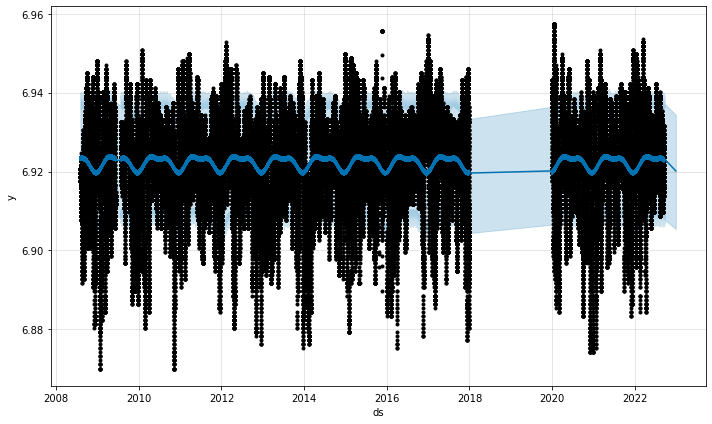

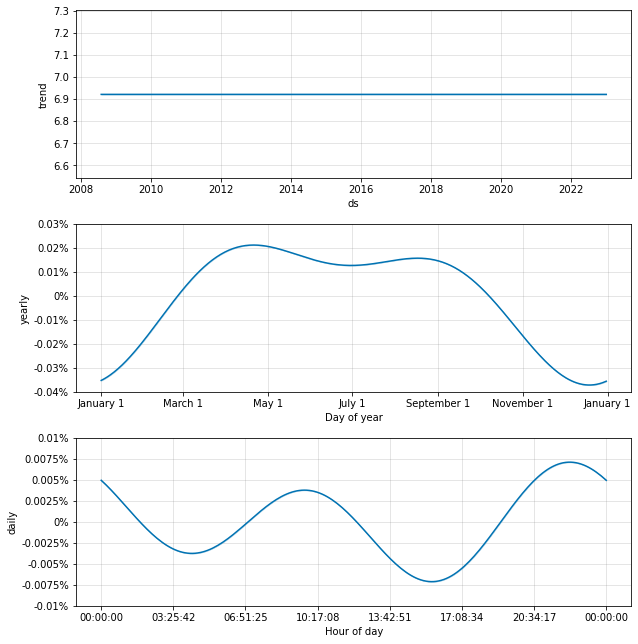

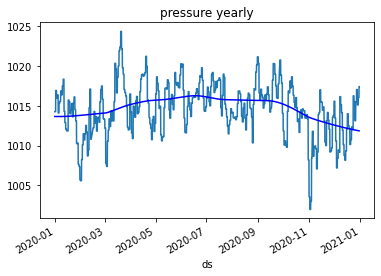

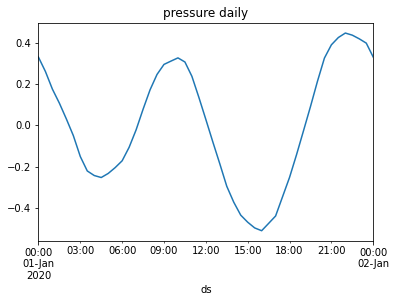

DEBUG:cmdstanpy:input tempfile: /tmp/tmp4f0x6o_u/5ohcu5z3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4f0x6o_u/ix2xkq4e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38638', 'data', 'file=/tmp/tmp4f0x6o_u/5ohcu5z3.json', 'init=/tmp/tmp4f0x6o_u/ix2xkq4e.json', 'output', 'file=/tmp/tmp4f0x6o_u/prophet_model0q8ddey5/prophet_model-20230306115813.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:58:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:58:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


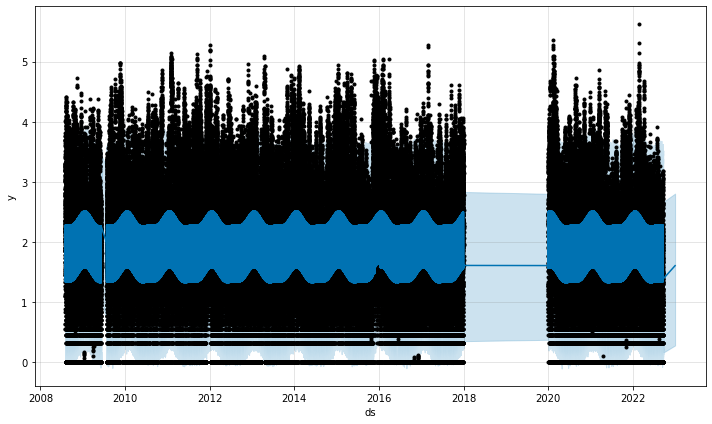

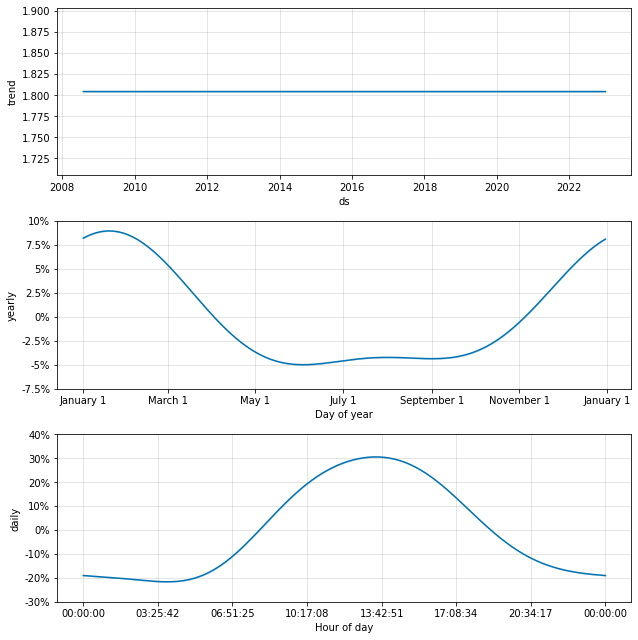

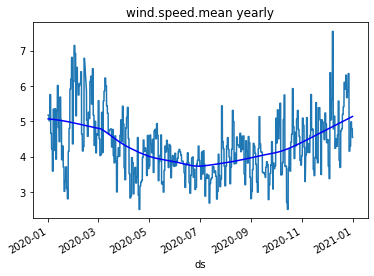

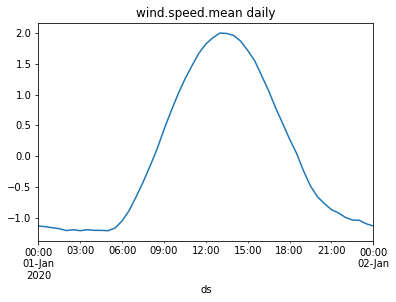

ds     y     y_res  humidity  \
ds                                                                  
2008-08-01 08:30:00 2008-08-01 08:30:00  18.6  0.653571      69.0   
2008-08-01 09:00:00 2008-08-01 09:00:00  19.1  0.603680      70.0   
2008-08-01 09:30:00 2008-08-01 09:30:00  19.5  0.461470      68.0   
2008-08-01 10:00:00 2008-08-01 10:00:00  20.0  0.484272      68.0   
2008-08-01 10:30:00 2008-08-01 10:30:00  21.3  1.327161      61.0   
...                                 ...   ...       ...       ...   
2022-09-18 22:00:00 2022-09-18 22:00:00   9.2 -3.169737      82.0   
2022-09-18 22:30:00 2022-09-18 22:30:00   9.2 -2.946908      81.0   
2022-09-18 23:00:00 2022-09-18 23:00:00   9.2 -2.742019      81.0   
2022-09-18 23:30:00 2022-09-18 23:30:00   9.2 -2.560060      75.0   
2022-09-19 00:00:00 2022-09-19 00:00:00   9.2 -2.817770      86.0   

                     humidity_res  dew.point  dew.point_res  pressure  \
ds                                                                      
2008-08-01 08:30:00     -2.319616       12.8       0.718899    1010.0   
2008-08-01 09:00:00      1.120494       13.5       1.413642    1010.0   
2008-08-01 09:30:00      1.540846       13.4       1.306885    1010.0   
2008-08-01 10:00:00      3.862772       13.9       1.856405    1010.0   
2008-08-01 10:30:00     -1.008815       13.5       1.503593    1010.0   
...                           ...        ...            ...       ...   
2022-09-18 22:00:00      1.889687        6.3      -2.462651    1024.0   
2022-09-18 22:30:00     -0.088656        6.1      -2.623047    1024.0   
2022-09-18 23:00:00     -0.948209        6.1      -2.581084    1024.0   
2022-09-18 23:30:00     -7.767990        5.0      -3.668128    1024.0   
2022-09-19 00:00:00      0.468209        7.0      -2.616197    1024.0   

                     pressure_res  pressure.log  ...  wind.speed.mean_yhat  \
ds                                               ...                         
2008-08-01 08:30:00     -4.427863      6.917706  ...              1.797208   
2008-08-01 09:00:00     -4.476417      6.917706  ...              1.882950   
2008-08-01 09:30:00     -4.492476      6.917706  ...              1.964183   
2008-08-01 10:00:00     -4.507985      6.917706  ...              2.038133   
2008-08-01 10:30:00     -4.488114      6.917706  ...              2.102951   
...                           ...           ...  ...                   ...   
2022-09-18 22:00:00      7.879397      6.931472  ...              1.432002   
2022-09-18 22:30:00      7.889727      6.931472  ...              1.414756   
2022-09-18 23:00:00      7.907519      6.931472  ...              1.402194   
2022-09-18 23:30:00      7.928249      6.931472  ...              1.393065   
2022-09-19 00:00:00      5.451031      6.931472  ...              1.386154   

                     wind.speed.mean_des  wind.speed.mean_daily.x  \
ds                                                                  
2008-08-01 08:30:00             1.951436                -0.038471   
2008-08-01 09:00:00             1.965719                -0.085991   
2008-08-01 09:30:00             1.856709                -0.131011   
2008-08-01 10:00:00             1.762229                -0.171996   
2008-08-01 10:30:00             1.810735                -0.207919   
...                                  ...                      ...   
2022-09-18 22:00:00             0.000000                -0.164668   
2022-09-18 22:30:00             0.000000                -0.174232   
2022-09-18 23:00:00             0.000000                -0.181199   
2022-09-18 23:30:00             0.000000                -0.186264   
2022-09-19 00:00:00             0.000000                -0.190100   

                     wind.speed.mean_daily.y  wind.speed.mean_yearly.x  \
ds                                                                       
2008-08-01 08:30:00             4.711313e-18                  0.042430   
2008-08-01 09:00:00             1.053085e-17          

y_trend   y_daily  y_yearly     y_yhat     y_des  \
key_0                                                                     
2008-08-01 08:30:00  10.099971 -0.307252  7.608836  17.401555  1.198445   
2008-08-01 09:00:00  10.099971  0.244166  7.608526  17.952663  1.147337   
2008-08-01 09:30:00  10.099971  0.784777  7.608215  18.492963  1.007037   
2008-08-01 10:00:00  10.099971  1.296260  7.607903  19.004134  0.995866   
2008-08-01 10:30:00  10.099971  1.763478  7.607589  19.471038  1.828962   
...                        ...       ...       ...        ...       ...   
2022-09-18 22:30:00  10.099971 -1.413568  4.173290  12.859694 -3.659694   
2022-09-18 23:00:00  10.099971 -1.608371  4.170953  12.662553 -3.462553   
2022-09-18 23:30:00  10.099971 -1.779094  4.168615  12.489493 -3.289493   
2022-09-19 00:00:00  10.099971 -1.934429  4.166277  12.331818 -3.131818   
2022-12-31 00:00:00  10.099971 -1.934429 -6.665996   1.499546       NaN   

                     dew.point_trend  dew.point_daily  dew.point_yearly  \
key_0                                                                     
2008-08-01 08:30:00         6.061397         0.197763          5.577716   
2008-08-01 09:00:00         6.061397         0.226962          5.577633   
2008-08-01 09:30:00         6.061397         0.235917          5.577549   
2008-08-01 10:00:00         6.061397         0.224759          5.577464   
2008-08-01 10:30:00         6.061397         0.195590          5.577379   
...                              ...              ...               ...   
2022-09-18 22:30:00         6.061397         0.089801          4.063335   
2022-09-18 23:00:00         6.061397         0.053449          4.062188   
2022-09-18 23:30:00         6.061397         0.012161          4.061040   
2022-09-19 00:00:00         6.061397        -0.033484          4.059892   
2022-12-31 00:00:00         6.061397        -0.033484         -4.381836   

                     dew.point_yhat  dew.point_des  ...  pressure_trend  \
key_0                                               ...                   
2008-08-01 08:30:00       11.836876       0.963124  ...        6.922265   
2008-08-01 09:00:00       11.865992       1.634008  ...        6.922265   
2008-08-01 09:30:00       11.874863       1.525137  ...        6.922265   
2008-08-01 10:00:00       11.863620       2.036380  ...        6.922265   
2008-08-01 10:30:00       11.834366       1.665634  ...        6.922265   
...                             ...            ...  ...             ...   
2022-09-18 22:30:00       10.214533      -4.114533  ...        6.922265   
2022-09-18 23:00:00       10.177035      -4.077035  ...        6.922265   
2022-09-18 23:30:00       10.134598      -5.134598  ...        6.922265   
2022-09-19 00:00:00       10.087805      -3.087805  ...        6.922265   
2022-12-31 00:00:00        1.646077            NaN  ...        6.922265   

                     pressure_daily  pressure_yearly  pressure_yhat  \
key_0                                                                 
2008-08-01 08:30:00        0.000029         0.000150       6.923507   
2008-08-01 09:00:00        0.000035         0.000150       6.923546   
2008-08-01 09:30:00        0.000038         0.000150       6.923565   
2008-08-01 10:00:00        0.000037         0.000150       6.923561   
2008-08-01 10:30:00        0.000033         0.000150       6.923534   
...                             ...              ...            ...   
2022-09-18 22:30:00        0.000071         0.000098       6.923430   
2022-09-18 23:00:00        0.000067         0.000098       6.923404   
2022-09-18 23:30:00        0.000060         0.000098       6.923353   
2022-09-19 00:00:00        0.000049         0.000097       6.923282   
2022-12-31 00:00:00        0.000049        -0.000355       6.920147   

                     pressure_des  wind.speed.mean_trend  \
key_0                                                      
2008-08-01 08:30:00      0.999162               1.8

valid_df


ds    y     y_res  humidity  \
ds                                                                 
2018-01-01 00:00:00 2018-01-01 00:00:00  4.4  0.993120      74.0   
2018-01-01 00:30:00 2018-01-01 00:30:00  4.4  1.146040      80.0   
2018-01-01 01:00:00 2018-01-01 01:00:00  4.0  0.900892      92.0   
2018-01-01 01:30:00 2018-01-01 01:30:00  3.6  0.630081      81.0   
2018-01-01 02:00:00 2018-01-01 02:00:00  3.6  0.750895      88.0   
...                                 ...  ...       ...       ...   
2018-12-31 03:30:00 2018-12-31 03:30:00  7.2  4.574728      87.0   
2018-12-31 04:00:00 2018-12-31 04:00:00  7.2  4.642715      91.0   
2018-12-31 04:30:00 2018-12-31 04:30:00  6.8  4.295726      87.0   
2018-12-31 05:00:00 2018-12-31 05:00:00  6.8  4.285722      87.0   
2018-12-31 05:30:00 2018-12-31 05:30:00  6.8  4.172977      87.0   

                     humidity_res  dew.point  dew.point_res  pressure  \
ds                                                                      
2018-01-01 00:00:00    -20.611804        0.2      -2.833956     992.0   
2018-01-01 00:30:00    -15.281344        1.3      -1.691181     993.0   
2018-01-01 01:00:00     -3.962749        2.8      -0.157082     994.0   
2018-01-01 01:30:00    -15.407658        0.8      -2.114762     994.0   
2018-01-01 02:00:00     -8.921570        1.8      -1.084577     995.0   
...                           ...        ...            ...       ...   
2018-12-31 03:30:00    -11.554800        5.2       2.236890    1037.0   
2018-12-31 04:00:00     -7.813505        5.8       2.860735    1037.0   
2018-12-31 04:30:00    -12.063159        4.8       1.867255    1037.0   
2018-12-31 05:00:00    -12.146481        4.8       1.854005    1037.0   
2018-12-31 05:30:00    -11.758019        4.8       1.808661    1037.0   

                     pressure_res  pressure.log  ...  humidity_des  \
ds                                               ...                 
2018-01-01 00:00:00    -22.588132      6.899723  ...      0.934810   
2018-01-01 00:30:00    -21.518516      6.900731  ...      0.950178   
2018-01-01 01:00:00    -20.433214      6.901737  ...      0.979018   
2018-01-01 01:30:00    -20.365263      6.901737  ...      0.950118   
2018-01-01 02:00:00    -19.288937      6.902743  ...      0.966743   
...                           ...           ...  ...           ...   
2018-12-31 03:30:00     21.199546      6.944087  ...      0.960791   
2018-12-31 04:00:00     21.221660      6.944087  ...      0.969662   
2018-12-31 04:30:00     21.231280      6.944087  ...      0.959624   
2018-12-31 05:00:00     21.211583      6.944087  ...      0.959860   
2018-12-31 05:30:00     21.183278      6.944087  ...      0.960909   

                     pressure_des  wind.speed.mean_daily.x  \
ds                                                           
2018-01-01 00:00:00      0.997045             1.344211e-01   
2018-01-01 00:30:00      0.997203             1.367083e-01   
2018-01-01 01:00:00      0.997362             1.389545e-01   
2018-01-01 01:30:00      0.997376             1.414383e-01   
2018-01-01 02:00:00      0.997534             1.442732e-01   
...                           ...                      ...   
2018-12-31 03:30:00      1.003541             1.523830e-01   
2018-12-31 04:00:00      1.003545             1.527789e-01   
2018-12-31 04:30:00      1.003545             3.907565e-17   
2018-12-31 05:00:00      1.003542             1.442477e-01   
2018-12-31 05:30:00      1.003536             3.465777e-17   

                     wind.speed.mean_daily.y  wind.speed.mean_yearly.x  \
ds                                                                       
2018-01-01 00:00:00                 0.134421             -5.812224e-02   
2018-01-01 00:30:00                 0.136708             -5.813417e-02   
2018-01-01 01:00:00                 0.138954             -5.814609e-02   
2018-01-01 01:30:00                 0.141438             -5.815799e-02   
2018-01-01 02:00:00                 0.14

test_df


ds    y     y_res  humidity  \
ds                                                                 
2019-01-01 00:00:00 2019-01-01 00:00:00  6.8  3.393120      73.0   
2019-01-01 00:30:00 2019-01-01 00:30:00  6.8  3.546040      76.0   
2019-01-01 01:00:00 2019-01-01 01:00:00  6.8  3.700892      75.0   
2019-01-01 01:30:00 2019-01-01 01:30:00  6.8  3.830081      68.0   
2019-01-01 02:00:00 2019-01-01 02:00:00  6.4  3.550895      86.0   
...                                 ...  ...       ...       ...   
2019-12-31 03:30:00 2019-12-31 03:30:00  2.8  0.174728      99.0   
2019-12-31 04:00:00 2019-12-31 04:00:00  3.2  0.642715      85.0   
2019-12-31 04:30:00 2019-12-31 04:30:00  3.6  1.095726      95.0   
2019-12-31 05:00:00 2019-12-31 05:00:00  3.6  1.085722      95.0   
2019-12-31 05:30:00 2019-12-31 05:30:00  3.6  0.972977      95.0   

                     humidity_res  dew.point  dew.point_res  pressure  \
ds                                                                      
2019-01-01 00:00:00    -21.611804        2.3      -0.733956    1035.0   
2019-01-01 00:30:00    -19.281344        2.9      -0.091181    1035.0   
2019-01-01 01:00:00    -20.962749        2.7      -0.257082    1035.0   
2019-01-01 01:30:00    -28.407658        1.3      -1.614762    1034.0   
2019-01-01 02:00:00    -10.921570        4.2       1.315423    1035.0   
...                           ...        ...            ...       ...   
2019-12-31 03:30:00      0.445200        2.7      -0.263110    1032.0   
2019-12-31 04:00:00    -13.813505        0.9      -2.039265    1033.0   
2019-12-31 04:30:00     -4.063159        2.9      -0.032745    1033.0   
2019-12-31 05:00:00     -4.146481        2.9      -0.045995    1033.0   
2019-12-31 05:30:00     -3.758019        2.9      -0.091339    1033.0   

                     pressure_res  pressure.log  ...  humidity_des  \
ds                                               ...                 
2019-01-01 00:00:00     20.411868      6.942157  ...      0.931855   
2019-01-01 00:30:00     20.481484      6.942157  ...      0.939056   
2019-01-01 01:00:00     20.566786      6.942157  ...      0.934785   
2019-01-01 01:30:00     19.634737      6.941190  ...      0.912295   
2019-01-01 02:00:00     20.711063      6.942157  ...      0.961779   
...                           ...           ...  ...           ...   
2019-12-31 03:30:00     16.199546      6.939254  ...      0.988590   
2019-12-31 04:00:00     17.221660      6.940222  ...      0.955000   
2019-12-31 04:30:00     17.231280      6.940222  ...      0.978526   
2019-12-31 05:00:00     17.211583      6.940222  ...      0.978767   
2019-12-31 05:30:00     17.183278      6.940222  ...      0.979837   

                     pressure_des  wind.speed.mean_daily.x  \
ds                                                           
2019-01-01 00:00:00      1.003177             3.492083e-17   
2019-01-01 00:30:00      1.003189             3.551502e-17   
2019-01-01 01:00:00      1.003203             3.609854e-17   
2019-01-01 01:30:00      1.003077             3.674380e-17   
2019-01-01 02:00:00      1.003230             3.748027e-17   
...                           ...                      ...   
2019-12-31 03:30:00      1.002842             1.523830e-01   
2019-12-31 04:00:00      1.002986             1.527789e-01   
2019-12-31 04:30:00      1.002986             1.504143e-01   
2019-12-31 05:00:00      1.002983             1.442477e-01   
2019-12-31 05:30:00      1.002977             1.334085e-01   

                     wind.speed.mean_daily.y  wind.speed.mean_yearly.x  \
ds                                                                       
2019-01-01 00:00:00                 0.190100             -1.509939e-17   
2019-01-01 00:30:00                 0.193335             -1.510249e-17   
2019-01-01 01:00:00                 0.196511             -1.510559e-17   
2019-01-01 01:30:00                 0.200024             -1.510868e-17   
2019-01-01 02:00:00                 0.20

df.drop shape:  (247760, 63)
train shape:    (247760, 80)
valid shape:    (17484, 80)
test shape:     (17484, 80)


In [8]:
def merge_decompositions(df, decomps):
  '''NOTE: changes made here may also need to be made in add_prophet_components function'''

  decomp_cols  = ['y', 'dew.point', 'humidity', 'pressure', 'wind.speed.mean']
  decomp_terms = ['daily', 'yearly', 'des']

  df_drop_cols = [j + '_' + i for i in decomp_terms for j in decomp_cols]
  df.drop(df_drop_cols, axis=1, inplace=True)

  # decomps_drop_cols = [j + '_des' for j in decomp_cols]
  # decomps.drop(decomps_drop_cols, axis=1, inplace=True)

  df = df[~df.index.duplicated(keep='first')]
  decomps = decomps[~decomps.index.duplicated(keep='first')]

  # NEXT Merge on month, day, time

  df['month']  = df.index.month
  df['day']    = df.index.day
  df['hour']   = df.index.hour
  df['minute'] = df.index.minute
  decomps['month']  = decomps.index.month
  decomps['day']    = decomps.index.day
  decomps['hour']   = decomps.index.hour
  decomps['minute'] = decomps.index.minute

  merge_cols = ['month','day','hour','minute']
  df = df.merge(decomps, on=merge_cols)
  # df = pd.merge(df, decomps, left_on=df.index, right_on=decomps.index)
  df.set_index('ds', drop=False, inplace=True)
  df = df[~df.index.duplicated(keep='first')]
  # df.drop('key_0', axis=1, inplace=True)
  df.drop(merge_cols, axis=1, inplace=True)

  for j in decomp_cols:
    if j in ['y', 'dew.point']:
      df[j + '_des'] = df[j] - df[j + '_yhat']
    elif j in ['humidity', 'pressure']:
      df[j + '_des'] = np.log(df[j]) / df[j + '_yhat']
    elif j in ['wind.speed.mean']:
      df[j + '_des'] = np.sqrt(df[j]) / df[j + '_yhat']

      for var in ['_daily', '_yearly', '_des', '_yhat']:
        df = convert_wind_to_xy(df, 'wind.speed.mean', 'wind.bearing.mean', var)

  df = df.dropna()
  df = df.asfreq(freq='30min', fill_value=np.nan)

  return df


def add_prophet_components(df, m, col_name, l_frac = 3000):
  '''NOTE: changes made here may also need to be made in merge_decompositions function'''

  # lmbda = 0.0

  if col_name == 'y':
    df['y'] = df['y_orig']
  elif col_name == 'dew.point':
    df['y'] = df[col_name]
  elif col_name == 'pressure':
    x = np.log(df[col_name])
    df['y'] = x   
  elif col_name ==  'humidity':
    x = np.log(df[col_name])
    df['y'] = x  
    # x, lmbda = stats.boxcox(df[col_name])
    # df['y'] = x
    # print('lambda:', lmbda)
  elif col_name == 'wind.speed.mean':
    x = np.sqrt(df[col_name])
    df['y'] = x      

  m.fit(df)
  future = m.make_future_dataframe(periods=1, freq='Y').dropna()
  forecast = m.predict(future)
  m.plot(forecast)
  m.plot_components(forecast)
  plt.show()

  n = YEARLY_OBS
  df['year'] = df['ds'].dt.year
  y_l = lowess(df.loc[df.year == 2020, col_name + '_yearly'], df.loc[df.year == 2020, 'ds'], frac=l_frac / YEARLY_OBS)
  df.loc[df.year == 2020, col_name + '_yearly'].head(n).plot()
  plt.plot(df.loc[df.year == 2020, 'ds'].head(n), y_l[:n, 1], 'blue', label='lowess fit')
  plt.title(col_name + ' yearly')
  plt.show()

  # n = DAILY_OBS * 2 + 1
  n = DAILY_OBS + 1
  df.loc[df.year == 2020, col_name + '_daily'].head(n).plot()
  # plt.axvline(x=pd.to_datetime('2020-01-01 00:00:00'), color='black', lw=1)  # why did this line suddenly stop working!
  # plt.axvline(x=pd.to_datetime('00:00 02-Jan-2020'), color='black', lw=1)
  # plt.axvline(x=pd.Timestamp('00:00 02-Jan-2020'), color='black', lw=1)
  # plt.axvline(x=df.index.values[48], color='black', lw=1)
  # somewhere someone is watching the world burn
  plt.title(col_name + ' daily')
  plt.show()

  forecast.set_index('ds', drop=False, inplace=True)
  f_cols_old = ['trend', 'daily', 'yearly', 'yhat']
  forecast.rename(columns={f_col: col_name + '_' + f_col for f_col in f_cols_old}, 
                  inplace=True)

  if col_name in ['y', 'dew.point']:
    forecast[col_name + '_des'] = df['y'] - forecast[col_name + '_yhat']
  elif col_name in ['humidity', 'pressure', 'wind.speed.mean']:
    forecast[col_name + '_des'] = df['y'] / forecast[col_name + '_yhat']
  #if col_name in ['y', 'dew.point', 'wind.speed.mean']:
  #  forecast[col_name + '_des'] = df['y'] - forecast['yhat']
  #else:
  #  forecast[col_name + '_des'] = df['y'] - special.inv_boxcox(forecast['yhat'], lmbda)

  f_cols_new = [col_name + '_' + f_col for f_col in f_cols_old]
  f_cols_new.append(col_name + '_des')

  forecast = forecast[f_cols_new]

  drop_cols = [col_name + '_' + i for i in ['daily', 'yearly', 'des']]
  df.drop(drop_cols, axis=1, inplace=True)
  df = pd.merge(df, forecast, left_on=df.index, right_on=forecast.index)
  df.set_index('ds', drop=False, inplace=True)
  df.drop(['key_0', 'year'], axis=1, inplace=True)
  df = df.dropna()
  df = df.asfreq(freq='30min', fill_value=np.nan)

  return df, forecast


train_df['y_orig'] = train_df['y']
col_name = 'y'
m1 = Prophet(yearly_seasonality = 3, 
             daily_seasonality  = 3, 
             weekly_seasonality = False,
             growth = 'flat')
train_df, f1 = add_prophet_components(train_df, m1, col_name)
display(train_df)

col_name = 'dew.point'
m2 = Prophet(yearly_seasonality = 3, 
             daily_seasonality  = 3, 
             weekly_seasonality = False,
             growth = 'flat')
train_df, f2 = add_prophet_components(train_df, m2, col_name)
display(train_df)

col_name = 'humidity'
m3 = Prophet(yearly_seasonality = 3, 
             weekly_seasonality = False,
             seasonality_mode   = 'multiplicative',
             growth = 'flat')
train_df, f3 = add_prophet_components(train_df, m3, col_name)
display(train_df)

col_name = 'pressure'
m4 = Prophet(yearly_seasonality = 2, 
             daily_seasonality  = 2,
             weekly_seasonality = False,
             seasonality_mode   = 'multiplicative',
             growth = 'flat')
train_df, f4 = add_prophet_components(train_df, m4, col_name, 6000)

col_name = 'wind.speed.mean'
m5 = Prophet(yearly_seasonality = 2, 
             daily_seasonality  = True,
             weekly_seasonality = False,
             seasonality_mode   = 'multiplicative',
             growth = 'flat')
train_df, f5 = add_prophet_components(train_df, m5, col_name, 6000)


# Convert wind direction and speed to x and y vectors, so the model can more easily interpret them
#wd_rad = train_df['wind.bearing.mean'] * np.pi / 180  # Convert to radians
#
#for var in ['_daily', '_yearly', '_des', '_yhat']:
#  wv = train_df['wind.speed.mean' + var]
#
#  # Calculate the wind x and y components
#  train_df['wind.speed.mean.x' + var] = wv * np.cos(wd_rad)
#  train_df['wind.speed.mean.y' + var] = wv * np.sin(wd_rad)

for var in ['_daily', '_yearly', '_des', '_yhat']:
  train_df = convert_wind_to_xy(train_df, 'wind.speed.mean', 'wind.bearing.mean', var)

train_df['y'] = train_df['y_orig']
train_df.drop('y_orig', inplace=True, axis=1)
display(train_df)


f_all = pd.merge(f1, f2, left_on=f1.index, right_on=f2.index)
f_all.set_index('key_0', inplace=True)
f_all = pd.merge(f_all, f3, left_on=f_all.index, right_on=f3.index)
f_all.set_index('key_0', inplace=True)
f_all = pd.merge(f_all, f4, left_on=f_all.index, right_on=f4.index)
f_all.set_index('key_0', inplace=True)
f_all = pd.merge(f_all, f5, left_on=f_all.index, right_on=f5.index)
f_all.set_index('key_0', inplace=True)
display(f_all)


decomps_drop_cols = [j + '_des' for j in ['y', 'dew.point', 'humidity', 'pressure']]
f_all.drop(decomps_drop_cols, axis=1, inplace=True)

valid_df = merge_decompositions(valid_df, f_all)
print('valid_df')
display(valid_df)

test_df  = merge_decompositions(test_df,  f_all)
print('test_df')
display(test_df)

#merge_cols = ['month', 'day', 'hour', 'minute']
#train_df.drop(merge_cols, inplace=True, axis=1)

del_cols = ['ds']
train_df = train_df.drop(del_cols, axis = 1)
valid_df = valid_df.drop(del_cols, axis = 1)
test_df  = test_df.drop(del_cols,  axis = 1)

print("df.drop shape: ", df.shape)
print("train shape:   ", train_df.shape)
print("valid shape:   ", valid_df.shape)
print("test shape:    ", test_df.shape)

**TODO** Avoid time spent building prophet models. Save and commit prophet decompositions (`f_all` above).  Then simply download from repo, merge with train, valid, test data and calculate deseasonalised features.

---

The yearly components have `_yearly` appended to feature names.  Similarly, `_daily` is used for daily components and `_des` is used for residuals.

I used flat trends for simplicity and tweaked the transformation, seasonality mode, daily harmonics and yearly harmonics.

The final decomposition parameters:

|  Feature   |       Mode     | Transform | Daily | Yearly |
|------------|----------------|-----------|-------|--------|
| y          | Additive       | None      |   3   |   3    |
| dew.point  | Additive       | None      |   3   |   3    |
| humidity   | Multiplicative | log       |   2   |  Auto  |
| pressure   | Multiplicative | log       |   2   |   2    |

The mode and transforms agree with [work elsewhere](https://www.researchgate.net/figure/Time-series-decomposition-A-Sea-surface-temperature-C-additive-decomposition_fig2_332292752).

I tried log, square root and Box-Cox transformations and tried to keep the daily and yearly harmonics reasonably low.

Using a flat trend may not be appropriate for humidity.

The daily seasonalities for `dew.point` and `pressure` each have two peaks.
There is some [supporting evidence for two daily peaks for atmospheric pressure](https://www.sciencedaily.com/releases/2008/12/081203092437.htm), but I'm not aware of any similar evidence for dew point.

The `pressure` decomposition would benefit from further attention.  The daily and yearly components are hundreths of a percent!  Despite this it always proves to be beneficial in the lightgbm models.

The `wind.speed.mean` and `irradiance` decompositions were unacceptible.
It should be possible to find daily and yearly decompositions for `irradiance` without any noise component.  An additive loess decomposition may be worth trying.  The wind speed may require more sophisticated decomposition techniques like [wavelets](https://en.wikipedia.org/wiki/Wavelet) for example.  Others have successfully used [multiplicative decomposition with smoothed wind speed data](https://files.core.ac.uk/pdf/2612/81865532.pdf).

We now have a richer set of features for lightgbm to choose from.  Also, we can model the deseasonalised temperatures, `y_des`, instead of the more complicated multi-seasonal temperatures `y`.  To make forecasts for `y`, `y_yearly` and `y_daily` must be added to the `y_des` predictions.


---

It is worthwhile looking at the stationarity of these time series after decomposition.

A stationary time series should have mean, variance and autocorrelation that do not change over time.  This means a flat series, without trend, constant variance, constant autocorrelation structure and no periodic fluctuations (seasonalities).

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss


def adf_test(timeseries, NLAGS):
    timeseries = timeseries.dropna()

    if NLAGS is not None:
      dftest = adfuller(timeseries, maxlag = NLAGS)
    else:
      dftest = adfuller(timeseries, autolag="AIC")

    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )

    print("Results of Dickey-Fuller Test:")
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value

    print(dfoutput)


def kpss_test(timeseries, NLAGS):
    timeseries = timeseries.dropna()

    if NLAGS is not None:
      kpsstest = kpss(timeseries, regression="c", nlags=NLAGS)
    else:
      kpsstest = kpss(timeseries, regression="c", nlags="auto")

    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )

    print("\nResults of KPSS Test:")
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value

    print(kpss_output)


def stationarity_tests(df, var, NLAGS=None):
    print(var)
    adf_test(df[var], NLAGS)
    kpss_test(df[var], NLAGS)
    print('\n')


for var in ['y', 'dew.point', 'humidity', 'pressure', 'wind.speed.mean', 
            'wind.speed.mean.x', 'wind.speed.mean.y', 'irradiance']:
    stationarity_tests(train_df, var)
    if var in ['y', 'dew.point', 'humidity', 'pressure', 'wind.speed.mean']:
        stationarity_tests(train_df, var + '_des')

y
Results of Dickey-Fuller Test:
Test Statistic                -1.433140e+01
p-value                        1.098324e-26
#Lags Used                     4.800000e+01
Number of Observations Used    2.027570e+05
Critical Value (1%)           -3.430382e+00
Critical Value (5%)           -2.861554e+00
Critical Value (10%)          -2.566778e+00
dtype: float64

Results of KPSS Test:
Test Statistic            1.235118
p-value                   0.010000
Lags Used                48.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


y_des


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Results of Dickey-Fuller Test:
Test Statistic                    -28.338498
p-value                             0.000000
#Lags Used                         48.000000
Number of Observations Used    202757.000000
Critical Value (1%)                -3.430382
Critical Value (5%)                -2.861554
Critical Value (10%)               -2.566778
dtype: float64

Results of KPSS Test:
Test Statistic            2.979338
p-value                   0.010000
Lags Used                48.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


dew.point


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Results of Dickey-Fuller Test:
Test Statistic                    -19.359434
p-value                             0.000000
#Lags Used                         48.000000
Number of Observations Used    202757.000000
Critical Value (1%)                -3.430382
Critical Value (5%)                -2.861554
Critical Value (10%)               -2.566778
dtype: float64

Results of KPSS Test:
Test Statistic            3.977396
p-value                   0.010000
Lags Used                48.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


dew.point_des


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Results of Dickey-Fuller Test:
Test Statistic                    -31.371909
p-value                             0.000000
#Lags Used                         48.000000
Number of Observations Used    202757.000000
Critical Value (1%)                -3.430382
Critical Value (5%)                -2.861554
Critical Value (10%)               -2.566778
dtype: float64

Results of KPSS Test:
Test Statistic           15.517653
p-value                   0.010000
Lags Used                48.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


humidity


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Results of Dickey-Fuller Test:
Test Statistic                    -25.753660
p-value                             0.000000
#Lags Used                         48.000000
Number of Observations Used    202757.000000
Critical Value (1%)                -3.430382
Critical Value (5%)                -2.861554
Critical Value (10%)               -2.566778
dtype: float64

Results of KPSS Test:
Test Statistic           18.102534
p-value                   0.010000
Lags Used                48.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


humidity_des


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Results of Dickey-Fuller Test:
Test Statistic                    -33.970643
p-value                             0.000000
#Lags Used                         48.000000
Number of Observations Used    202757.000000
Critical Value (1%)                -3.430382
Critical Value (5%)                -2.861554
Critical Value (10%)               -2.566778
dtype: float64

Results of KPSS Test:
Test Statistic           18.679166
p-value                   0.010000
Lags Used                48.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


pressure


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Results of Dickey-Fuller Test:
Test Statistic                    -26.623727
p-value                             0.000000
#Lags Used                         48.000000
Number of Observations Used    202757.000000
Critical Value (1%)                -3.430382
Critical Value (5%)                -2.861554
Critical Value (10%)               -2.566778
dtype: float64

Results of KPSS Test:
Test Statistic            4.082468
p-value                   0.010000
Lags Used                48.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


pressure_des


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Results of Dickey-Fuller Test:
Test Statistic                    -25.333680
p-value                             0.000000
#Lags Used                         48.000000
Number of Observations Used    202757.000000
Critical Value (1%)                -3.430382
Critical Value (5%)                -2.861554
Critical Value (10%)               -2.566778
dtype: float64

Results of KPSS Test:
Test Statistic            3.592301
p-value                   0.010000
Lags Used                48.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


wind.speed.mean


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Results of Dickey-Fuller Test:
Test Statistic                    -34.152857
p-value                             0.000000
#Lags Used                         48.000000
Number of Observations Used    202757.000000
Critical Value (1%)                -3.430382
Critical Value (5%)                -2.861554
Critical Value (10%)               -2.566778
dtype: float64

Results of KPSS Test:
Test Statistic           11.146659
p-value                   0.010000
Lags Used                48.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


wind.speed.mean_des


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Results of Dickey-Fuller Test:
Test Statistic                    -35.694919
p-value                             0.000000
#Lags Used                         48.000000
Number of Observations Used    202757.000000
Critical Value (1%)                -3.430382
Critical Value (5%)                -2.861554
Critical Value (10%)               -2.566778
dtype: float64

Results of KPSS Test:
Test Statistic           20.982646
p-value                   0.010000
Lags Used                48.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


wind.speed.mean.x


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Results of Dickey-Fuller Test:
Test Statistic                    -31.858301
p-value                             0.000000
#Lags Used                         48.000000
Number of Observations Used    202757.000000
Critical Value (1%)                -3.430382
Critical Value (5%)                -2.861554
Critical Value (10%)               -2.566778
dtype: float64

Results of KPSS Test:
Test Statistic            0.855909
p-value                   0.010000
Lags Used                48.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


wind.speed.mean.y


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Results of Dickey-Fuller Test:
Test Statistic                    -35.851023
p-value                             0.000000
#Lags Used                         48.000000
Number of Observations Used    202757.000000
Critical Value (1%)                -3.430382
Critical Value (5%)                -2.861554
Critical Value (10%)               -2.566778
dtype: float64

Results of KPSS Test:
Test Statistic            0.830417
p-value                   0.010000
Lags Used                48.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


irradiance


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Results of Dickey-Fuller Test:
Test Statistic                -1.103269e+01
p-value                        5.616423e-20
#Lags Used                     4.800000e+01
Number of Observations Used    2.027570e+05
Critical Value (1%)           -3.430382e+00
Critical Value (5%)           -2.861554e+00
Critical Value (10%)          -2.566778e+00
dtype: float64

Results of KPSS Test:
Test Statistic            3.205088
p-value                   0.010000
Lags Used                48.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64




/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


The relevant [statsmodels docs](https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html) explain the [ADF](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html) and [KPSS](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.kpss.html) tests plus provide help with interpretation of the p-values.

ADF:
 * <u>Null hypothesis</u>: the dataset is non-stationary and therefore differencing must be carried out. 
 * <u>Alternative hypothesis</u>: the dataset has no unit root and is therefore stationary.
 * If the null hypothesis failed to be rejected, this test may provide evidence that the series is non-stationary.

KPSS:
 * <u>Null hypothesis</u>: the series is trend stationary.  
 * <u>Alternative hypothesis</u>: the series is not stationary.
 * The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.

A Bonferroni-corrected p-value threshold of 0.005 (0.05 / 10) is used.


|   Feature     | ADF      | KPSS |   Result   |
|---------------|----------|------|------------|
| y             | 3.35e-23 | 0.1  | Stationary |
| y_des         | 0.0      | 0.01 | Stationary |
| dew.point     | 4.6e-29  | 0.01 | Stationary |
| dew.point_des | 0.0      | 0.01 | Stationary |
| humidity      | 0.0      | 0.01 | Stationary |
| humidity_des  | 0.0      | 0.01 | Stationary |
| pressure      | 0.0      | 0.01 | Stationary |
| pressure_des  | 0.0      | 0.01 | Stationary |
| wind.x        | 0.0      | 0.1  | Stationary |
| wind.y        | 0.0      | 0.1  | Stationary |

For all features tested, the ADF null hypothesis is rejected and the KPSS null hypothesis is accepted at the Bonferroni-corrected p-value threshold.
All of the features were stationary before and after transformation.

---

Next, plot the historic values for the original and decomposed residual features:

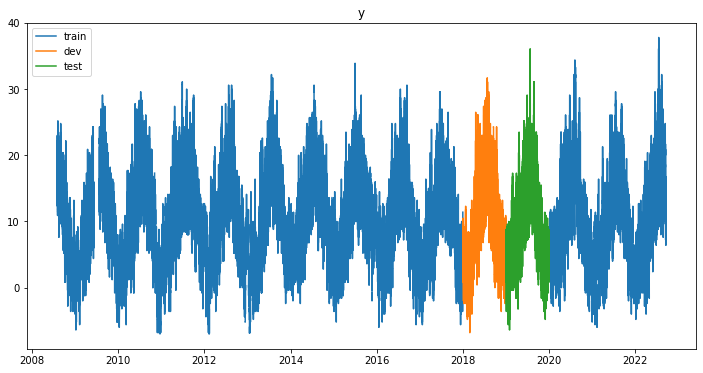

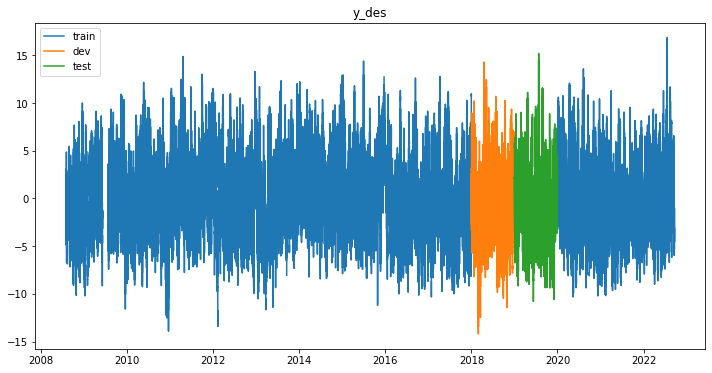

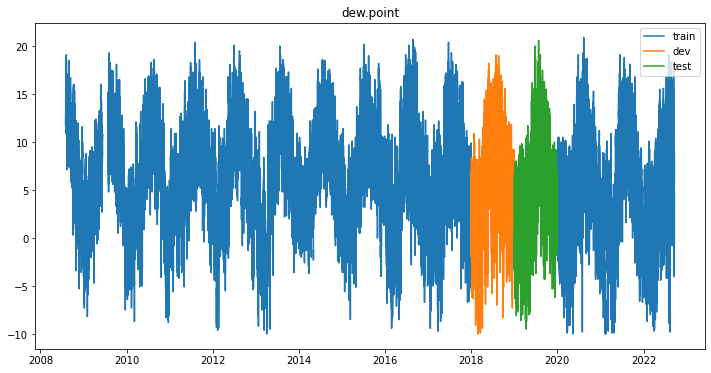

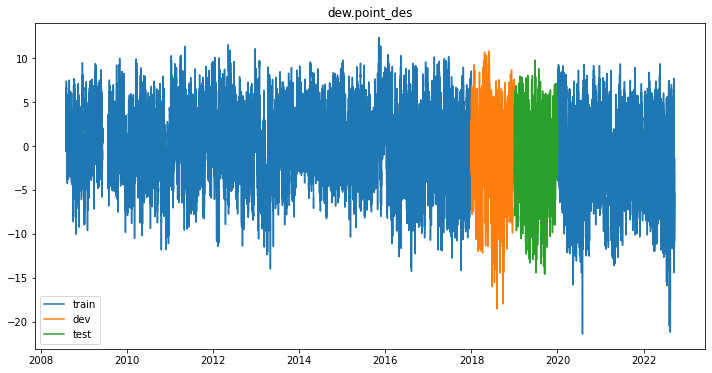

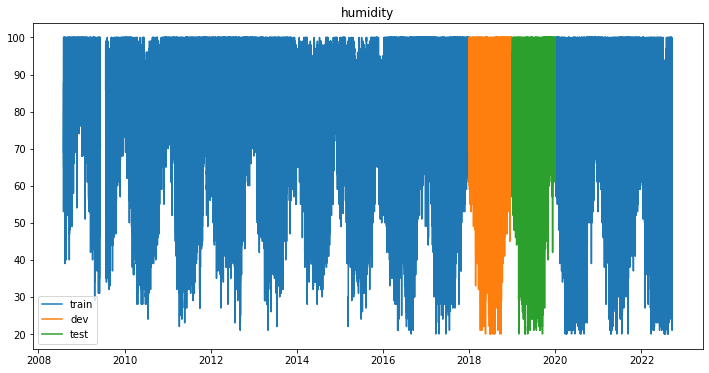

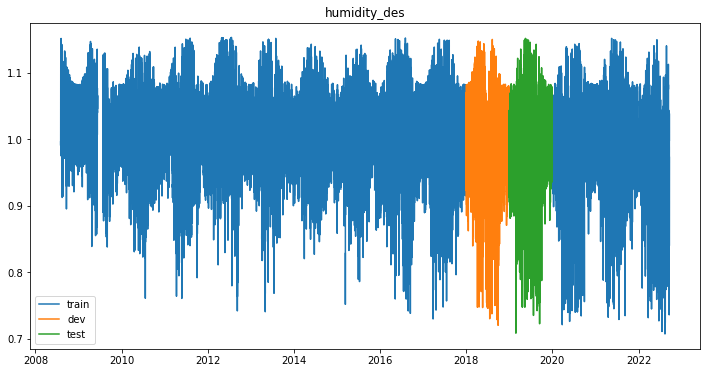

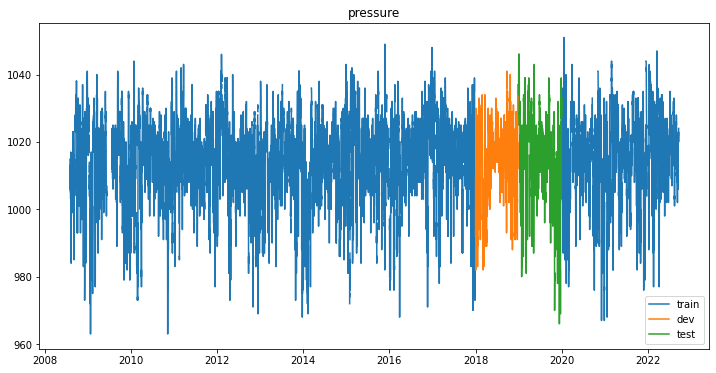

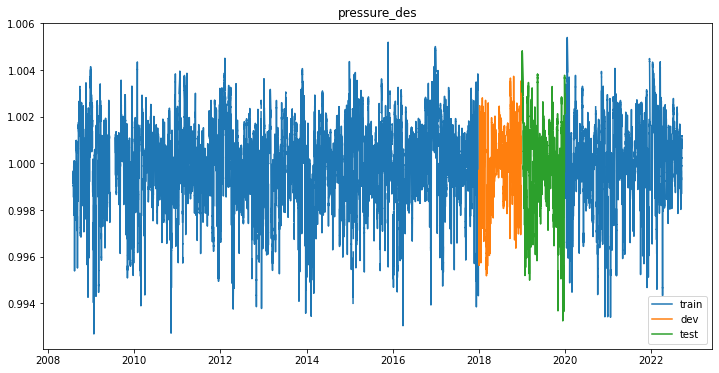

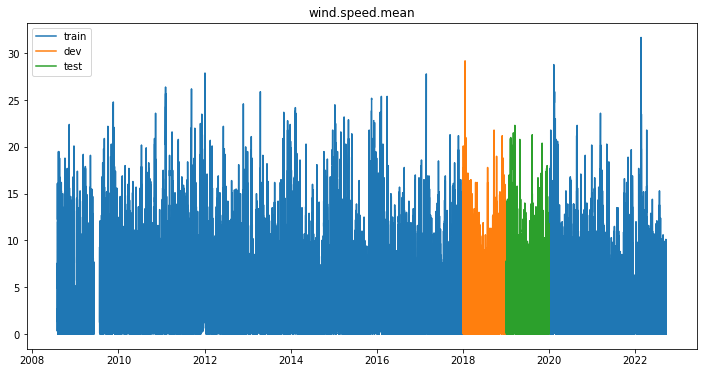

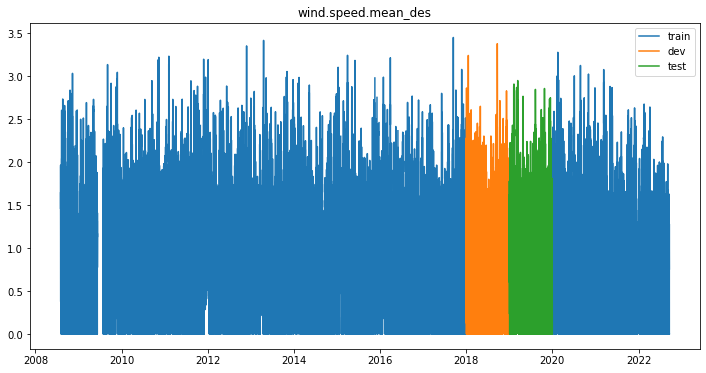

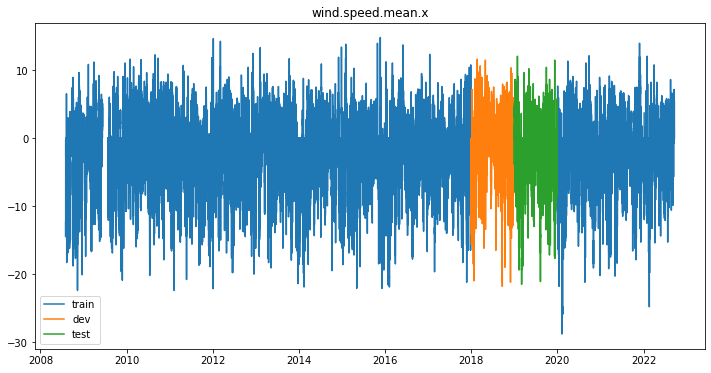

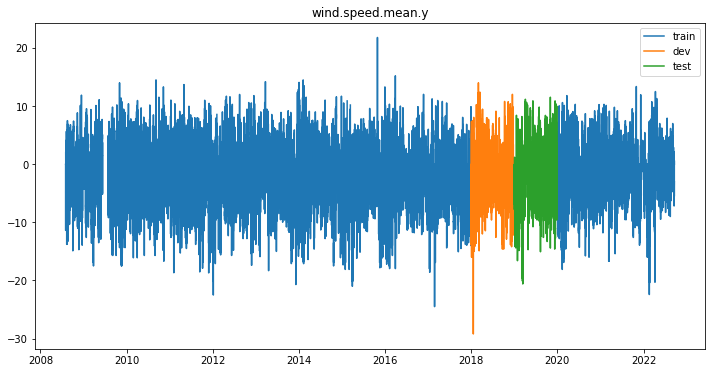

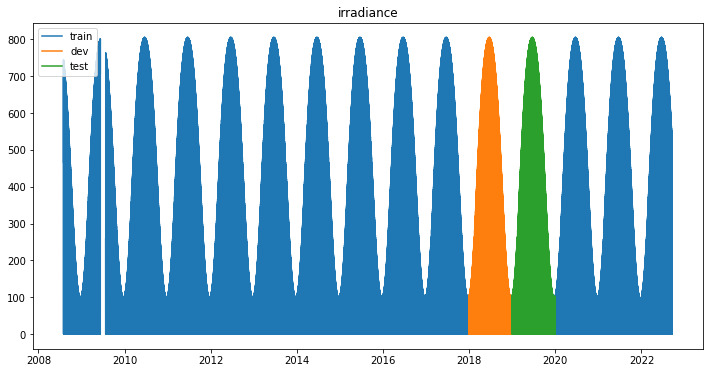

In [ ]:
for var in ['y', 'dew.point', 'humidity', 'pressure', 'wind.speed.mean', 
            'wind.speed.mean.x', 'wind.speed.mean.y', 'irradiance']:
    plot_feature_history(var)

    if var in ['y', 'dew.point', 'humidity', 'pressure', 'wind.speed.mean']:
        plot_feature_history(var + '_des')

A visual comparison of the original and residual features indicates:
  * possible longer than annual signal in `y_des`
  * possible annual signal remaining in `dew.point_des`
  * increasing heteroscadicity in `humidity` and `humidity_des`
  * decreasing trend in `humidity` and `humidity_des`
  * possible annual signal remaining in `humidity_des`
  * `pressure` and `pressure_des` appear similar
  * possible annual signal remaining in `pressure_des`

---

Plot clustered heatmap of correlations to find potential relationships between features and to understand the strength of these relationships:

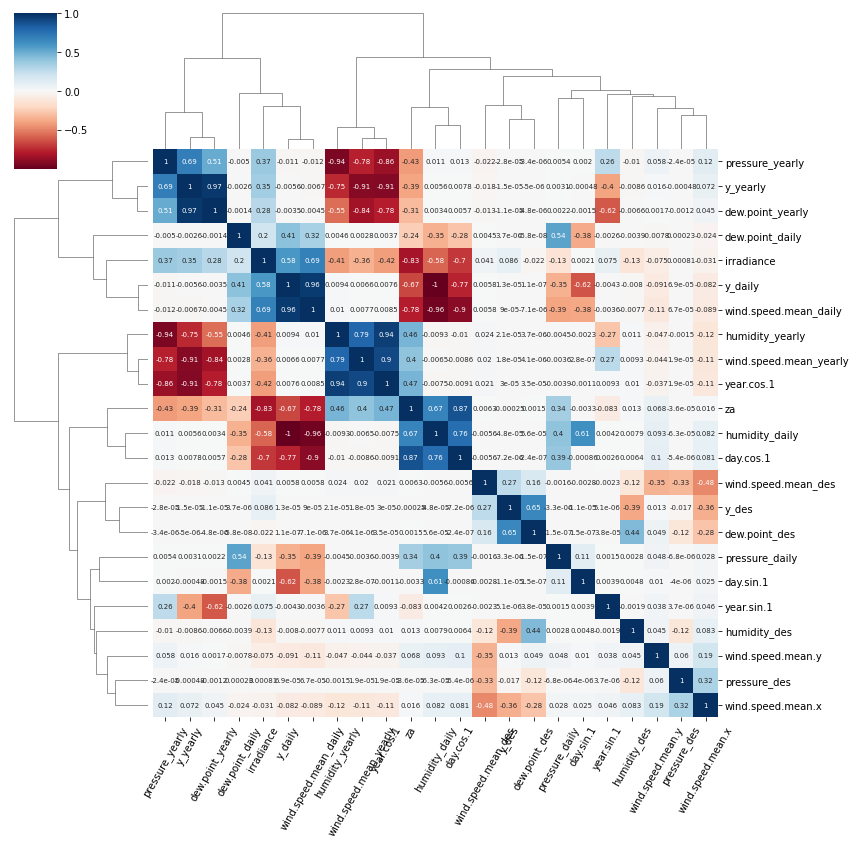

In [ ]:
train_df_red = train_df[['y_daily', 'y_yearly', 'y_des', 
                         'humidity_daily', 'humidity_yearly', 'humidity_des', 
                         'dew.point_daily', 'dew.point_yearly', 'dew.point_des', 
                         'pressure_daily', 'pressure_yearly', 'pressure_des', 
                         'wind.speed.mean_daily', 'wind.speed.mean_yearly', 
                         'wind.speed.mean_des', 'wind.speed.mean.x', 
                         'wind.speed.mean.y', 'irradiance', 'za',
                         'day.sin.1', 'day.cos.1', 'year.sin.1', 'year.cos.1']]

g = sns.clustermap(train_df_red.corr(), 
                   method = "complete", 
                   cmap   = 'RdBu', 
                   annot  = True, 
                   figsize=(12, 12),
                   annot_kws = {"size": 7})
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=60)
plt.show()

There is strong correlation between:
 * `y_yearly` and `dew.point_yearly`
 * `y_yearly` and `pressure_yearly`
 * `humidity_yearly` and `year.cos.1`

There is also some correlation between:
 * `y_des` and `dew.point_des`
 * `humidity_daily` and `day.cos.1`
 * `irradiance` and `y_daily`

**TODO** List negative correlation cases

---

Calculate some correlations, normalized univariate F-tests and normalized mutual information for feature selection purposes:

In [ ]:
from sklearn.feature_selection import f_regression, mutual_info_regression


comps = []
corrs = []
corr_cols = ['y', 'dew.point', 'humidity', 'pressure', 'wind.speed.mean']
for var in corr_cols:
  comps.append(var + ' - ' + var + '_des')
  corrs.append(train_df[var].corr(train_df[var + '_des']))

fs_df = pd.DataFrame({'comparison': comps, 'correlation': corrs})
display(fs_df)
print()


feat_cols = ['dew.point', 'humidity', 'pressure', 'irradiance', 'za',
             'wind.speed.mean', 'wind.speed.mean.x', 'wind.speed.mean.y', 
             'y_shadow']
mi_feats = mutual_info_regression(train_df[feat_cols].dropna(), train_df[Y_COL].dropna())
mi_feats /= np.max(mi_feats)
f_tests, _ = f_regression(train_df[feat_cols].dropna(), train_df[Y_COL].dropna())
f_tests /= np.max(f_tests)


comps = []
corrs = []
for var in feat_cols:
  if var in ['za', 'irradiance', 'wind.speed.mean.x', 'wind.speed.mean.y', 
             'y_shadow']:
    comps.append(var + ' - ' + Y_COL)
    corrs.append(train_df[var].corr(train_df[Y_COL]))
  else:
    comps.append(var + '_des - ' + Y_COL)
    corrs.append(train_df[var + '_des'].corr(train_df[Y_COL]))

fs_df = pd.DataFrame({'comparison': comps, 'correlation': corrs, 
                      'f_test': f_tests, 'mi': mi_feats})
display(fs_df)

comparison  correlation
0                              y - y_des     0.545336
1              dew.point - dew.point_des     0.678661
2                humidity - humidity_des     0.720139
3                pressure - pressure_des     0.993129
4  wind.speed.mean - wind.speed.mean_des     0.857703

comparison  correlation        f_test        mi
0        dew.point_des - y_des     0.648919  1.000000e+00  1.000000
1         humidity_des - y_des    -0.388335  3.499433e-01  0.308540
2         pressure_des - y_des    -0.017345  1.316057e-03  0.131671
3           irradiance - y_des     0.086166  3.108826e-02  0.311656
4                   za - y_des    -0.000246  2.511277e-07  0.517386
5  wind.speed.mean_des - y_des     0.265434  2.624885e-01  0.215144
6    wind.speed.mean.x - y_des    -0.360579  6.211267e-01  0.498150
7    wind.speed.mean.y - y_des     0.012963  6.985324e-04  0.162389
8             y_shadow - y_des     0.001267  6.672050e-06  0.000000

Surprisingly high correlation between `pressure` and `pressure_des`.
Surprisingly high statistics for `wind.x - y_des`.
The `y_shadow` feature is included as a negative control variable.

Not clear what the mutual information cutoff value for variable selection should be.  Regardless, these variables are only a subset of the features under consideration.

---

Calculate mutual information values for lagged `Y_COL`:

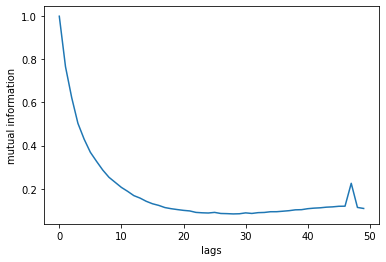

In [ ]:
from statsmodels.tsa.tsatools import lagmat


n_lags = HORIZON + 2
df_y_lags = lagmat(train_df[Y_COL], maxlag=n_lags, use_pandas=True)
df_y_lags[Y_COL] = train_df[Y_COL]
df_y_lags = df_y_lags.iloc[n_lags:, :]
df_y_lags.dropna(inplace=True)
# display(df_y_lags)

df_y = df_y_lags[Y_COL]
df_y_lags = df_y_lags.drop(Y_COL, axis=1)
mi_y_lags = mutual_info_regression(df_y_lags, df_y)
mi_y_lags = mi_y_lags[:n_lags]
mi_y_lags /= np.max(mi_y_lags)
# display(mi_y_lags)

plt.plot(mi_y_lags)
plt.xlabel('lags')
plt.ylabel('mutual information')
plt.show()


Little surprising to see such a sudden mutual information increase at 48 lags.
Also, no increase around 24 lags.

---

Plot various distributions:

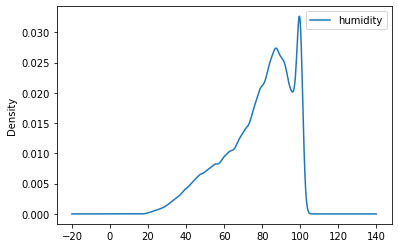

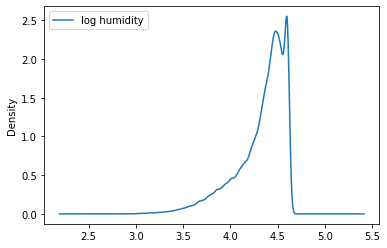

In [ ]:
col_name = 'humidity'
#df = df.loc[df['missing'] == 0.0, :]
df[col_name].plot(kind = 'density', label=col_name)
plt.legend()
plt.show()

np.log(df[col_name]).plot(kind = 'density', label='log ' + col_name)
plt.legend()
plt.show()

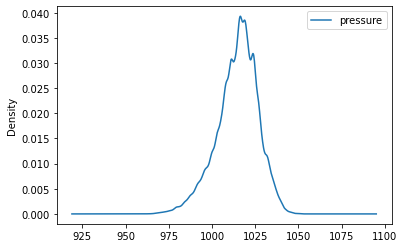

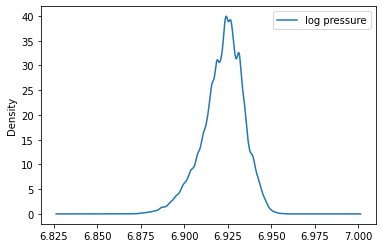

In [ ]:
col_name = 'pressure'
df[col_name].plot(kind = 'density', label=col_name)
plt.legend()
plt.show()

np.log(df[col_name]).plot(kind = 'density', label='log ' + col_name)
plt.legend()
plt.show()

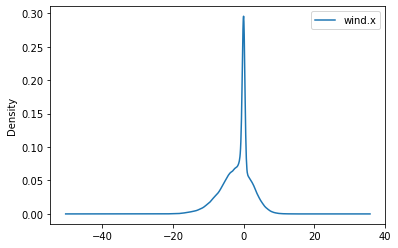

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


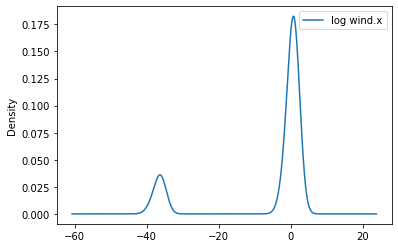

In [ ]:
col_name = 'wind.x'
df.loc[(df['missing'] == 0.0) & (df[col_name] != 0.0), col_name].plot(kind = 'density', label=col_name)
plt.legend()
plt.show()

np.log(df.loc[(df['missing'] == 0.0) & (df[col_name] != 0.0), col_name]).plot(kind = 'density', label='log ' + col_name)
plt.legend()
plt.show()

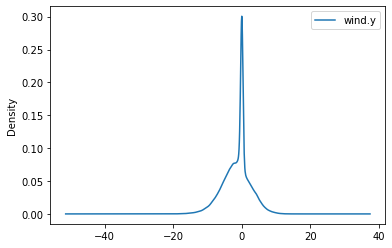

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


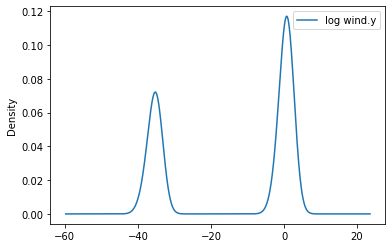

In [ ]:
col_name = 'wind.y'
df.loc[(df['missing'] == 0.0) & (df[col_name] != 0.0), col_name].plot(kind = 'density', label=col_name)
plt.legend()
plt.show()

np.log(df.loc[(df['missing'] == 0.0) & (df[col_name] != 0.0), col_name]).plot(kind = 'density', label='log ' + col_name)
plt.legend()
plt.show()

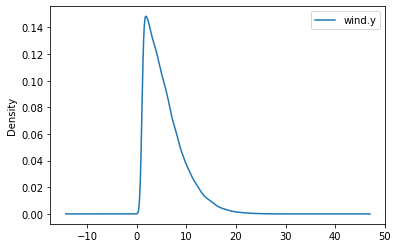

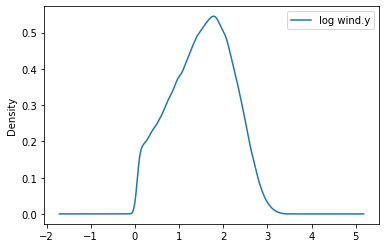

In [ ]:
col_name = 'wind.speed.mean'

col_name = 'wind.y'
wv[wv > 1].plot(kind = 'density', label=col_name)
plt.legend()
plt.show()

np.log(wv[wv > 1]).plot(kind = 'density', label='log ' + col_name)
plt.legend()
plt.show()

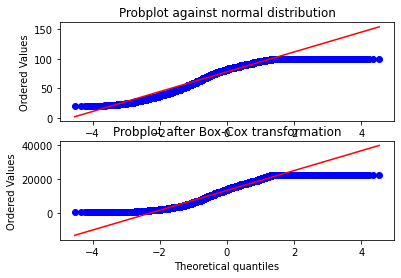

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
x = df.loc[df['missing'] == 0.0, 'humidity']
#x = df['humidity']
prob = stats.probplot(x, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')

ax2 = fig.add_subplot(212)
xt, _ = stats.boxcox(x)
prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')
plt.show()

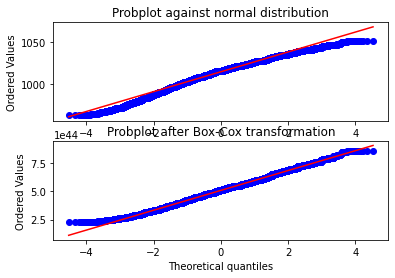

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
# x = df['pressure']
x = df.loc[df['missing'] == 0.0, 'pressure']


prob = stats.probplot(x, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')

ax2 = fig.add_subplot(212)
xt, _ = stats.boxcox(x)
prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')
plt.show()

lambda: 1.1587287557157484


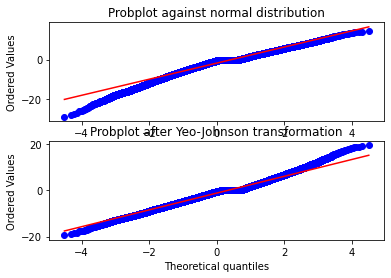

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
# x = df['wind.x']
x = df.loc[(df['missing'] == 0.0) & (df['wind.x'] != 0.0), 'wind.x']
prob = stats.probplot(x, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')

ax2 = fig.add_subplot(212)
xt, lmbda = stats.yeojohnson(x)
print('lambda:', lmbda)
prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Yeo-Johnson transformation')
plt.show()

lambda: 1.079554522877945


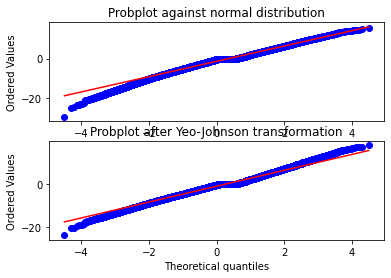

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
# x = df['wind.y']
x = df.loc[(df['missing'] == 0.0) & (df['wind.y'] != 0.0), 'wind.y']
prob = stats.probplot(x, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')

ax2 = fig.add_subplot(212)
xt, lmbda = stats.yeojohnson(x)
print('lambda:', lmbda)
prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Yeo-Johnson transformation')
plt.show()

lambda: 0.35655798736705946


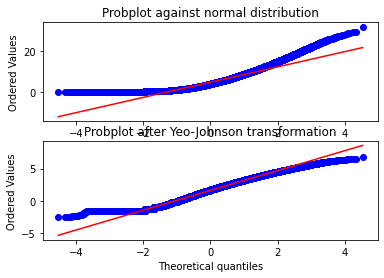

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
# x = df['wind.y']
x = wv[wv > 0.0]
prob = stats.probplot(x, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')

ax2 = fig.add_subplot(212)
xt, lmbda = stats.boxcox(x)
print('lambda:', lmbda)
prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Yeo-Johnson transformation')
plt.show()

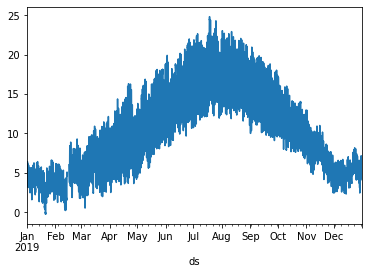

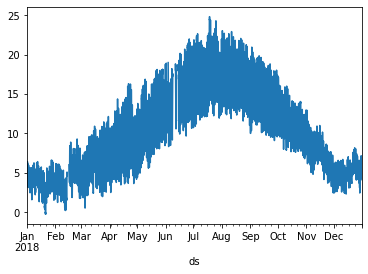

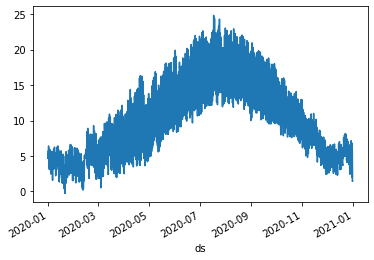

In [ ]:
col_name = 'y_seasonal'

test_df[col_name].plot()
plt.show()

valid_df[col_name].plot()
plt.show()

#train_df['year'] = train_df.index.dt.year
# train_df.loc[(train_df.index > '01-01-2019') & (train_df.index < '01-01-2020'), col_name].plot()
df['year'] = df['ds'].dt.year
df.loc[df.year == 2020, col_name].plot()
plt.show()

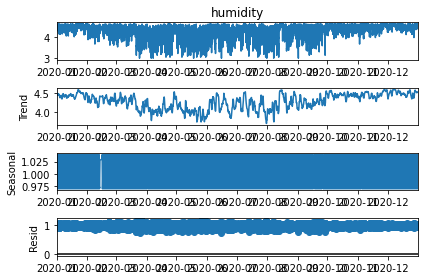

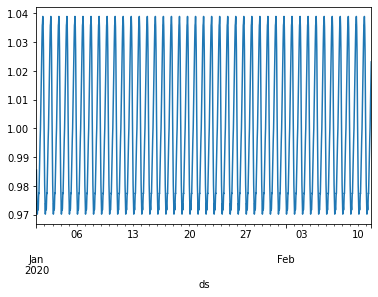

[[1.57783680e+18 8.74075427e+01]
 [1.57783860e+18 8.74051717e+01]
 [1.57784040e+18 8.74028008e+01]
 ...
 [1.60938900e+18 9.07720853e+01]
 [1.60939080e+18 9.07744010e+01]
 [1.60939260e+18 9.07767167e+01]]


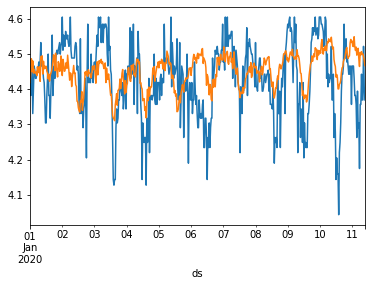

In [ ]:
#dta = sm.datasets.co2.load_pandas().data
## deal with missing values. see issue
#dta.co2.interpolate(inplace=True)

res = sm.tsa.seasonal_decompose(np.log(df.loc[df.year == 2020, 'humidity']), period=48, model='multiplicative', two_sided=True)
res.plot()


fig = plt.figure()
res.seasonal.head(2000).plot()
plt.show()

n = 500
np.log(df.loc[df.year == 2020, 'humidity']).head(n).plot();
np.log(df.loc[df.year == 2020, 'humidity_seasonal']).head(n).plot();

y_l = lowess(df.loc[df.year == 2020, 'humidity_seasonal'], df.loc[df.year == 2020, 'ds'])
print(y_l)
plt.plot(df.loc[df.year == 2020, 'ds'].head(n), np.log(y_l[:n, 1]), 'blue', label='lowess fit')
plt.show()

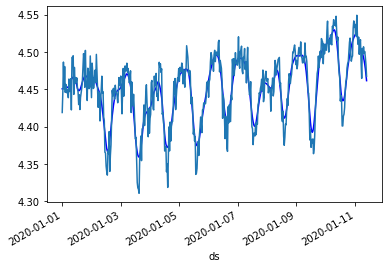

In [ ]:
y_l = lowess(df.loc[df.year == 2020, 'humidity_seasonal'], df.loc[df.year == 2020, 'ds'], frac=20 / 17532)

n = 500
plt.plot(df.loc[df.year == 2020, 'ds'].head(n), np.log(y_l[:n, 1]), 'blue', label='lowess fit')
np.log(df.loc[df.year == 2020, 'humidity_seasonal']).head(n).plot();
plt.show()

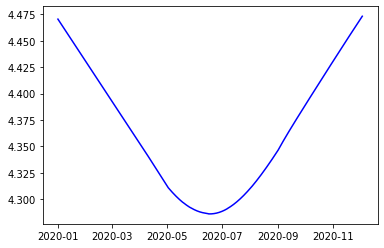

In [ ]:
n = 16000
plt.plot(df.loc[df.year == 2020, 'ds'].head(n), np.log(y_l[:n, 1]), 'blue', label='lowess fit')
plt.show()

...

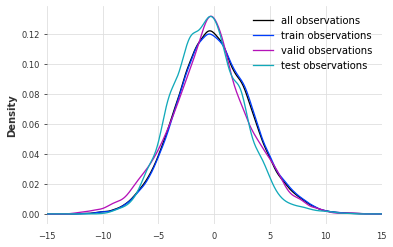

In [ ]:
df['y_des'].plot(kind = 'density', label='all observations')
train_df['y_des'].plot(kind = 'density', label='train observations')
valid_df['y_des'].plot(kind = 'density', label='valid observations')
test_df['y_des'].plot(kind = 'density', label='test observations')
plt.xlim(-15, 15)
plt.legend()
plt.show()

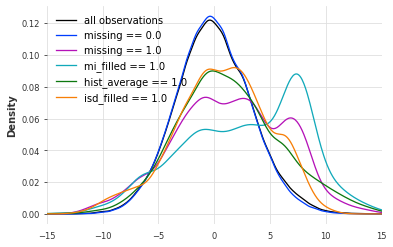

In [ ]:
df['y_des'].plot(kind = 'density', label='all observations')
df.loc[df['missing'] == 0.0, 'y_des'].plot(kind = 'density', label='missing == 0.0')
df.loc[df['missing'] == 1.0, 'y_des'].plot(kind = 'density', label='missing == 1.0')
df.loc[df['mi_filled'] == 1.0, 'y_des'].plot(kind = 'density', label='mi_filled == 1.0')
df.loc[df['hist_average'] == 1.0, 'y_des'].plot(kind = 'density', label='hist_average == 1.0')
df.loc[df['isd_filled'] == 1.0, 'y_des'].plot(kind = 'density', label='isd_filled == 1.0')
plt.xlim(-15, 15)
plt.legend()
plt.show()

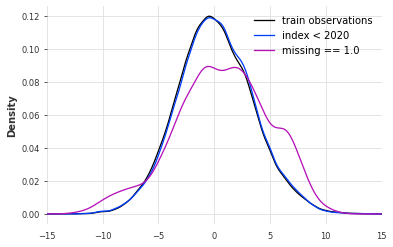

In [ ]:
#df['y_des'].plot(kind = 'density', label='all observations')
#df.loc[df['missing'] == 0.0, 'y_des'].plot(kind = 'density', label='missing == 0.0')
#df.loc[df['missing'] == 1.0, 'y_des'].plot(kind = 'density', label='missing == 1.0')
#df.loc[df['mi_filled'] == 1.0, 'y_des'].plot(kind = 'density', label='mi_filled == 1.0')
#df.loc[df['hist_average'] == 1.0, 'y_des'].plot(kind = 'density', label='hist_average == 1.0')
#df.loc[df['isd_filled'] == 1.0, 'y_des'].plot(kind = 'density', label='isd_filled == 1.0')
train_df['y_des'].plot(kind = 'density', label='train observations')
train_df.loc[train_df.index < '2020', 'y_des'].plot(kind = 'density', label='index < 2020')
train_df.loc[train_df['isd_filled'] == 1.0, 'y_des'].plot(kind = 'density', label='missing == 1.0')
#valid_df['y_des'].plot(kind = 'density', label='valid observations')
#test_df['y_des'].plot(kind = 'density', label='test observations')
plt.xlim(-15, 15)
plt.legend()
plt.show()

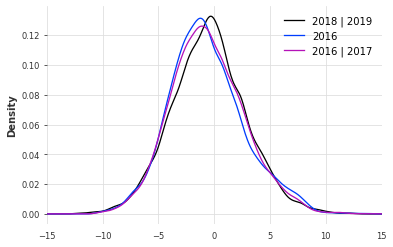

In [ ]:
df['year'] = df['ds'].dt.year

#valid_df['y_des'].plot(kind = 'density', label='valid observations')
#test_df['y_des'].plot(kind = 'density', label='test observations')
#train_df['y_des'].plot(kind = 'density', label='train observations')
# year = '2020'
# train_df.loc[year, 'y_des'].plot(kind = 'density', label=year)
#train_df.loc[(train_df.index == '2016') | (train_df.index == '2017'), 'y_des'].plot(kind = 'density', label=year)
df.loc[(df['year'] == 2018) | (df['year'] == 2019), 'y_des'].plot(kind = 'density', label='2018 | 2019')
df.loc[df['year'] == 2016, 'y_des'].plot(kind = 'density', label='2016')
#df.loc[df['year'] == 2017, 'y_des'].plot(kind = 'density', label='2017')
year = 2008
#df.loc[df['year'] == year, 'y_des'].plot(kind = 'density', label=year)
df.loc[(df['year'] == 2016) | (df['year'] == 2017), 'y_des'].plot(kind = 'density', label='2016 | 2017')
plt.xlim(-15, 15)
plt.legend()
plt.show()

(1000, 2)

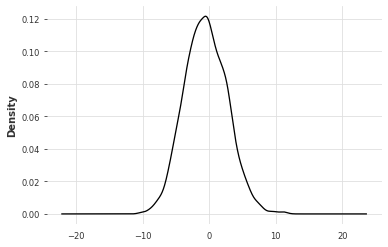

In [ ]:
df.loc[df['year'] == 2017, 'y_des'].plot.kde().get_lines()[0].get_xydata().shape


...

---

Now, load the rolling window tsfresh features and merge with existing data: 


In [ ]:
def read_and_merge_tsfresh_features(df, ds, window=HORIZON):
    fn = 'tsfresh_' + str(window) + 'ish_' + ds + '.2022.09.20.csv.xz'

    if 'google.colab' in str(get_ipython()):
        tsf_url = 'https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/data/' + fn + '?raw=true'
    else:
        tsf_url = '../data/' + fn

    tsf = pd.read_csv(tsf_url, compression='xz', parse_dates=['ds'])


    # print("\n", ds)
    # print("tsf:", tsf.shape)
    tsf.set_index('ds', drop=False, inplace=True)
    tsf = tsf[~tsf.index.duplicated(keep='first')]
    tsf = tsf.asfreq(freq='30min')

    print("\n", ds)
    print("tsf:", tsf.shape)
    print("df: ", df.shape)

    df = pd.merge(df, tsf, left_index=True, right_index=True)

    df.set_index('ds', drop=True, inplace=True)
    df = df[~df.index.duplicated(keep='first')]
    df = df.asfreq(freq='30min')
    print("merged df:", df.shape)

    return df


if TSFRESH:
    train_df = read_and_merge_tsfresh_features(train_df, 'train')
    valid_df = read_and_merge_tsfresh_features(valid_df, 'valid')
    test_df  = read_and_merge_tsfresh_features(test_df,  'test')

Ultimately, the tsfresh features did not prove useful.  I leave the tsfresh import code here for possible future experiments.

---

### Normalise data

Features do not need to be scaled for gradient boosting methods. Nonetheless, it can often be a
useful sanity check.

The [violin plot](https://en.wikipedia.org/wiki/Violin_plot) shows the distribution of features.

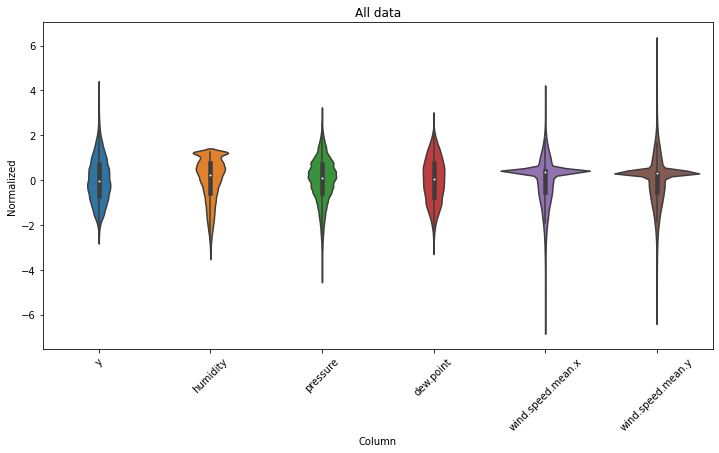

In [ ]:
def inv_transform(scaler, data, colName, colNames):
    """An inverse scaler for use in model validation section

    For later use in plot_forecasts, plot_horizon_metrics and check_residuals
    
    See https://stackoverflow.com/a/62170887/100129"""

    dummy = pd.DataFrame(np.zeros((len(data), len(colNames))), columns=colNames)
    dummy[colName] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
    
    return dummy[colName].values


cols = ['y', 'humidity', 'pressure', 'dew.point', 'wind.speed.mean.x', 
        'wind.speed.mean.y']
train_df_norm = train_df.loc[:, cols]
scaler = StandardScaler()
scaler.fit(train_df_norm)

train_df_norm = scaler.transform(train_df_norm)
# valid_df[valid_df.columns] = scaler.transform(valid_df[valid_df.columns] )
# test_df[test_df.columns]   = scaler.transform(test_df[test_df.columns] )

#df_std = scaler.transform(df)
df_std = pd.DataFrame(train_df_norm)
df_std = df_std.melt(var_name = 'Column', value_name = 'Normalized')

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x = 'Column', y = 'Normalized', data = df_std)
ax.set_xticklabels(cols, rotation = 45)
ax.set_title('All data');

Some features have long tails but there are no glaring errors.


---

## Gradient Boosted Model Building

[Gradient boosted models](https://en.wikipedia.org/wiki/Gradient_boosting)  train an ensemble of weak prediction models, which are usually decision trees.  The ensemble model is iteratively built from weak learners and are added to produce a final strong learner.
Successive weak learners focus more on the examples that previous weak learners got wrong.  Historically, gradient boosted models have performed well in the [Kaggle](https://www.kaggle.com/) competitions.  The majority of [M5 forecasting accuracy competition entries used gradient boosted trees](https://www.sciencedirect.com/science/article/pii/S0169207021001874), specifically lightGBM.  See also, [Forecasting with trees](https://www.sciencedirect.com/science/article/pii/S0169207021001679) for more on the M5 competition and the dominance of boosted tree methods.  However, tree-based models may be unable to learn a trend and forecast outside the bounds of the training data.  This should not be a big problem with this cyclical data set.

Even simple lag-based feature engineering for [multi-variate time series multi-step forecasting](https://machinelearningmastery.com/how-to-develop-machine-learning-models-for-multivariate-multi-step-air-pollution-time-series-forecasting/) requires a considerable amount of effort, so a time series framework is beneficial.
I had hoped to use the [skforecast](https://joaquinamatrodrigo.github.io/skforecast/) framework.  Unfortunately, as of the current version (0.5.0) it does not support forecasts with multivariate data.  

The [sktime](https://www.sktime.org/en/stable/index.html) package supports boosting methods via their sklearn compatible [make_reduction](https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.forecasting.compose.make_reduction.html) function.  Initially it gave very poor results for the boosting methods I tried and the `make_reduction` function seemed to be somewhat of a second class option.  In it's defence, it has built in support for [tsfresh](https://www.sktime.org/en/latest/api_reference/auto_generated/sktime.transformations.panel.tsfresh.TSFreshFeatureExtractor.html) and [catch22](https://www.sktime.org/en/latest/api_reference/auto_generated/sktime.transformations.panel.catch22.Catch22.html) feature extraction plus [conformal interval](https://www.sktime.org/en/latest/api_reference/auto_generated/sktime.forecasting.conformal.ConformalIntervals.html) functionality among many other interesting features.

The [darts](https://unit8co.github.io/darts/) package is focused on time series forecasting but can also be used for filtering.

darts time series package:
  * pros
    * supports multi-variate data
    * allows custom lag selection
    * future covariates which many of the other time series packages do not support
  * cons
    * no integrated xgboost support but can use sklearn compatible [RegressionModel](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.regression_model.html)
    * random forest (from sklearn) implementation is slow
    * deep learning models *currently* don't install on google colab

The following are a few points I consider when building these gradient boosted models.

Forecast horizons:
  * next 24 hours - 48 30 min steps ahead

Metrics:
 * mse - mean squared error
   * mse used for loss function to avoid potential problems with infinite values from the square root function
   * rmse - root mean squared error is used for comparison with baselines
   * Huber loss may be worth exploring in the future if outliers remain an issue
 * mae - median absolute error
 * mape - mean absolute percentage error 
   * Not used - mape fails when values, like temperature, become zero



Parameters to consider optimising:
 * lags
 * exogenous variables
   * time component representations
     * sinusoidal
     * [periodic spline features](https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#periodic-spline-features)
  * [tsfresh](https://tsfresh.readthedocs.io/en/latest/) feature extraction
 * hyperparameters
```
param_grid = {
    'n_estimators':  [100, 500],
    'max_depth':     [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }
```


Models considered:
   
 1. [darts lightgbm](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.gradient_boosted_model.html)
   * [lightgbm](https://lightgbm.readthedocs.io/)
   * from Microsoft
   * annecdotally, seems quite speedy
   * feature selection
     * using Boruta-style shadow variables
   * lag selection
     1. grid search across `lags` and `lags_past_covariates`
     2. lag addition for target `lags` holding `lags_past_covariates` constant
     3. lag elimination for `lags_past_covariates` holding `lags` constant

 2. [darts catboost](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.catboost_model.html)
   * [catboost](https://catboost.ai/)
   * from Yandex
   * annecdotally, seems more accurate on this data set
   * lag selection
     * starting with some of the best lightgbm lag selection options
   * hyperparameter optimisation
     * grid search

 3. [darts rf](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.random_forest.html)
   * unfortunately this was too slow
     * I stopped the process when eta exceeded 2 hours for a single small model
     * I removed this work from the notebook for brevity


---


Start by loading the required darts imports:

In [ ]:
from darts.models.forecasting.catboost_model import CatBoostModel
from darts.models.forecasting.lgbm import LightGBMModel

from darts import TimeSeries
from darts.metrics import rmse, mae

Next, some utility functions:
 * `rmse_`
 * `mse_`
 * `mae_`
 * `expand_grid`
 * `calculate_historic_comparison`
 * `summarise_hist_comp`
 * `calculate_rmse_mae_from_backtest`
 * `get_most_important_variables`
 * `plot_importances`
 * `plot_obs_vs_preds`
 * `plot_obs_vs_mean_preds_by_step`
 * `plot_obs_preds_dists`
 * `plot_residuals`
 * `plot_residuals_vs_predicted` - unused?
 * `plot_residuals_dist`
 * `plot_horizon_metrics`
 * `plot_forecast_examples`
 * `plot_learning_curve`


In [ ]:
def _check_obs_preds_lens_eq(obs, preds):
    obs_preds_lens_eq = 1

    if len(obs) != len(preds):
        print("obs:  ", len(obs))
        print("preds:", len(preds))
        obs_preds_lens_eq = 0

    return obs_preds_lens_eq


def rmse_(obs, preds):
    if _check_obs_preds_lens_eq(obs, preds) == 0:
        stop()
    else:
        return np.sqrt(np.mean((obs - preds) ** 2))


def mse_(obs, preds):
    if _check_obs_preds_lens_eq(obs, preds) == 0:
        stop()
    else:
        return np.mean((obs - preds) ** 2)


def mae_(obs, preds):
    "mean absolute error - equivalent to the keras loss function"
    if _check_obs_preds_lens_eq(obs, preds) == 0:
        stop()
    else:
        return np.mean(np.abs(obs - preds))      # keras loss
        # return np.median(np.abs(obs - preds))  # earlier baselines


def summarise_backtest(backtest, df, horizon = HORIZON, digits = 6, y_col = Y_COL):

    if len(backtest[0]) == 1:
        print("\n# Backtest RMSE:", round(rmse_(val_ser[-len(backtest):].values(), backtest.values()), digits))
        print("# Backtest MAE: ",   round( mae_(val_ser[-len(backtest):].values(), backtest.values()), digits))
        
        print("\nbacktest[", y_col, "]:\n", sep='')
        backtest_stats = stats.describe(backtest[y_col].values())
        print("count\t", backtest_stats[0])
        print("mean\t",  round(backtest_stats[2][0], digits))
        print("std\t",   round(np.sqrt(backtest_stats[3][0]), digits))
        print("min\t",   round(np.min(backtest_stats[1]), digits))
        print("25%\t",   round(np.percentile(backtest[y_col].values(), 25), digits))
        print("50%\t",   round(np.median(backtest[y_col].values()), digits))
        print("75%\t",   round(np.percentile(backtest[y_col].values(), 75), digits))
        print("max\t",   round(np.max(backtest_stats[1]), digits))
    elif len(backtest[0]) == horizon:
        preds_df = pd.concat([backtest[i].pd_dataframe() for i in range(len(backtest))], axis=0)
        trues_df = df.loc[preds_df.index, [y_col]]
        hist_comp = pd.concat([trues_df, preds_df[y_col]], axis = 1)
        hist_comp.columns = [y_col, 'pred']
        list_int = [i for i in range(1, horizon + 1)]
        reps = len(hist_comp) // len(list_int)
        hist_comp['step'] = np.tile(list_int, reps)

        print("\nBacktest RMSE all:", round(rmse_(hist_comp[y_col], hist_comp['pred']), digits))
        print("Backtest MAE all: ",    round(mae_(hist_comp[y_col], hist_comp['pred']), digits))

        print("\n# Backtest RMSE 48th:", round(rmse_(hist_comp.loc[hist_comp['step'] == horizon, y_col], \
                                                     hist_comp.loc[hist_comp['step'] == horizon, 'pred']), digits))
        print("# Backtest MAE 48th: ",    round(mae_(hist_comp.loc[hist_comp['step'] == horizon, y_col], \
                                                     hist_comp.loc[hist_comp['step'] == horizon, 'pred']), digits))

        lasttest_stats = stats.describe(hist_comp['pred'])
        print("\nbacktest[", y_col, "]:\n", sep='')
        print("count\t", len(hist_comp['pred']))
        print("mean\t",  round(lasttest_stats[2], digits))
        print("std\t",   round(np.sqrt(lasttest_stats[3]), digits))
        print("min\t",   round(np.min(lasttest_stats[1]), digits))
        print("25%\t",   round(np.percentile(hist_comp['pred'], 25), digits))
        print("50%\t",   round(np.median(hist_comp['pred']), digits))
        print("75%\t",   round(np.percentile(hist_comp['pred'], 75), digits))
        print("max\t",   round(np.max(lasttest_stats[1]), digits))


def print_rmse_mae(obs, preds, postfix_str, prefix_str = '', digits = 6):
    print(prefix_str, "Backtest RMSE ", postfix_str, ": ",  
          round(rmse_(obs, preds), digits),
          sep='')
    print(prefix_str, "Backtest MAE ",  postfix_str, ":  ", 
          round( mae_(obs, preds), digits),
          sep='')
    print()


def summarise_hist_comp(hc, df, horizon = HORIZON, digits = 6, y_col = Y_COL):

    print('\n')
    print_rmse_mae(hc[y_col], hc['pred'], 'all')

    obs   = hc.loc[hc['step'] == horizon, y_col]
    preds = hc.loc[hc['step'] == horizon, 'pred']
    print_rmse_mae(obs, preds, '48th', '# ')

    obs   = hc.loc[hc['missing'] == 0.0, y_col]
    preds = hc.loc[hc['missing'] == 0.0, 'pred']
    print_rmse_mae(obs, preds, 'miss==0')

    obs   = hc.loc[hc['missing'] == 1.0, y_col]
    preds = hc.loc[hc['missing'] == 1.0, 'pred']
    print_rmse_mae(obs, preds, 'miss==1')

    if y_col == 'y_des':
      # preds = hc['pred'] - hc['y_seasonal']
      preds = hc['pred'] - hc['y_yearly'] - hc['y_daily'] - hc['y_trend']
    elif y_col:
      preds = hc['pred'] - hc['y_yearly'] - hc['y_daily']

    preds.dropna(inplace=True)
    lasttest_stats = stats.describe(preds)
    print("\nbacktest['", y_col, "']:", sep='')
    print("count\t", len(preds))
    print("mean\t",  round(lasttest_stats[2], digits))
    print("std\t",   round(np.sqrt(lasttest_stats[3]), digits))
    print("min\t",   round(np.min(lasttest_stats[1]), digits))
    print("25%\t",   round(np.percentile(preds, 25), digits))
    print("50%\t",   round(np.median(preds), digits))
    print("75%\t",   round(np.percentile(preds, 75), digits))
    print("max\t",   round(np.max(lasttest_stats[1]), digits))


def get_most_important_variables(model, data, cutoff, y_col=Y_COL, exclude_cols=['y', 'y_seasonal', 'y_des']):
    include_cols = None

    col_indices = np.argsort(model.model.feature_importances_)

    if include_cols is not None:
        col_names = pd.Series(include_cols)
    else:
        col_names = pd.Series(data.columns.difference(exclude_cols))

    col_names = pd.concat([pd.Series([y_col]), col_names])
    col_names = col_names.reset_index(drop=True)

    importances = sorted(model.model.feature_importances_)
    importances = [i for i in importances if i >= cutoff]

    inc_cols = col_names[col_indices]
    inc_cols = inc_cols[-len(importances):]
    inc_cols = pd.DataFrame(inc_cols, columns=['feature'])
    inc_cols['importance'] = np.array(importances)
    print("inc_cols:", inc_cols, sep='\n')

    return inc_cols


def plot_importances(model, \
                     data,  \
                     include_cols = None,  \
                     y_col        = Y_COL, \
                     exclude_cols = ['y', 'y_seasonal', 'y_des', 'dew.point_des', 'dew.point_seasonal']):
    '''Plot feature importances from lightGBM models

    WARNING: Only works with lags = 1 and lags_past_cov = 1
    '''

    imp_thresh = 0
    if isinstance(model, CatBoostModel):
      imp_thresh = 0
    elif isinstance(model, LightGBMModel):
      imp_thresh = 1

    col_indices = np.argsort(model.model.feature_importances_)
    # print(model.model.feature_importances_[col_indices])

    if include_cols is not None:
        col_names = pd.Series(include_cols)
    else:
        col_names = pd.Series(data.columns.difference(exclude_cols))

    col_names = pd.concat([pd.Series([y_col]), col_names])
    col_names = col_names.reset_index(drop=True)
    col_names = pd.DataFrame(col_names)
    col_names.columns = ['feature']
    # print("col_names:\n", col_names.iloc[col_indices, :])

    importances = sorted(model.model.feature_importances_)
    importances = [i for i in importances if i >= imp_thresh]
    # print("importances:", importances, sep="\n")
    # print("col_indices:", col_indices, sep="\n")
    # print("col_names:", col_names, sep="\n")

    cols = col_names.loc[col_indices]
    cols = cols[-len(importances):]
    cols['importance'] = importances
    # print("cols:", cols, sep='\n')

    plt.figure(figsize=(20, 10))
    plt.barh(width  = cols['importance'], 
             y      = cols['feature'],
             height = 0.25);
    plt.barh(width  = cols.loc[cols['feature'].str.contains('shadow'), 'importance'], 
             y      = cols.loc[cols['feature'].str.contains('shadow'), 'feature'],
             height = 0.25,
             color    = 'red')
    plt.show()


def expand_grid(dictionary):
   return pd.DataFrame([row for row in product(*dictionary.values())], 
                       columns = dictionary.keys())


def keep_key(d, k):
  """ models = keep_key(models, 'datasets') """
  return {k: d[k]}


def calculate_historic_comparison(backtest, df, horizon = HORIZON):
    assert len(backtest[0]) > 1

    if Y_COL == 'y_des':
      # cols = ['y_des', 'y_seasonal']
      cols = ['y_des', 'y_yearly', 'y_daily', 'y_trend']
    elif Y_COL == 'y_res':
      cols = ['y_res', 'y_yearly', 'y_daily']

    cols.extend(['missing', 'mi_filled', 'isd_outlier', 'hist_average'])

    preds_df = pd.concat([backtest[i].pd_dataframe() for i in range(len(backtest))], axis=0)
    trues_df = df.loc[preds_df.index, cols]

    hist_comp = pd.concat([trues_df, preds_df[Y_COL]], axis = 1)
    cols.append('pred')
    hist_comp.columns = cols

    # re-seasonalise
    if Y_COL == 'y_des':
      hist_comp['y_des'] += hist_comp['y_yearly'] + hist_comp['y_daily'] + hist_comp['y_trend']
      hist_comp['pred']  += hist_comp['y_yearly'] + hist_comp['y_daily'] + hist_comp['y_trend']
    elif Y_COL == 'y_res':
      hist_comp['y_res'] += hist_comp['y_yearly'] + hist_comp['y_daily']
      hist_comp['pred']  += hist_comp['y_yearly'] + hist_comp['y_daily']

    hist_comp['res']    = hist_comp[Y_COL] - hist_comp['pred']
    hist_comp['res^2']  = hist_comp['res'] * hist_comp['res']
    hist_comp['res_sign']  = np.sign(hist_comp['res'])
    hist_comp['missing']   = hist_comp['missing']#.astype(int)
    hist_comp['mi_filled'] = hist_comp['mi_filled']#.astype(int)
    hist_comp['hist_average'] = hist_comp['hist_average']#.astype(int)

    list_int = [i for i in range(1, horizon+1)]
    reps = len(hist_comp) // len(list_int)
    hist_comp['step'] = np.tile(list_int, reps)
    hist_comp['id']   = np.repeat([i for i in range(reps)], horizon)
    hist_comp['date'] = hist_comp.index.values

    return hist_comp


def _plot_xy_for_label(data, label, x_feat, y_feat, color):
    x = data.loc[data[label] == 1.0, x_feat]
    y = data.loc[data[label] == 1.0, y_feat]

    if len(x) > 0:
        plt.scatter(x = x, y = y, color=color, alpha=0.5, label=label)


def plot_obs_vs_preds(hist, title):
    plt.figure(figsize = (12, 16))
    plt.subplot(5, 1, 1)
    plt.scatter(x = hist[Y_COL], y = hist['pred'])
    _plot_xy_for_label(hist, 'missing',      Y_COL, 'pred', 'red')
    # _plot_xy_for_label(hist, 'hist_average', Y_COL, 'pred', 'yellow')
    # _plot_xy_for_label(hist, 'mi_filled',    Y_COL, 'pred', 'purple')
    plt.axline((0, 0), slope=1.0, color="grey")
    plt.xlabel('Observations')
    plt.ylabel('Predictions')
    plt.legend(loc='lower right')
    obs   = hist.loc[hist[[Y_COL, 'pred']].notnull().all(1), Y_COL]
    preds = hist.loc[hist[[Y_COL, 'pred']].notnull().all(1), 'pred']
    r2score = r2_score(obs, preds)
    plt.annotate("$R^2$ = {:.3f}".format(r2score), (-9, 31))
    plt.title(title)
    plt.xlim((-10, 35))
    plt.ylim((-10, 35))
    plt.show()


def plot_obs_vs_mean_preds_by_step(hist, title, step_ = HORIZON, ci = False):
    '''For specific step, plot mean prediction for each observation
    
    A 95 % confidence interval is plotted, but can be disabled
    '''

    mean_preds = hist_comp.loc[hist_comp['step'] == step_, [Y_COL, 'pred']].groupby(Y_COL).mean('pred')
    obs   = mean_preds.index.values
    preds = mean_preds['pred'].values

    plt.figure(figsize = (12, 16))
    ax = plt.subplot(5, 1, 2)
    plt.plot(obs, preds)

    if ci is True:
      ci = 1.96 * np.std(preds) / np.sqrt(len(obs))
      # print(ci)
      ax.fill_between(obs, (preds - ci), (preds + ci), color='b', alpha=.1)
    
    plt.axline((0, 0), slope=1.0, color="grey")
    r2score = r2_score(obs, preds)
    plt.annotate("$R^2$ = {:.3f} - step = {}".format(r2score, step_), (-9, 31))
    plt.title(title + 'step = ' + str(step_))
    plt.xlabel('Temperature')
    plt.ylabel('Mean prediction')
    plt.xlim((-10, 35))
    plt.ylim((-10, 35))
    plt.show()


def plot_obs_preds_dists(hist, title):
    obs   = hist.loc[hist[[Y_COL, 'pred']].notnull().all(1), Y_COL]
    preds = hist.loc[hist[[Y_COL, 'pred']].notnull().all(1), 'pred']
    r2score = r2_score(obs, preds)
    plt.figure(figsize = (12, 16))
    plt.subplot(5, 1, 3)
    pd.Series(obs).plot(kind = 'density', label='observations')
    pd.Series(preds).plot(kind = 'density', label='predictions')
    plt.xlim(-10, 40) 
    plt.title(title)
    plt.legend()
    plt.annotate("$R^2$ = {:.3f}".format(r2score), (-7.5, 0.055))
    #plt.tight_layout()
    plt.show()


def plot_residuals(hist, title):
    plt.figure(figsize = (12, 16))
    plt.subplot(5, 1, 4)
    plt.scatter(x = range(len(hist)), y = hist['res'])
    hist['id.2'] = range(len(hist))
    _plot_xy_for_label(hist, 'missing',      'id.2', 'res', 'red')
    # _plot_xy_for_label(hist, 'hist_average', 'id.2', 'res', 'yellow')
    # _plot_xy_for_label(hist, 'mi_filled',    'id.2', 'res', 'purple')
    plt.axhline(y = 0, color = 'grey')
    plt.xlabel('Index position')
    plt.ylabel('Residuals')
    plt.legend(loc='lower right')
    plt.title(title)
    plt.show()


def plot_residuals_dist(hist, title):
    plt.figure(figsize = (12, 16))
    plt.subplot(5, 1, 5)
    pd.Series(hist['res']).plot(kind = 'density', label='residuals')
    plt.xlim(-10, 10)
    plt.title(title)
    plt.show()


# Unused?
# TODO Diagonal structure of these plots might need further consideration
#      Add lowess fit to check for problems
def plot_residuals_vs_predicted(hist, title):
    plt.subplot(5, 1, 5)
    plt.scatter(x = hist['pred'], y = hist['res'])
    _plot_xy_for_label(hist, 'missing',      'pred', 'res', 'red')
    # _plot_xy_for_label(hist, 'hist_average', 'pred', 'res', 'yellow')
    # _plot_xy_for_label(hist, 'mi_filled',    'pred', 'res', 'purple')
    plt.axhline(y = 0, color = 'grey')

    n = 24  # slow to run all points :-(
            # 12 takes approx 2 mins to run
            #  8 takes approx 4 mins to run
    xy = hist.iloc[::n, :]
    # x = hist.iloc[::n, :]
    y_l = lowess(xy['res'], xy['pred'])
    plt.plot(y_l[:, 0], y_l[:, 1], 'green', label='lowess fit')

    plt.xlabel('Predictions')
    plt.ylabel('Residuals')
    plt.legend(loc='upper right')
    plt.title(title);


def plot_horizon_metrics(hist, title, horizon = HORIZON):
    steps = [i for i in range(1, horizon+1)]

    # calculate metrics
    rmse_h, mae_h, ci_h = np.zeros(horizon), np.zeros(horizon), np.zeros(horizon)

    for i in range(1, horizon+1):
      obs   = hist.loc[hist['step'] == i, Y_COL]
      preds = hist.loc[hist['step'] == i, 'pred']
      rmse_h[i-1] = rmse_(obs, preds)
      mae_h[i-1]  =  mae_(obs, preds)
      # mae_h[i]  = np.median(np.abs(obs - preds))  # for comparison with baselines

    # plot metrics for horizons
    fig, axs = plt.subplots(1, 2, figsize = (14, 7))
    fig.suptitle(title + ' forecast horizon errors')
    axs = axs.ravel()

    mean_val_lab = title + ' mean value'
    axs[0].plot(steps, rmse_h, color='blue', label=title)
    var_rmse = np.array([0.39, 0.52, 0.64, 0.75, 0.86, 0.96, 1.06, 1.15, 1.23, 
                         1.31, 1.38, 1.45, 1.51, 1.57, 1.63, 1.68, 1.73, 1.77, 
                         1.81, 1.85, 1.89, 1.92, 1.96, 1.99, 2.02, 2.05, 2.08, 
                         2.1 , 2.13, 2.15, 2.18, 2.2 , 2.22, 2.24, 2.26, 2.28, 
                         2.3 , 2.31, 2.33, 2.35, 2.36, 2.38, 2.39, 2.4 , 2.42, 
                         2.43, 2.44, 2.45])
    axs[0].plot(steps, var_rmse, color='black', label='VAR')
    axs[0].hlines(np.mean(rmse_h), xmin=1, xmax=horizon, 
                  color='blue', linestyles='dotted', label=mean_val_lab)
    axs[0].hlines(np.mean(var_rmse), xmin=1, xmax=horizon, 
                  color='black', linestyles='dotted', label='VAR mean value')
    axs[0].set_xlabel("horizon - half hour steps")
    axs[0].set_ylabel("rmse")

    axs[1].plot(steps, mae_h, color='blue', label=title)
    var_mae = np.array([0.39, 0.49, 0.57, 0.66, 0.74, 0.83, 0.91, 0.98, 1.05, 
                        1.12, 1.18, 1.24, 1.29, 1.34, 1.39, 1.43, 1.47, 1.5 , 
                        1.53, 1.56, 1.59, 1.62, 1.64, 1.66, 1.68, 1.7 , 1.72, 
                        1.73, 1.75, 1.76, 1.77, 1.78, 1.8 , 1.81, 1.82, 1.83, 
                        1.83, 1.84, 1.85, 1.85, 1.86, 1.86, 1.87, 1.87, 1.88, 
                        1.88, 1.89, 1.89])
    axs[1].plot(steps, var_mae, color='black', label='VAR')
    axs[1].hlines(np.mean(mae_h), xmin=1, xmax=horizon, 
                  color='blue', linestyles='dotted', label=mean_val_lab)
    axs[1].hlines(np.mean(var_mae), xmin=1, xmax=horizon, 
                  color='black', linestyles='dotted', label='VAR mean value')
    axs[1].set_xlabel("horizon - half hour steps")
    axs[1].set_ylabel("mae")

    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
    plt.show()


# TODO Refactor this
#      miss, preds, obs, res, err, dates etc "family" of variables
#      is a warning sign
#      try-catch around lagged_miss is clear indication of upsteam issues
#      Consider using a better data structure
#      See also: plot_forecast_examples immediately below
def _filter_out_missing(pos_neg_rmse_all, miss, lags, subplots):
    '''Check if obs (lags and horizon) missing == 1.0
    and
    Avoid contiguous indices'''

    # print("pos_neg_rmse_all:", pos_neg_rmse_all)

    pos_neg_rmse = pd.Series(subplots)
    subplot_count = j = 0

    while subplot_count < subplots:
      restart = False
      idx = pos_neg_rmse_all.index[j]
      # print(j, idx, pos_neg_rmse_all.loc[pos_neg_rmse_all.index[j]])

      # Avoid indices in the first few observations
      # Would be incomplete
      if idx < lags:
        # print('idx < lags:', idx)
        j += 1
        continue

      # Avoid contiguous indices - don't want 877, 878, 879
      if subplot_count > 0:
        for i in range(subplot_count):
          if abs(idx - pos_neg_rmse[i]) < lags:
            # print('contiguous indices - idx, pos_neg_rmse[i]:', idx, pos_neg_rmse[i])
            restart = True
            break

      if restart == False:
        try:
            lagged_miss = (miss.loc[idx - lags, :] == 1.0).any()
        except KeyError:
            lagged_miss = True

        horizon_miss = (miss.loc[idx, :] == 1.0).any()
        missing = lagged_miss or horizon_miss
        # print("\nlagged_miss:", lagged_miss)
        # print("horizon_miss:",  horizon_miss)
        # print("missing:", missing)

        # if not missing:
        if missing == False:
          pos_neg_rmse[subplot_count] = idx
          subplot_count += 1
        #else:
        #  print('missing')

      j += 1

    return pos_neg_rmse


# TODO Refactor this
#      miss, preds, obs, res, err, dates etc "family" of variables
#      is a warning sign
#      Consider using a better data structure
#      See also: _filter_out_missing immediately above
def plot_forecast_examples(hist, title, subplots = 3, horizon = HORIZON, lags = 48):
    """Plot example forecasts with observations and lagged temperatures.
       Ensure examples are non-contiguous.

       First row shows near zero rmse forecasts.
       Second row shows most positive rmse forecasts.
       Third row shows most negative rmse forecasts.

       missing == 0 - ie no imputation for missing data
    """

    assert subplots in [3, 4, 5]

    # hist = hist.dropna()

    col = 'step'
    id_col = 'id'
    miss  = hist.pivot_table(index=id_col, columns=col, values='missing')
    preds = hist.pivot_table(index=id_col, columns=col, values='pred')
    obs   = hist.pivot_table(index=id_col, columns=col, values='y_des')
    res   = hist.pivot_table(index=id_col, columns=col, values='res')
    err   = hist.pivot_table(index=id_col, columns=col, values='res^2')
    dates = hist.pivot_table(index=id_col, columns=col, values='date')

    miss.dropna(inplace=True)
    # print("miss:", miss.shape)
    preds.dropna(inplace=True)
    # print("preds:", preds.shape)
    # obs.dropna(inplace=True)
    # print("obs:", obs.shape)
    res.dropna(inplace=True)
    # print("res:", res.shape)
    err.dropna(inplace=True)
    # print("err:", err.shape)
    dates.dropna(inplace=True)
    # print("dates:", dates.shape)
    dates = dates.iloc[err.index, :]
    # print("dates indexed:", dates.shape)

    # res_sign = np.sign(-res.mean(axis = 1))
    # err_row_means = err.mean(axis = 1)
    # rmse_rows = res_sign * np.sqrt(err_row_means)
    err_row_means = np.sum(err, axis = 1) / horizon
    res_sum = np.sum(res, axis = 1)
    # print("res_sum:",  len(res_sum))
    # print(res_sum[0:5])
    res_sign  = np.sign(np.sum(res, axis = 1))
    rmse_rows = res_sign * np.sqrt(err_row_means)
    # print("rmse_rows:", len(rmse_rows))
    # print("res_sign:",  len(res_sign))
    # print(res_sign[0:5])

    # choose forecasts - check for missing == 0
    # neg_rmse_all = np.argsort(rmse_rows)
    ##pos_rmse_all = np.flip(np.argsort(rmse_rows))
    # pos_rmse_all = np.argsort(-rmse_rows)
    neg_rmse_all = rmse_rows.sort_values()
    # print(rmse_rows.loc[neg_rmse_all.index])
    pos_rmse_all = neg_rmse_all[::-1]
    # print(rmse_rows.loc[pos_rmse_all.index])
    nz_rmse_all  = rmse_rows.abs().sort_values()
    # print(rmse_rows.loc[nz_rmse_all.index])
    # nz_rmse_all  = np.argsort(np.abs(rmse_rows))  # nz near zero
    # print("\nneg_rmse_all:", len(neg_rmse_all))
    # print(rmse_rows[neg_rmse_all[0:5]])
    # print("pos_rmse_all:", len(pos_rmse_all))
    # print(rmse_rows[pos_rmse_all[0:5]])
    # print("nz_rmse_all: ", len(nz_rmse_all))
    # print(rmse_rows[nz_rmse_all[0:5]])

    nz_rmse  = _filter_out_missing(nz_rmse_all,  miss, lags, subplots)
    pos_rmse = _filter_out_missing(pos_rmse_all, miss, lags, subplots)
    neg_rmse = _filter_out_missing(neg_rmse_all, miss, lags, subplots)

    plot_idx = np.concatenate((nz_rmse, pos_rmse, neg_rmse))
    # print("\nplot_idx:", len(plot_idx))
    # print("\nplot_idx:", plot_idx)

    # plot forecasts
    fig, axs = plt.subplots(3, subplots, sharey = True, figsize = (15, 10))
    fig.tight_layout()
    fig.subplots_adjust(hspace = 0.3, top = 0.87)
    axs = axs.ravel()

    myFmt = mdates.DateFormatter('%H:%M')

    for i in range(3 * subplots):
      # print("plot_idx[i] - lags:",plot_idx[i],  plot_idx[i] - lags)
      axs[i].plot(dates.iloc[plot_idx[i] - lags, :],
                  obs.loc[plot_idx[i] - lags, :],
                  'blue',
                  label='lagged observations')

      axs[i].plot(dates.iloc[plot_idx[i], :], 
                  obs.loc[plot_idx[i], :],
                  'green',
                  label='observations')
      
      axs[i].plot(dates.iloc[plot_idx[i], :], 
                  preds.loc[plot_idx[i], :],
                  'orange',
                  label='forecast')
      
      axs[i].xaxis.set_major_formatter(myFmt)
      obs_dates = dates.iloc[plot_idx[i] - lags, :]
      sub_title = "{0}, {1:d}, {2:.3f}".format(obs_dates.iloc[0],
                                               plot_idx[i], 
                                               rmse_rows.loc[plot_idx[i]])
      axs[i].title.set_text(sub_title)
    
    fig.suptitle(title + "\ninit date, period idx, signed rmse")
    fig.text(0.5, 0.04, 'hour', ha='center')
    fig.text(0.04, 0.5, 'Temperature - $^\circ$C', va='center', rotation='vertical')
    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
    plt.show();


# WARN This function probably has too many arguments - consider refactoring
def calculate_rmse_mae_from_backtest(model, param_df, i, series, past_cov, data, prefix, horizon=HORIZON, digits=6):
    backtest = model.historical_forecasts(series = series, 
                                          past_covariates = past_cov,
                                          start   = 0.01, 
                                          retrain = False,
                                          verbose = True, 
                                          forecast_horizon = horizon,
                                          last_points_only = False)   
    hc = calculate_historic_comparison(backtest, data)
    obs   = hc.loc[hc['step'] == horizon, Y_COL]
    preds = hc.loc[hc['step'] == horizon, 'pred']
    param_df.at[i, prefix + '_rmse'] = round(rmse_(obs, preds), digits)
    param_df.at[i, prefix + '_mae']  = round(mae_(obs,  preds), digits)

    return param_df


# TODO Consider merging with plot_lgb_learning_curve directly below
def plot_catboost_learning_curve(model, title = None, metric = 'RMSE', margin = None):
    '''Plot learning curve for catboost model using the lightgbm plot_metric function

    Training and validation curves are plotted when model.fit is called with
    both training and validation data:
    model.fit(series, 
              past_covariates = past_cov,
              val_series = val_ser,
              val_past_covariates = val_past_cov)

    Primarily tested with catboost
    '''

    assert hasattr(model, 'model')
    assert hasattr(model.model, 'evals_result_')

    final_rmse = []

    for k in model.model.evals_result_:
        final_rmse.append(model.model.evals_result_[k][metric][-1])

    if margin is None:
      lgb.plot_metric(model.model.evals_result_)
    else:
      assert margin > 0.0
      y_lim_min = min(final_rmse) - margin
      y_lim_max = max(final_rmse) + margin

      if y_lim_min < 0.0:
        y_lim_min = 0.0

      y_lim = (y_lim_min, y_lim_max)

      lgb.plot_metric(model.model.evals_result_, ylim = y_lim)

    plt.gca().get_lines()[0].set_color('blue')

    labels_ = ['train']
    if len(plt.gca().get_lines()) == 1 and plt.gca().get_label() == 'valid_0':
      labels_ = ['valid']

    if len(plt.gca().get_lines()) > 1:
      plt.gca().get_lines()[1].set_color('orange')
      labels_.append('valid')

    if title is not None:
      plt.title(title)

    plt.legend(labels = labels_)
    plt.show()


# TODO Consider merging with plot_catboost_learning_curve directly above
def plot_lgb_learning_curve(models, title = None, metric = 'l2', margin = None):
    '''Plot learning curve for lightgbm models using the lightgbm plot_metric function

    evals_results_ for validation data missing in action
    So, build 2 models - first with training data for validation
                       - second with validation data for validation
                       - pass both models in as a list
                       - order of models is important

    Training and validation curves are plotted when model.fit is called with
    both training and validation data:
    model.fit(series, 
              past_covariates = past_cov,
              val_series = val_ser,
              val_past_covariates = val_past_cov)

    Primarily tested with catboost
    '''
    
    assert len(models) == 2

    final_rmse = []

    for model in models:
      assert hasattr(model, 'model')
      assert hasattr(model.model, 'evals_result_')

      final_rmse.append(model.model.evals_result_['valid_0'][metric][-1])

    if margin is None:
      lgb.plot_metric(models[0].model.evals_result_)
    else:
      assert margin > 0.0
      y_lim_min = min(final_rmse) - margin
      y_lim_max = max(final_rmse) + margin

      if y_lim_min < 0.0:
        y_lim_min = 0.0

      y_lim = (y_lim_min, y_lim_max)

      lgb.plot_metric(models[0].model.evals_result_, ylim = y_lim)

    plt.plot(models[1].model.evals_result_['valid_0']['l2'])
    plt.gca().get_lines()[0].set_color('blue')

    labels_ = ['train']
    if len(plt.gca().get_lines()) == 1 and plt.gca().get_label() == 'valid_0':
      labels_ = ['valid']

    if len(plt.gca().get_lines()) > 1:
      plt.gca().get_lines()[1].set_color('orange')
      labels_.append('valid')

    if title is not None:
      plt.title(title)

    plt.legend(labels = labels_)
    plt.show()


### 1. darts lightgbm


It is unrealistic to concurrently optimise all of the time series gradient boosting components on google colab.  So, an iterative process is necessary.


There are 2 major components to optimise:
 * feature selection
   * time component features
     * sinusoidal
     * spline-based
   * tsfresh features
 * lag selection
   * target series lags
   * past covariate (feature) lags
   * future covariate (time component) lags (which can include both past and future lags)


#### Feature selection


Both lightgbm and catboost provide feature importance measures.  They are most easily interpreted when lag = 1 for past covariates.  So, I use the lightgbm feature importance for feature selection at lag = 1 for both the target series and past covariates.  I tested including future covariates but they did not prove useful with lightgbm.

[Boruta](https://www.jstatsoft.org/article/view/v036i11)-style shadow variables are used for feature selection.  Shadow variables find relevant features by comparing original variables importance with the importance from randomly permuted copies of variables aka shadows.  All variables with importance values below the shadow feature importances can be safely rejected.
Anecdotally, features with importance values above but close to the shadow variable importances should also be considered for rejection.  This might suggest that lightgbm feature importance is slightly inflated.  This has been informally noted [elsewhere](https://towardsdatascience.com/boruta-and-shap-for-better-feature-selection-20ea97595f4a).

/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')
/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


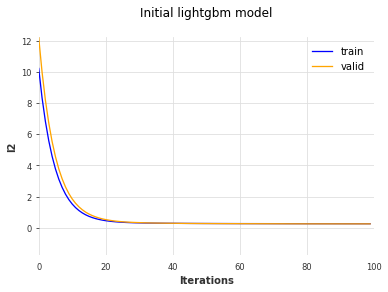

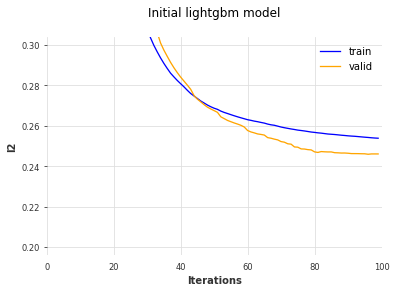

100%|██████████| 17263/17263 [19:09<00:00, 15.02it/s]




Backtest RMSE all: 1.987439
Backtest MAE all:  1.455371

# Backtest RMSE 48th: 2.200046
# Backtest MAE 48th:  1.68561

Backtest RMSE miss==0: 1.977445
Backtest MAE miss==0:  1.449379

Backtest RMSE miss==1: 2.864994
Backtest MAE miss==1:  2.099207


backtest['y_des']:
count	 801696
mean	 -0.438794
std	 3.310781
min	 -12.590909
25%	 -2.480936
50%	 -0.520312
75%	 1.594454
max	 12.143716

valid_df['y_des']:
count    16923.000000
mean        -0.366950
std          3.849934
min        -14.209171
25%         -2.839805
50%         -0.540260
75%          2.119017
max         14.288507
Name: y_des, dtype: float64



In [ ]:
# xxx

series = TimeSeries.from_dataframe(train_df, value_cols=Y_COL)

# y_des excluded for lags = 1, lags_past_covariates = 1 to simplify variable importance plotting etc
# y_des must be included in past_cov for all other models
#ex_cols = ['y', 'y_des', 'humidity', 'dew.point']
ex_cols = ['y', 'y_seasonal', 'y_res', 'y_des', 'y_orig', 
           'dew.point', 'humidity', 'pressure', 'wind.speed.mean', 
           'humidity_seasonal', 'dew.point_seasonal', 'pressure_seasonal', 
           'humidity_res', 'dew.point_res', 'pressure_res', 
           'wind.speed.mean_res', 'wind.speed.mean_seasonal', 
           'wind.speed.mean_yearly', 'wind.speed.mean_daily', 
           'humidity_daily', 'pressure_daily', 'dew.point_daily',
           'humidity_yearly', 'pressure_yearly', 'dew.point_yearly',
           'dew.point_yhat',  'pressure_yhat', 'humidity_yhat', 'y_yhat',
           'wind.speed.mean_daily.x', 'wind.speed.mean_daily.y',
           'wind.speed.mean_yearly.x', 'wind.speed.mean_yearly.y',
           'wind.speed.mean_yhat.x', 'wind.speed.mean_yhat.y',
           'wind.speed.mean_des.x', 'wind.speed.mean_des.y',
           'wind.speed.mean.x', 'wind.speed.mean.y', 
          #'wind.speed.mean.sqrt.x', 'wind.speed.mean.sqrt.y',
           'wind.speed.mean_des', 'declination', 'za_rad',
           'wind.speed.mean.sqrt', 'wind.bearing.mean',
           'wind.speed.mean_yhat', 'pressure.log',
           'wind.speed.mean.y_yearly', 'wind.speed.mean.x_yearly',
           'wind.speed.mean.y_daily', 'wind.speed.mean.x_daily',
           'dew.point_trend', 'y_trend', 'humidity_trend', 'pressure_trend', 'wind.speed.mean_trend']
           # 'day.sin.1', 'day.cos.1', 'year.sin.1', 'year.cos.1']

past_cov = TimeSeries.from_dataframe(train_df.loc[:, train_df.columns.difference(ex_cols)])

val_ser = TimeSeries.from_dataframe(valid_df, value_cols=Y_COL)
val_past_cov = TimeSeries.from_dataframe(valid_df.loc[:, valid_df.columns.difference(ex_cols)])

model_tr = LightGBMModel(lags = 1,
                         lags_past_covariates = 1,
                        )
model = LightGBMModel(lags = 1,
                      lags_past_covariates = 1,
                     )
model_tr.fit(series, 
             past_covariates = past_cov,
             val_series = series,
             val_past_covariates = past_cov,
             callbacks = [lgb.log_evaluation(0)]
            )
model.fit(series, 
          past_covariates = past_cov,
          val_series = val_ser,
          val_past_covariates = val_past_cov,
          callbacks = [lgb.log_evaluation(0)]
         )

title = 'Initial lightgbm model\n'
models = [model_tr, model]
print("\n")
plot_lgb_learning_curve(models, title)
plot_lgb_learning_curve(models, title, margin = 0.05)
print("\n")

backtest = model.historical_forecasts(series = val_ser, 
                                      past_covariates = val_past_cov,
                                      start   = 0.01, 
                                      retrain = False,
                                      verbose = True, 
                                      forecast_horizon = HORIZON,
                                      last_points_only = False
                                      )

hist_comp = calculate_historic_comparison(backtest, valid_df)
summarise_hist_comp(hist_comp, valid_df)
print("\nvalid_df['", Y_COL, "']:\n", valid_df[Y_COL].describe(), '\n', sep='')


# LightGBMModel() without output_chunk_length  = 48
#	target_lags	past_cov_lags	rmse	    mae
#  0     	 1	            1	2.530209	1.979172

# y_des as only feature - lags = 1, past_cov_lags = 1
# Backtest RMSE 48th: 3.170262
# Backtest MAE 48th:  2.434674

# y_des as only feature - lags = 48, past_cov_lags = 48
# Backtest RMSE 48th: 3.187831
# Backtest MAE 48th:  2.496805

# FUT_COV  = ['day.sin.1', 'day.cos.1', 'year.sin.1', 'year.cos.1', 'irradiance',
#             'y_daily', 'y_yearly']
# PAST_COV = ['y_des', 'dew.point_des', 'humidity_des', 'pressure_des', 
#             'wind.speed.mean.sqrt.x', 'wind.speed.mean.sqrt.y']
# lags = 1, past_cov_lags = 1, lags_future_covariates = (1, 48)
# Backtest RMSE 48th: 3.08574
# Backtest MAE 48th:  2.394913

# FUT_COV  = ['day.sin.1', 'day.cos.1', 'year.sin.1', 'year.cos.1', 'irradiance',
#             'y_daily', 'y_yearly']
# PAST_COV = ['y_des', 'dew.point_des', 'humidity_des', 'pressure_des', 
#             'wind.speed.mean.sqrt.x', 'wind.speed.mean.sqrt.y']
# lags = 2, past_cov_lags = 2, lags_future_covariates = (2, 2)
# Backtest RMSE 48th: 3.85204
# Backtest MAE 48th:  3.059231

# FUT_COV  = ['day.sin.1', 'day.cos.1', 'year.sin.1', 'year.cos.1', 'irradiance',
#             'y_daily', 'y_yearly']
# PAST_COV = ['y_des', 'dew.point_des', 'humidity_des', 'pressure_des', 
#             'wind.speed.mean.sqrt.x', 'wind.speed.mean.sqrt.y']
# lags = 1, past_cov_lags = 1, lags_future_covariates = (1, 1)
# Backtest RMSE 48th: 3.995776
# Backtest MAE 48th:  3.16618

# tsfresh 48ish features
# Backtest RMSE: 2.8612616171799052
# Backtest MAE:  2.173999377064532

# tsfresh 48ish features, {day,year}.{sin,cos}.{1,2,3}
# Backtest RMSE: 2.726287
# Backtest MAE:  1.426309

# non-redundant tsfresh features
# Backtest RMSE: 2.524525621410143
# Backtest MAE:  1.3102225067527289

# with humidity, rh and ah
# Backtest RMSE: 2.5564021035187174
# Backtest MAE:  1.3277637886324472

# rh replaces humidity but with 20% and 100% thresholds
# Backtest RMSE: 2.5564021035187174
# Backtest MAE:  1.3277637886324472

# with irradiance
# Backtest RMSE: 2.573741
# Backtest MAE:  2.005925

# with missing == 0.0
# Backtest RMSE: 2.491352
# Backtest MAE:  1.950279

# with missing == 0.0 and no train_df.asfreq(..., method='ffill')
# Backtest RMSE: 2.46535
# Backtest MAE:  1.934123

# df['mi_filled'] != 1.0 & df['hist_average'] != 1.0
# Backtest RMSE: 2.436921
# Backtest MAE:  1.908977
# New baseline

# df['mi_filled'] != 1.0 & df['hist_average'] != 1.0 and 
# no train_df.asfreq('30mins', method='ffill')
# Backtest RMSE: 2.444229
# Backtest MAE:  1.921124

# df['mi_filled'] != 1.0 & df['hist_average'] != 1.0 and 
# no train_df.asfreq('30mins', method='ffill') and
# no ah or mixing_ratio
# Backtest RMSE: 2.463529
# Backtest MAE:  1.936694

# with missing == 0.0 and no {train,valid,test}_df.asfreq('30mins', method='ffill')
# Backtest RMSE: 2.566
# Backtest MAE:  1.996591

# df['mi_filled'] != 1.0 & df['hist_average'] != 1.0 and
# no {train,valid,test}_df.asfreq('30mins', method='ffill')
# Backtest RMSE: 2.519345
# Backtest MAE:  1.963903

# year <= 2017
# Backtest RMSE: 2.524761
# Backtest MAE:  1.985014

# year == 2016 | year == 2017
# Backtest RMSE: 2.714639
# Backtest MAE:  2.108021

# year == 2016
# Backtest RMSE: 2.862276
# Backtest MAE:  2.219742

# with irradiance and "individual" tsfresh features
# Backtest RMSE: 2.605297
# Backtest MAE:  1.342624

# with irradiance and 48ish tsfresh features
# Backtest RMSE: 2.804433
# Backtest MAE:  2.10653

# with irradiance & {cos,sin}.2 terms
# Backtest RMSE: 2.566917
# Backtest MAE:  1.995551
# probably not worth the cost of adding 4 terms!

# with irradiance & {cos,sin}.{2,3} terms
# Backtest RMSE: 2.553195
# Backtest MAE:  2.000275
# probably not worth the cost of adding 8 terms!?

# with irradiance & even day and year spline (12) terms
# Backtest RMSE: 2.597511
# Backtest MAE:  2.004786
# Nope!

# with irradiance & humidity = ln(RH / 100)
# Backtest RMSE: 2.552117
# Backtest MAE:  1.990778

# with irradiance & humidity = ln(RH / 100) & 
# dew.point = 17.625 * dew.point / (243.04 + dew.point)
# Backtest RMSE: 2.570746
# Backtest MAE:  2.004214
# Nope!

# y instead of y_des
# Backtest RMSE: 3.452315
# Backtest MAE:  2.892012


# Deseasonal y, humidity, dew.point
# Backtest RMSE 48th: 2.161535
# Backtest MAE 48th:  1.667644

# Deseasonal y, pressure, humidity, dew.point
# Backtest RMSE 48th: 2.168753
# Backtest MAE 48th:  1.676449

# Deseasonal y, pressure, humidity, dew.point, wind.x, wind.y
# Backtest RMSE 48th: 2.170614
# Backtest MAE 48th:  1.686288

# Deseasonal y, pressure, humidity, dew.point, wind.x, wind.y
#      minus wind.x_seasonal, wind.y_seasonal, pressure_seasonal
# Backtest RMSE 48th: 2.19157
# Backtest MAE 48th:  1.707022

# Deseasonal y, humidity, dew.point
# plus y_des_std_{6,12}
# Backtest RMSE 48th: 2.192587
# Backtest MAE 48th:  1.692611
# Similar results for y_des_mean_{6,48}

# Deseasonal y, humidity, dew.point
# plus y_seasonal
# Backtest RMSE 48th: 2.201024
# Backtest MAE 48th:  1.691915

# Deseasonal (daily, yearly) y, humidity, dew.point
# Backtest RMSE 48th: 2.360277
# Backtest MAE 48th:  1.789769

# Deseasonal (daily, yearly) y, humidity, dew.point
# minus humidity_daily, dew.point_daily
# Backtest RMSE 48th: 2.363096
# Backtest MAE 48th:  1.790879

# Decompositions with flat trends
# multiplicative seasonalities for humidity & pressure 
# log transformed for humidity & pressure
# wind.x and wind.y NO wind.speed.mean.{x,y}_des
# Backtest RMSE 48th: 2.259922
# Backtest MAE 48th:  1.728582

# Decompositions with flat trends
# multiplicative seasonalities for humidity & pressure 
# y_daily, y_yearly, y_des, {humidity,pressure}_des
# wind.x and wind.y NO wind.speed.mean.{x,y}_des
# Backtest RMSE 48th: 2.255524
# Backtest MAE 48th:  1.729423

# Decompositions with flat trends
# multiplicative seasonalities for humidity & pressure 
# sqrt transformed for humidity, pressure
# wind.x, wind.y, NOT wind.speed.mean_des
# Backtest RMSE 48th: 2.26428
# Backtest MAE 48th:  1.739691

# with linear_trees=True - without rescaling
# Backtest RMSE 48th: 2.268782
# Backtest MAE 48th:  1.747791

# Without humidity_daily, dew.point_daily, pressure_daily
# and
# without humidity_yearly, dew.point_yearly, pressure_yearly
# Backtest RMSE 48th: 2.274439
# Backtest MAE 48th:  1.744238

# With wind.x & wind.y but no wind.speed.mean*
# Backtest RMSE 48th: 2.279942
# Backtest MAE 48th:  1.744762

# No {day,year}.{sin,cos}
# Backtest RMSE 48th: 2.279291
# Backtest MAE 48th:  1.756079

# With wind.x, wind.y & wind.speed.mean*
# Backtest RMSE 48th: 2.287489
# Backtest MAE 48th:  1.753536

# Without humidity_daily, dew.point_daily, pressure_daily
# Backtest RMSE 48th: 2.293013
# Backtest MAE 48th:  1.745317

# Without humidity_daily, dew.point_daily, pressure_daily
# and
# without humidity_yearly, dew.point_yearly, pressure_yearly
# and
# without y_daily
# Backtest RMSE 48th: 2.291972
# Backtest MAE 48th:  1.742065

# With wind.x & wind.y but no wind.speed.mean* or pressure_daily
# Backtest RMSE 48th: 2.293578
# Backtest MAE 48th:  1.757327

# With wind.x & wind.y but no wind.speed.mean* or dew.point_yearly
# Backtest RMSE 48th: 2.295661
# Backtest MAE 48th:  1.757295

# Without humidity_yearly, dew.point_yearly, pressure_yearly
# Backtest RMSE 48th: 2.293829
# Backtest MAE 48th:  1.757735

# Decompositions with flat trends
# multiplicative seasonalities for humidity 
# log transformed for humidity
# wind.x, wind.y, NOT wind.speed.mean_des
# pressure NOT pressure_des
# Backtest RMSE 48th: 2.309359
# Backtest MAE 48th:  1.74259

# Without irradiance
# Backtest RMSE 48th: 2.291212
# Backtest MAE 48th:  1.781517

# With wind.x & wind.y but no wind.speed.mean* or dew.point_daily
# Backtest RMSE 48th: 2.299633
# Backtest MAE 48th:  1.758725

# Use pressure instead of pressure_*
# Backtest RMSE 48th: 2.306191
# Backtest MAE 48th:  1.750214

# Without humidity_daily, dew.point_daily, pressure_daily
# and
# without humidity_yearly, dew.point_yearly, pressure_yearly
# and
# without irradiance
# Backtest RMSE 48th: 2.3027
# Backtest MAE 48th:  1.783421

# Without humidity_daily, dew.point_daily, pressure_daily
# and
# without humidity_yearly, dew.point_yearly, pressure_yearly
# and
# with wind.speed.mean.{x,y}_*
# Backtest RMSE 48th: 2.318095
# Backtest MAE 48th:  1.779367

# Decompositions with flat trends
# multiplicative seasonalities for humidity & pressure 
# Box-Cox transformed for humidity & pressure 
# Backtest RMSE 48th: 2.319028
# Backtest MAE 48th:  1.779908

# Without humidity_daily, dew.point_daily, pressure_daily
# and
# without humidity_yearly, dew.point_yearly, pressure_yearly
# and
# without {day,year}.{sin,cos}
# Backtest RMSE 48th: 2.31933
# Backtest MAE 48th:  1.794123

# Without humidity_daily, dew.point_daily, pressure_daily
# and
# without humidity_yearly, dew.point_yearly, pressure_yearly
# and
# without y_yearly
# Backtest RMSE 48th: 2.323333
# Backtest MAE 48th:  1.770242

# Decompositions with flat trends
# multiplicative seasonalities for humidity & pressure 
# log transformed for pressure
# box-cox transformed for humidity
# wind.x and wind.y NO wind.speed.mean.{x,y}_des
# Backtest RMSE 48th: 2.331902
# Backtest MAE 48th:  1.772975

# Without humidity_daily, dew.point_daily, pressure_daily
# and
# without humidity_yearly, dew.point_yearly, pressure_yearly
# and
# with wind.speed.mean.{x,y}_{daily,des}
# Backtest RMSE 48th: 2.333969
# Backtest MAE 48th:  1.801289

# Decompositions with flat trends
# multiplicative seasonalities for humidity & pressure 
# y_daily, y_yearly, y_des, {humidity,pressure}_des
# wind.x and wind.y NO wind.speed.mean.{x,y}_des
# pressure NO pressure_des
# Backtest RMSE 48th: 2.344176
# Backtest MAE 48th:  1.753395

# Decompositions with varying trends but no wind.speed.mean.{x,y}_des
# with wind.x & wind.y
# Backtest RMSE 48th: 2.364778
# Backtest MAE 48th:  1.802298

# Without humidity_daily, dew.point_daily, pressure_daily
# and
# without humidity_yearly, dew.point_yearly, pressure_yearly
# and
# without pressure_des
# Backtest RMSE 48th: 2.363897
# Backtest MAE 48th:  1.814183

# Use humidity instead of humidity_*
# Backtest RMSE 48th: 2.432443
# Backtest MAE 48th:  1.864123

# With wind.speed.mean* but no wind.x or wind.y
# Backtest RMSE 48th: 2.439636
# Backtest MAE 48th:  1.900703

# Decompositions with flat trends
# multiplicative seasonalities for humidity & pressure 
# additive seasonality for wind
# log transformed for humidity, pressure
# sqrt transformed wind.speed.mean_des
# Backtest RMSE 48th: 2.445799
# Backtest MAE 48th:  1.898776

# Without humidity_daily, dew.point_daily, pressure_daily
# and
# without humidity_yearly, dew.point_yearly, pressure_yearly
# and
# with wind.speed.mean.{x,y}_des
# Backtest RMSE 48th: 2.441657
# Backtest MAE 48th:  1.893342

# Decompositions with flat trends
# multiplicative seasonalities for humidity & pressure 
# log transformed for humidity, pressure
# sqrt transformed wind.speed.mean_des
# with wind.speed.mean_des.x, wind.speed.mean_des.y 
# Backtest RMSE 48th: 2.463675
# Backtest MAE 48th:  1.912254

# Decompositions with flat trends
# multiplicative seasonalities for humidity & pressure 
# sqrt transformed for humidity, pressure, wind.speed.mean_des
# with wind.speed.mean_des.x, wind.speed.mean_des.y 
# Backtest RMSE 48th: 2.462588
# Backtest MAE 48th:  1.913088

# Decompositions with flat trends
# multiplicative seasonalities for humidity, pressure, wind 
# y_daily, y_yearly, y_des, *_des (no wind.x or wind.y)
# Backtest RMSE 48th: 2.442593
# Backtest MAE 48th:  1.898504
# Backtest RMSE 48th: 2.489249
# Backtest MAE 48th:  1.919881

# Decompositions with varying trends but not including the trends
# Backtest RMSE 48th: 2.482491
# Backtest MAE 48th:  1.932526

# Without humidity_daily, dew.point_daily, pressure_daily
# and
# without humidity_yearly, dew.point_yearly, pressure_yearly
# and
# without wind.x & wind.y
# Backtest RMSE 48th: 2.516549
# Backtest MAE 48th:  1.94668

# Use dew.point instead of dew.point_*
# Backtest RMSE 48th: 2.702124
# Backtest MAE 48th:  2.105503

# Without humidity_des, dew.point_des, pressure_des
# Backtest RMSE 48th: 2.751858
# Backtest MAE 48th:  2.137134

# ---

# All variables after correcting multiplicative residual calculations
# Backtest RMSE 48th: 2.317329
# Backtest MAE 48th:  1.762089

# All variables after correcting multiplicative residual calculations
# without 'dew.point_yhat',
# 'wind.speed.mean_daily.x', 'wind.speed.mean_daily.y',
# 'wind.speed.mean_yearly.x', 'wind.speed.mean_yearly.y',
# Backtest RMSE 48th: 2.291507
# Backtest MAE 48th:  1.755195

# All variables after correcting multiplicative residual calculations
# without 'dew.point_yhat',
# 'wind.speed.mean_daily.x', 'wind.speed.mean_daily.y',
# 'wind.speed.mean_yearly.x', 'wind.speed.mean_yearly.y',
# 'wind.speed.mean_yhat.x', 'wind.speed.mean_yhat.y',
# Backtest RMSE 48th: 2.326331
# Backtest MAE 48th:  1.772793

# All variables after correcting multiplicative residual calculations
# without 'dew.point_yhat', 'pressure_yhat', 'humidity_yhat', 'y_yhat',
# 'wind.speed.mean_daily.x', 'wind.speed.mean_daily.y',
# 'wind.speed.mean_yearly.x', 'wind.speed.mean_yearly.y',
# 'wind.speed.mean_yhat.x', 'wind.speed.mean_yhat.y',
# Backtest RMSE 48th: 2.308507
# Backtest MAE 48th:  1.761135

# All variables after correcting multiplicative residual calculations
# without 'dew.point_yhat', 'pressure_yhat', 'humidity_yhat', 'y_yhat',
# 'wind.speed.mean_daily.x', 'wind.speed.mean_daily.y',
# 'wind.speed.mean_yearly.x', 'wind.speed.mean_yearly.y',
# 'wind.speed.mean_yhat.x', 'wind.speed.mean_yhat.y',
# 'wind.speed.mean_yhat', 'pressure_des'
# Backtest RMSE 48th: 2.355382
# Backtest MAE 48th:  1.772158

# All variables after correcting multiplicative residual calculations
# without 'dew.point_yhat', 'pressure_yhat', 'humidity_yhat', 'y_yhat',
# 'wind.speed.mean_daily.x', 'wind.speed.mean_daily.y',
# 'wind.speed.mean_yearly.x', 'wind.speed.mean_yearly.y',
# 'wind.speed.mean_yhat.x', 'wind.speed.mean_yhat.y',
# 'wind.speed.mean_yhat', 'pressure_des', 'wind.speed.mean.sqrt'
# Backtest RMSE 48th: 2.358953
# Backtest MAE 48th:  1.771831

# All variables after correcting multiplicative residual calculations
# without 'dew.point_yhat', 'pressure_yhat', 'humidity_yhat', 'y_yhat',
# 'wind.speed.mean_daily.x', 'wind.speed.mean_daily.y',
# 'wind.speed.mean_yearly.x', 'wind.speed.mean_yearly.y',
# 'wind.speed.mean_yhat.x', 'wind.speed.mean_yhat.y',
# 'wind.speed.mean_yhat', 'pressure.log', 'wind.speed.mean.sqrt'
# Backtest RMSE 48th: 2.241599
# Backtest MAE 48th:  1.716777
# Marginally better than the previous best but much better than with pressure.log

# Similar to above but including declination
# Backtest RMSE 48th: 2.298539
# Backtest MAE 48th:  1.739546
# Declination does not improve results

# All variables after correcting multiplicative residual calculations
# without 'dew.point_yhat', 'pressure_yhat', 'humidity_yhat', 'y_yhat',
# 'wind.speed.mean_daily.x', 'wind.speed.mean_daily.y',
# 'wind.speed.mean_yearly.x', 'wind.speed.mean_yearly.y',
# 'wind.speed.mean_yhat.x', 'wind.speed.mean_yhat.y',
# 'wind.speed.mean_yhat', 'pressure.log', 'wind.speed.mean.sqrt'
# 'wind.speed.mean.sqrt.x', 'wind.speed.mean.sqrt.y',
# Backtest RMSE 48th: 2.308115
# Backtest MAE 48th:  1.748674
# 'wind.speed.mean.sqrt.{x,y}' remarkably better than 'wind.speed.mean.{x,y}'

# All variables after correcting multiplicative residual calculations
# without 'dew.point_yhat', 'pressure_yhat', 'humidity_yhat', 'y_yhat',
# 'wind.speed.mean_daily.x', 'wind.speed.mean_daily.y',
# 'wind.speed.mean_yearly.x', 'wind.speed.mean_yearly.y',
# 'wind.speed.mean_yhat.x', 'wind.speed.mean_yhat.y',
# 'wind.speed.mean_yhat', 'pressure.log', 
# 'wind.speed.mean.sqrt.x', 'wind.speed.mean.sqrt.y',
# Backtest RMSE 48th: 2.339312
# Backtest MAE 48th:  1.78034
# 'wind.speed.mean.sqrt' and 'wind.bearing.mean' worse as expected

# Decompositions with flat trends
# multiplicative seasonalities for humidity & pressure 
# y_daily, y_yearly, y_des, {humidity,pressure}_des
# wind.x and wind.y NO wind.speed.mean.{x,y}_des
# Backtest RMSE 48th: 2.255524
# Backtest MAE 48th:  1.729423

# Replaced irradiance with za
# Backtest RMSE 48th: 2.256433
# Backtest MAE 48th:  1.720123

# Adding zenith angle
#                feature  importance
#             year.sin.1          64
#              day.cos.1          67
#               y_yearly          67
#             irradiance          73
#             year.cos.1         114
#                y_daily         152
# wind.speed.mean.sqrt.y         181
#           pressure_des         181
#           humidity_des         195
# wind.speed.mean.sqrt.x         197
#          dew.point_des         206
#              day.sin.1         213
#                     za         382
#                  y_des         764
# Backtest RMSE 48th: 2.200046
# Backtest MAE 48th:  1.68561
# Remarkable improvement but clear overfitting

/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')
/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


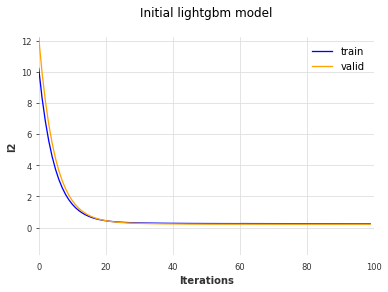

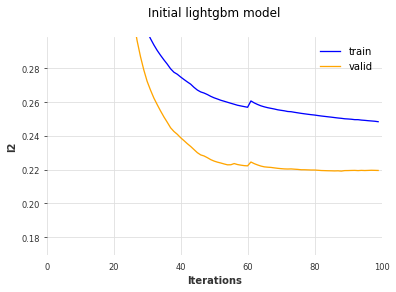

100%|██████████| 17263/17263 [19:08<00:00, 15.03it/s]




Backtest RMSE all: 2.472254
Backtest MAE all:  1.570762

# Backtest RMSE 48th: 2.887266
# Backtest MAE 48th:  1.914984

Backtest RMSE miss==0: 2.462235
Backtest MAE miss==0:  1.563243

Backtest RMSE miss==1: 3.379992
Backtest MAE miss==1:  2.378725


backtest['y_des']:
count	 801696
mean	 -0.401542
std	 3.29731
min	 -19.294815
25%	 -2.443948
50%	 -0.540967
75%	 1.613949
max	 66.166721

valid_df['y_des']:
count    16923.000000
mean        -0.366950
std          3.849934
min        -14.209171
25%         -2.839805
50%         -0.540260
75%          2.119017
max         14.288507
Name: y_des, dtype: float64



In [ ]:
series = TimeSeries.from_dataframe(train_df, value_cols=Y_COL)

# y_des excluded for lags = 1, lags_past_covariates = 1 to simplify variable importance plotting etc
# y_des must be included in past_cov for all other models
#ex_cols = ['y', 'y_des', 'humidity', 'dew.point']
ex_cols = ['y', 'y_seasonal', 'y_res', 'y_des', 'y_orig', 
           'dew.point', 'humidity', 'pressure', 'wind.speed.mean', 
           'humidity_seasonal', 'dew.point_seasonal', 'pressure_seasonal', 
           'humidity_res', 'dew.point_res', 'pressure_res', 
           'wind.speed.mean_res', 'wind.speed.mean_seasonal', 
           'wind.speed.mean_yearly', 'wind.speed.mean_daily', 
           'humidity_daily', 'pressure_daily', 'dew.point_daily',
           'humidity_yearly', 'pressure_yearly', 'dew.point_yearly',
           'dew.point_yhat',  'pressure_yhat', 'humidity_yhat', 'y_yhat',
           'wind.speed.mean_daily.x', 'wind.speed.mean_daily.y',
           'wind.speed.mean_yearly.x', 'wind.speed.mean_yearly.y',
           'wind.speed.mean_yhat.x', 'wind.speed.mean_yhat.y',
           'wind.speed.mean_des.x', 'wind.speed.mean_des.y',
           'wind.speed.mean.x', 'wind.speed.mean.y', 'za', 'za_rad',
          #'wind.speed.mean.sqrt.x', 'wind.speed.mean.sqrt.y',
           'wind.speed.mean_des', 'declination',
           'wind.speed.mean.sqrt', 'wind.bearing.mean',
           'wind.speed.mean_yhat', 'pressure.log',
           'wind.speed.mean.y_yearly', 'wind.speed.mean.x_yearly',
           'wind.speed.mean.y_daily', 'wind.speed.mean.x_daily',
           'dew.point_trend', 'y_trend', 'humidity_trend', 'pressure_trend', 'wind.speed.mean_trend']
           # 'day.sin.1', 'day.cos.1', 'year.sin.1', 'year.cos.1']

past_cov = TimeSeries.from_dataframe(train_df.loc[:, train_df.columns.difference(ex_cols)])

val_ser = TimeSeries.from_dataframe(valid_df, value_cols=Y_COL)
val_past_cov = TimeSeries.from_dataframe(valid_df.loc[:, valid_df.columns.difference(ex_cols)])

model_tr = LightGBMModel(lags = 1,
                         lags_past_covariates = 1,
                         linear_trees = True,
                        )
model = LightGBMModel(lags = 1,
                      lags_past_covariates = 1,
                      linear_trees = True,
                     )
model_tr.fit(series, 
             past_covariates = past_cov,
             val_series = series,
             val_past_covariates = past_cov,
             callbacks = [lgb.log_evaluation(0)]
            )
model.fit(series, 
          past_covariates = past_cov,
          val_series = val_ser,
          val_past_covariates = val_past_cov,
          callbacks = [lgb.log_evaluation(0)]
         )

title = 'Initial lightgbm model\n'
models = [model_tr, model]
print("\n")
plot_lgb_learning_curve(models, title)
plot_lgb_learning_curve(models, title, margin = 0.05)
print("\n")

backtest = model.historical_forecasts(series = val_ser, 
                                      past_covariates = val_past_cov,
                                      start   = 0.01, 
                                      retrain = False,
                                      verbose = True, 
                                      forecast_horizon = HORIZON,
                                      last_points_only = False
                                      )

hist_comp = calculate_historic_comparison(backtest, valid_df)
summarise_hist_comp(hist_comp, valid_df)
print("\nvalid_df['", Y_COL, "']:\n", valid_df[Y_COL].describe(), '\n', sep='')


The rmse and mae values indicate this is a reasonable first model.

---

Plot diagnostics:

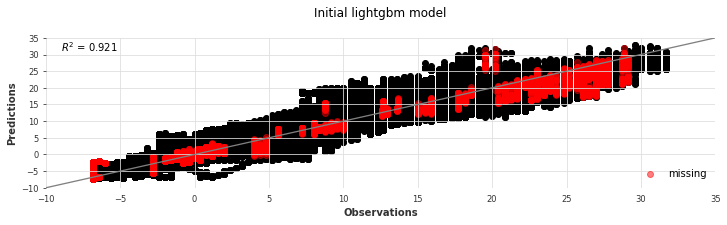

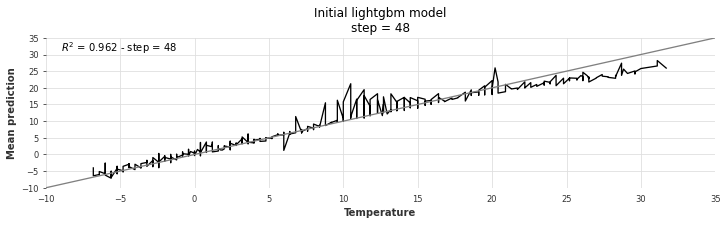

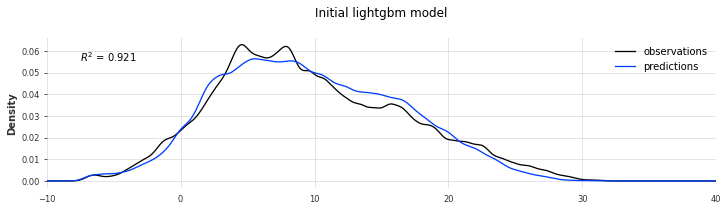

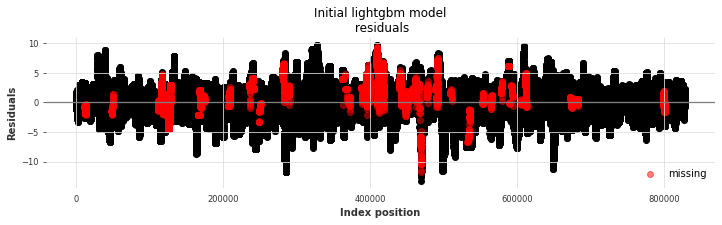

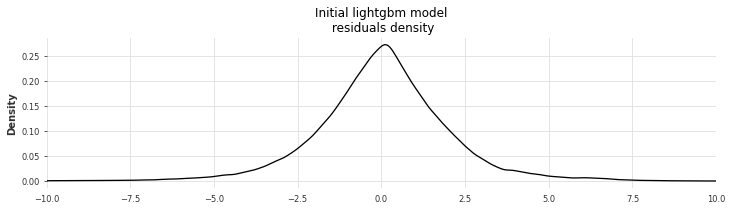

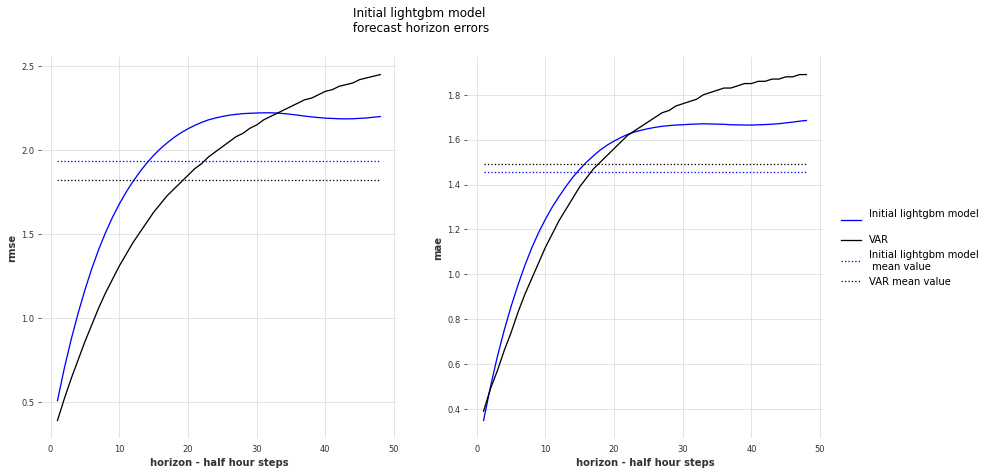

In [ ]:
plot_obs_vs_preds(hist_comp, title)
plot_obs_vs_mean_preds_by_step(hist_comp, title)
plot_obs_preds_dists(hist_comp, title)
plot_residuals(hist_comp, title + ' residuals')
plot_residuals_dist(hist_comp, title + ' residuals density')
plot_horizon_metrics(hist_comp, title)
# plot_forecast_examples(hist_comp, title + ' forecast examples')


The diagnostic plots indicate this is a reasonable first model.
The forecast horizon plot shows the superiority of the vector autoregressive (VAR) model, but the lightgbm model is better than all of the deep learning models.  The forecast examples (final) plot show 3 cases with high positive rmse values and 3 cases with low negative rmse values.  These are clear under- and over-estimates, but the form of these forecasts shows some similarities to the observations. 

---

Plot feature importance:

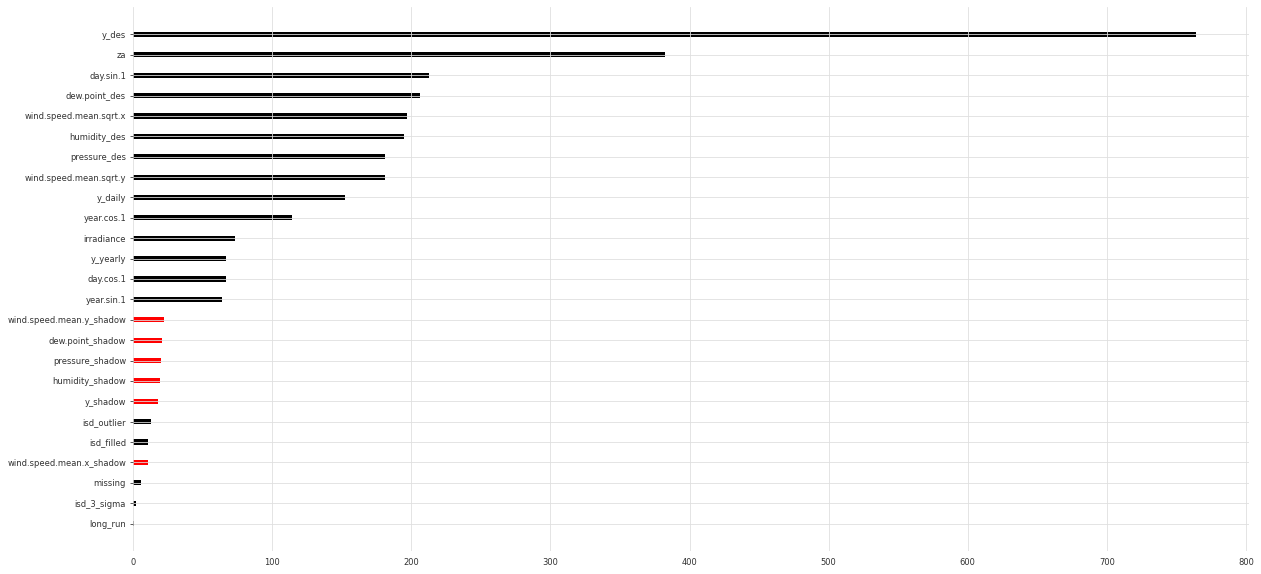

In [ ]:
plot_importances(model, train_df, exclude_cols = ex_cols)  #, include_cols=include_cols)

In [ ]:
inc_cols = get_most_important_variables(model, train_df, 64, exclude_cols = ex_cols)
display(train_df.loc[:, inc_cols['feature']].describe())

inc_cols:
                   feature  importance
30              year.sin.1          64
2                day.cos.1          67
28                y_yearly          67
9               irradiance          73
29              year.cos.1         114
26                 y_daily         152
23  wind.speed.mean.sqrt.y         181
19            pressure_des         181
7             humidity_des         195
22  wind.speed.mean.sqrt.x         197
4            dew.point_des         206
3                day.sin.1         213
31                      za         382
0                    y_des         764


year.sin.1     day.cos.1       y_yearly     irradiance  \
count  202806.000000  2.028060e+05  202806.000000  202806.000000   
mean       -0.008352 -5.653417e-03       0.120714     144.955304   
std         0.713967  7.067750e-01       4.984852     227.442864   
min        -1.000000 -1.000000e+00      -6.858733       0.000000   
25%        -0.725233 -7.071068e-01      -4.624842       0.000000   
50%        -0.021219 -1.844552e-12      -0.288967       0.003180   
75%         0.719752  7.071068e-01       5.026005     225.341118   
max         1.000000  1.000000e+00       7.646219     805.382014   

          year.cos.1        y_daily  wind.speed.mean.sqrt.y   pressure_des  \
count  202806.000000  202806.000000            2.028060e+05  202806.000000   
mean       -0.014448       0.020144           -4.604004e-01       1.000000   
std         0.699984       2.216178            1.349865e+00       0.001674   
min        -1.000000      -2.979810           -4.949747e+00       0.992688   
25%        -0.705957      -2.082641           -1.565248e+00       0.999023   
50%        -0.030964      -0.283452           -0.000000e+00       1.000132   
75%         0.675998       2.347032            4.929108e-16       1.001127   
max         1.000000       3.293761            4.669047e+00       1.005396   

        humidity_des  wind.speed.mean.sqrt.x  dew.point_des     day.sin.1  \
count  202806.000000            2.028060e+05  202806.000000  2.028060e+05   
mean        0.999976           -5.937161e-01      -0.000016 -3.546463e-03   
std         0.046539            1.395982e+00       3.511535  7.074104e-01   
min         0.707256           -5.366563e+00     -21.406951 -1.000000e+00   
25%         0.976180           -1.702939e+00      -2.381979 -7.071068e-01   
50%         1.002633           -3.872983e-01       0.007828 -1.061848e-12   
75%         1.028769            1.078107e-16       2.489485  7.071068e-01   
max         1.153174            3.683054e+00      12.352728  1.000000e+00   

                  za          y_des  
count  202806.000000  202806.000000  
mean        1.556538      -0.000040  
std         0.517429       3.541769  
min         0.502094     -13.916078  
25%         1.177518      -2.440362  
50%         1.548658      -0.174991  
75%         1.932840       2.289634  
max         2.639350      16.862535

The 6 shadow variables are clustered together on the importance plots.
In this case it was not beneficial to remove any of the features above the shadow variables.

The selected features include:
 * `year.sin.1`
 * `y_yearly`
 * `y_daily` 
 * `day.cos.1`          
 * `wind.y`        
 * `dew.point_des`         
 * `humidity_des`         
 * `wind.x` 
 * `pressure_des`
 * `year.cos.1`                         
 * `irradiance`
 * `day.sin.1`          
 * `y_des`  

Only the temperature yearly and daily (`y_yearly` and `y_daily`) components are selected.

---

#### Lag selection

Initial round of lag selection for both target and past covariates.

I did some brief experiments with future covariates but they did not prove beneficial with lightgbm or catboost with this dataset.  This is a little surprising because it proved useful with the VAR baseline.  It may be worthwhile repeating the future covariate experiments as there have been substantial changes.

There are two approaches to specifying lags in the darts package:
 1. single integer eg. 6
   * which includes -1, -2, -3, -4, -5, -6

 2. list of integers eg. -1, -2, -3, -23, -24, -25


But before specifing lag experiments, use the statsmodels package to plot autocorrelation function (ACF) and partial autocorrelation function (PACF).  Perhaps this will give some insight into which lag values to try first.

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


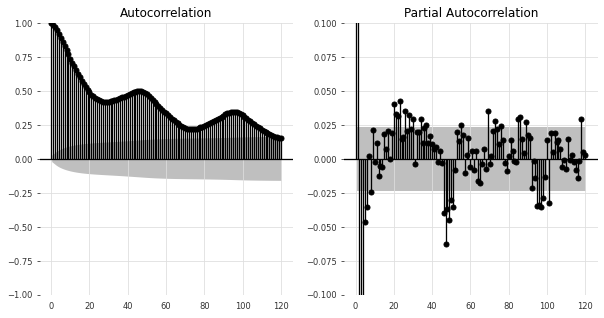

In [ ]:
n = 7000
max_lag = 120

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sm.graphics.tsa.plot_acf(df[Y_COL].head(n), missing='drop',  lags=max_lag, ax=ax[0])
sm.graphics.tsa.plot_pacf(df[Y_COL].dropna().head(n), lags=max_lag, ax=ax[1])
ax[1].set_ylim((-0.1, 0.1))
plt.show()

pac
0    1.000000
1    0.985697
2   -0.129427
3   -0.144905
4   -0.127971
5   -0.046532
6   -0.035450
20   0.040033
21   0.032767
22   0.031761
23   0.042795
26   0.035002
28   0.032056
30   0.029606
34   0.029411
46  -0.039734
47  -0.062402
48  -0.036646
49  -0.045228
50  -0.030128
51  -0.035067
69   0.035387
73   0.028081
85   0.028992
86   0.031096
89   0.027077
95  -0.034658
96  -0.033972
97  -0.035233
98  -0.028592
101 -0.032343
118  0.029235

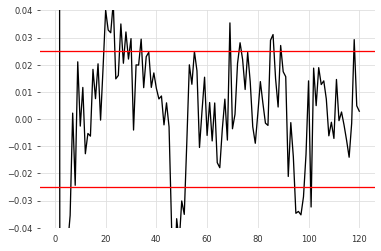

In [ ]:
pac = pacf(df[Y_COL].dropna().head(n), nlags=max_lag)
plt.plot(pac)
plt.axhline(y= 0.025, color='r', linestyle='-')
plt.axhline(y=-0.025, color='r', linestyle='-')
ax = plt.gca()
ax.set_ylim([-0.04, 0.04]);

pac_df = pd.DataFrame(pac, columns=['pac'])
pac_df.loc[abs(pac_df['pac']) > 0.026, :]

The ACF shows significance up to around 120 lags.

The PACF show high significance up to 6 and sporadic lower significance clustered around 24 and 48 lags.  

---

We step-by-step optimise:
 1. target and past lags up to 4
 2. use optimal lags from previous step plus target lags around 48
 3. use optimal lags from previous step plus target lags around 24
 4. use optimal lags from previous step plus past lags around 24

There was no benefit from adding past covariate lags around 48.  For brevity, I have removed that cell.

For the first round of lag selection, start with the single integer approach for both the target and past covariates.

Specifically:

   * target_lags -   [1, 2, 3, 4]
   * past_cov_lags - [1, 2, 3, 4]

This gives a total of 16 combinations of lags.

The models below are built on the full training data but evaluated on the validation data set.

A few things to note:
  * the `historical_forecasts` function call in the `calculate_rmse_mae_from_backtest` function is quite time consuming on the full training data
  * the training metrics are not as important as the validation metrics

In [ ]:
#param_grid = {
#   'target_lags':   [1, 3, 6, 12, 24, 48],
#   'past_cov_lags': [1, 3, 6, 12, 24, 48],
#}
#param_grid = {
#   'target_lags':   [1, 4, 24, 48],
#   'past_cov_lags': [1, 4, 24, 48],
#}
param_grid = {
   'target_lags':   [1, 2, 3, 4],
   'past_cov_lags': [1, 2, 3, 4],
}

param_df = expand_grid(param_grid)
param_df['target_lags']   = param_df['target_lags'].astype('int64')
param_df['past_cov_lags'] = param_df['past_cov_lags'].astype('int64')
param_df['val_rmse']   = param_df['val_mae']   = 10.0
param_df['train_rmse'] = param_df['train_mae'] = 10.0


series = TimeSeries.from_dataframe(train_df, value_cols=Y_COL)
past_cov = TimeSeries.from_dataframe(train_df.loc[:, inc_cols['feature']])

val_ser = TimeSeries.from_dataframe(valid_df, value_cols=Y_COL)
val_past_cov = TimeSeries.from_dataframe(valid_df.loc[:, inc_cols['feature']])

df['year'] = df['ds'].dt.year
train_2016 = df.loc[df['year'] == 2016]
train_2016 = train_2016.asfreq(freq='30min')

train_2016 = train_2016.drop(['year'], axis = 1)
df = df.drop(['year'], axis = 1)

train_ser = TimeSeries.from_dataframe(train_2016, value_cols=Y_COL)
train_past_cov = TimeSeries.from_dataframe(train_2016.loc[:, inc_cols['feature']])


for i in param_df.index:
    print("\ni:", i)
    display(param_df.loc[i, ['target_lags', 'past_cov_lags']].astype(int))

    target_lags, past_cov_lags = param_df.loc[i, ['target_lags', 'past_cov_lags']]

    model = LightGBMModel(lags = int(target_lags),
                          lags_past_covariates = int(past_cov_lags))
    model.fit(series, past_covariates = past_cov)

    param_df = calculate_rmse_mae_from_backtest(model, param_df, i, val_ser,   val_past_cov,   valid_df,   'val')
    display(param_df.loc[i, ['val_rmse', 'val_mae']])
    # param_df = calculate_rmse_mae_from_backtest(model, param_df, i, train_ser, train_past_cov, train_2016, 'train')
    # display(param_df.loc[i, :])


display(param_df[['target_lags',	'past_cov_lags',	'val_rmse',	'val_mae']].sort_values('val_rmse'))

ax = plt.figure().add_subplot(projection='3d')
ax.scatter(param_df['target_lags'], param_df['past_cov_lags'], param_df['val_rmse'])
ax.set_xlabel('target lags')
ax.set_ylabel('past covariate lags')
ax.set_zlabel('validation rmse')

param_df.loc[param_df['past_cov_lags'] == 1, ['target_lags','val_rmse']].plot(x='target_lags', y='val_rmse');


i: 0


target_lags      1
past_cov_lags    1
Name: 0, dtype: int64

100%|██████████| 17263/17263 [10:06<00:00, 28.45it/s]


val_rmse    2.270981
val_mae     1.736981
Name: 0, dtype: float64


i: 1


target_lags      1
past_cov_lags    2
Name: 1, dtype: int64

100%|██████████| 17263/17263 [10:05<00:00, 28.52it/s]


val_rmse    2.415879
val_mae     1.882842
Name: 1, dtype: float64


i: 2


target_lags      1
past_cov_lags    3
Name: 2, dtype: int64

100%|██████████| 17263/17263 [10:04<00:00, 28.55it/s]


val_rmse    3.253358
val_mae     2.600202
Name: 2, dtype: float64


i: 3


target_lags      1
past_cov_lags    4
Name: 3, dtype: int64

100%|██████████| 17263/17263 [10:08<00:00, 28.36it/s]


val_rmse    3.891418
val_mae     3.095926
Name: 3, dtype: float64


i: 4


target_lags      2
past_cov_lags    1
Name: 4, dtype: int64

100%|██████████| 17263/17263 [10:03<00:00, 28.62it/s]


val_rmse    2.233192
val_mae     1.717264
Name: 4, dtype: float64


i: 5


target_lags      2
past_cov_lags    2
Name: 5, dtype: int64

100%|██████████| 17263/17263 [10:10<00:00, 28.27it/s]


val_rmse    2.415156
val_mae     1.866958
Name: 5, dtype: float64


i: 6


target_lags      2
past_cov_lags    3
Name: 6, dtype: int64

100%|██████████| 17263/17263 [10:03<00:00, 28.61it/s]


val_rmse    3.518588
val_mae     2.819375
Name: 6, dtype: float64


i: 7


target_lags      2
past_cov_lags    4
Name: 7, dtype: int64

100%|██████████| 17263/17263 [10:03<00:00, 28.61it/s]


val_rmse    4.418894
val_mae     3.536517
Name: 7, dtype: float64


i: 8


target_lags      3
past_cov_lags    1
Name: 8, dtype: int64

100%|██████████| 17263/17263 [09:58<00:00, 28.86it/s]


val_rmse    2.288039
val_mae     1.737303
Name: 8, dtype: float64


i: 9


target_lags      3
past_cov_lags    2
Name: 9, dtype: int64

100%|██████████| 17263/17263 [10:00<00:00, 28.76it/s]


val_rmse    2.368348
val_mae     1.816666
Name: 9, dtype: float64


i: 10


target_lags      3
past_cov_lags    3
Name: 10, dtype: int64

100%|██████████| 17263/17263 [10:04<00:00, 28.54it/s]


val_rmse    2.502457
val_mae     1.940909
Name: 10, dtype: float64


i: 11


target_lags      3
past_cov_lags    4
Name: 11, dtype: int64

100%|██████████| 17263/17263 [10:03<00:00, 28.62it/s]


val_rmse    4.371777
val_mae     3.508516
Name: 11, dtype: float64


i: 12


target_lags      4
past_cov_lags    1
Name: 12, dtype: int64

100%|██████████| 17263/17263 [10:00<00:00, 28.75it/s]


val_rmse    2.296089
val_mae     1.744182
Name: 12, dtype: float64


i: 13


target_lags      4
past_cov_lags    2
Name: 13, dtype: int64

100%|██████████| 17263/17263 [10:03<00:00, 28.59it/s]


val_rmse    2.401549
val_mae     1.842200
Name: 13, dtype: float64


i: 14


target_lags      4
past_cov_lags    3
Name: 14, dtype: int64

100%|██████████| 17263/17263 [10:01<00:00, 28.69it/s]


val_rmse    2.482736
val_mae     1.906406
Name: 14, dtype: float64


i: 15


target_lags      4
past_cov_lags    4
Name: 15, dtype: int64

100%|██████████| 17263/17263 [09:59<00:00, 28.78it/s]


val_rmse    2.512201
val_mae     1.939588
Name: 15, dtype: float64

target_lags  past_cov_lags  val_rmse   val_mae  train_rmse  train_mae
4             2              1  2.233192  1.717264        10.0       10.0
0             1              1  2.270981  1.736981        10.0       10.0
8             3              1  2.288039  1.737303        10.0       10.0
12            4              1  2.296089  1.744182        10.0       10.0
9             3              2  2.368348  1.816666        10.0       10.0
13            4              2  2.401549  1.842200        10.0       10.0
5             2              2  2.415156  1.866958        10.0       10.0
1             1              2  2.415879  1.882842        10.0       10.0
14            4              3  2.482736  1.906406        10.0       10.0
10            3              3  2.502457  1.940909        10.0       10.0
15            4              4  2.512201  1.939588        10.0       10.0
2             1              3  3.253358  2.600202        10.0       10.0
6             2              3  3.518588  2.819375        10.0       10.0
3             1              4  3.891418  3.095926        10.0       10.0
11            3              4  4.371777  3.508516        10.0       10.0
7             2              4  4.418894  3.536517        10.0       10.0

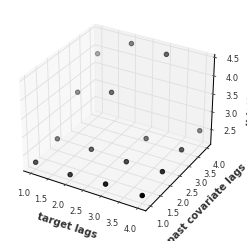

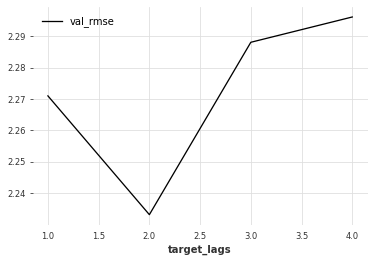

In [ ]:
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(param_df['target_lags'], param_df['past_cov_lags'], param_df['val_rmse'])
ax.set_xlabel('target lags')
ax.set_ylabel('past covariate lags')
ax.set_zlabel('validation rmse')


param_df.loc[param_df['past_cov_lags'] == 1, ['target_lags','val_rmse']].plot(x='target_lags', y='val_rmse');


The following table shows the largest improvement in rmse and mae:

| target_lag | past_cov_lag | 48th valid rmse | 48th valid mae |
|------------|--------------|-----------------|----------------|
|	         2 |	          1 |	       2.233192 |	      1.717264 |
|	         1 |	          1 |	       2.270981 |	      1.736981 |

Next, target_lag = 2, past_cov_lag = 1 and add target_lag values around 48:

In [ ]:
target_lags = [-1, -2]

for i in [-48, -47, -46]:
  target_lags.append(i)
  target_lags = sorted(target_lags, reverse=True)
  print('target_lags:', target_lags)
  model2 = LightGBMModel(lags = target_lags,
                         lags_past_covariates = 1)
  model2.fit(series, 
             past_covariates = past_cov)

  backtest2 = model2.historical_forecasts(series = val_ser, 
                                          past_covariates = val_past_cov,
                                          start   = 0.01, 
                                          retrain = False,
                                          verbose = True, 
                                          forecast_horizon = HORIZON,
                                          last_points_only = False
                                         )

  hist_comp2 = calculate_historic_comparison(backtest2, valid_df)
  summarise_hist_comp(hist_comp2, valid_df)
  print("\nvalid_df['", Y_COL, "']:\n", valid_df[Y_COL].describe(), '\n\n', sep='')

[-1, -2, -48]


100%|██████████| 17263/17263 [10:12<00:00, 28.19it/s]




Backtest RMSE all: 1.985735
Backtest MAE all:  1.462027

# Backtest RMSE 48th: 2.207871
# Backtest MAE 48th:  1.692108

Backtest RMSE miss==0: 1.977278
Backtest MAE miss==0:  1.456508

Backtest RMSE miss==1: 2.746704
Backtest MAE miss==1:  2.055031


backtest['y_des']:
count	 801696
mean	 -0.43042
std	 3.305752
min	 -11.987634
25%	 -2.417487
50%	 -0.535491
75%	 1.66037
max	 13.485361

valid_df['y_des']:
count    16923.000000
mean        -0.309395
std          3.822988
min        -14.034760
25%         -2.770027
50%         -0.485923
75%          2.161211
max         14.355653
Name: y_des, dtype: float64


[-1, -2, -47, -48]


100%|██████████| 17263/17263 [10:15<00:00, 28.04it/s]




Backtest RMSE all: 1.969969
Backtest MAE all:  1.452796

# Backtest RMSE 48th: 2.193131
# Backtest MAE 48th:  1.682955

Backtest RMSE miss==0: 1.961468
Backtest MAE miss==0:  1.447536

Backtest RMSE miss==1: 2.733504
Backtest MAE miss==1:  2.018022


backtest['y_des']:
count	 801696
mean	 -0.428373
std	 3.275764
min	 -12.50954
25%	 -2.386715
50%	 -0.507089
75%	 1.630183
max	 13.892185

valid_df['y_des']:
count    16923.000000
mean        -0.309395
std          3.822988
min        -14.034760
25%         -2.770027
50%         -0.485923
75%          2.161211
max         14.355653
Name: y_des, dtype: float64


[-1, -2, -46, -47, -48]


100%|██████████| 17263/17263 [10:13<00:00, 28.13it/s]




Backtest RMSE all: 1.974913
Backtest MAE all:  1.455775

# Backtest RMSE 48th: 2.218891
# Backtest MAE 48th:  1.699185

Backtest RMSE miss==0: 1.966105
Backtest MAE miss==0:  1.450337

Backtest RMSE miss==1: 2.762346
Backtest MAE miss==1:  2.040094


backtest['y_des']:
count	 801696
mean	 -0.439466
std	 3.300782
min	 -12.420827
25%	 -2.444301
50%	 -0.559144
75%	 1.649221
max	 14.143551

valid_df['y_des']:
count    16923.000000
mean        -0.309395
std          3.822988
min        -14.034760
25%         -2.770027
50%         -0.485923
75%          2.161211
max         14.355653
Name: y_des, dtype: float64




The following table shows the largest improvement in rmse and mae:

| target_lag  | past_cov_lag | 48th valid rmse  | 48th valid mae |
|-------------|--------------|------------------|----------------|
|-1,-2,-47,-48|	           1 |	       2.193131 |	      1.682955 |
|	         2  |	           1 |	       2.233192 |	      1.717264 |
|	         1  |	           1 |	       2.270981 |	      1.736981 |

Next, target_lag = -1,-2,-47,-48, past_cov_lag = 1 and add target_lag values around 24:

In [ ]:
target_lags = [-1, -2, -47, -48]

for i in [-24, -23, -22, -21]:
  target_lags.append(i)
  target_lags = sorted(target_lags, reverse=True)
  print('target_lags:', target_lags)
  model3 = LightGBMModel(lags = target_lags,
                         lags_past_covariates = 1)
  model3.fit(series, 
             past_covariates = past_cov)

  backtest3 = model3.historical_forecasts(series = val_ser, 
                                          past_covariates = val_past_cov,
                                          start   = 0.01, 
                                          retrain = False,
                                          verbose = True, 
                                          forecast_horizon = HORIZON,
                                          last_points_only = False
                                         )

  hist_comp3 = calculate_historic_comparison(backtest3, valid_df)
  summarise_hist_comp(hist_comp3, valid_df)
  print("\nvalid_df['", Y_COL, "']:\n", valid_df[Y_COL].describe(), '\n\n', sep='')

target_lags: [-1, -2, -24, -47, -48]


100%|██████████| 17263/17263 [10:10<00:00, 28.30it/s]




Backtest RMSE all: 1.942673
Backtest MAE all:  1.433193

# Backtest RMSE 48th: 2.186445
# Backtest MAE 48th:  1.672023

Backtest RMSE miss==0: 1.935911
Backtest MAE miss==0:  1.429008

Backtest RMSE miss==1: 2.567535
Backtest MAE miss==1:  1.882934


backtest['y_des']:
count	 801696
mean	 -0.395441
std	 3.332619
min	 -11.287898
25%	 -2.411324
50%	 -0.53674
75%	 1.720874
max	 13.988033

valid_df['y_des']:
count    16923.000000
mean        -0.309395
std          3.822988
min        -14.034760
25%         -2.770027
50%         -0.485923
75%          2.161211
max         14.355653
Name: y_des, dtype: float64


target_lags: [-1, -2, -23, -24, -47, -48]


100%|██████████| 17263/17263 [10:14<00:00, 28.08it/s]




Backtest RMSE all: 1.949294
Backtest MAE all:  1.436305

# Backtest RMSE 48th: 2.186885
# Backtest MAE 48th:  1.671603

Backtest RMSE miss==0: 1.942732
Backtest MAE miss==0:  1.432128

Backtest RMSE miss==1: 2.55808
Backtest MAE miss==1:  1.885097


backtest['y_des']:
count	 801696
mean	 -0.399154
std	 3.329806
min	 -10.93722
25%	 -2.397394
50%	 -0.569623
75%	 1.702781
max	 14.320959

valid_df['y_des']:
count    16923.000000
mean        -0.309395
std          3.822988
min        -14.034760
25%         -2.770027
50%         -0.485923
75%          2.161211
max         14.355653
Name: y_des, dtype: float64


target_lags: [-1, -2, -22, -23, -24, -47, -48]


100%|██████████| 17263/17263 [10:13<00:00, 28.16it/s]




Backtest RMSE all: 1.92957
Backtest MAE all:  1.424689

# Backtest RMSE 48th: 2.173043
# Backtest MAE 48th:  1.664658

Backtest RMSE miss==0: 1.922225
Backtest MAE miss==0:  1.420241

Backtest RMSE miss==1: 2.600614
Backtest MAE miss==1:  1.902669


backtest['y_des']:
count	 801696
mean	 -0.424519
std	 3.325324
min	 -11.147933
25%	 -2.434154
50%	 -0.551905
75%	 1.674706
max	 14.474755

valid_df['y_des']:
count    16923.000000
mean        -0.309395
std          3.822988
min        -14.034760
25%         -2.770027
50%         -0.485923
75%          2.161211
max         14.355653
Name: y_des, dtype: float64




The following table shows the largest improvement in rmse and mae:

|       target_lag        | past_cov_lag | 48th valid rmse | 48th valid mae |
|-------------------------|--------------|-----------------|----------------|
|-1,-2,-22,-23,-24,-47,-48|	           1 |	      2.173043 |	     1.664658 |
|           -1,-2,-47,-48 |	           1 |	      2.193131 |	     1.682955 |
|	                     2  |	           1 |	      2.233192 |	     1.717264 |
|	                     1  |	           1 |	      2.270981 |	     1.736981 |

Next, target_lag = -1,-2,-22,-23,-24,-47,-48, past_cov_lag = 1 and add past_cov_lag values around 24:

target_lags: [-1, -2, -22, -23, -24, -47, -48]
lags_past_covariates: [-1, -24]


/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')
/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


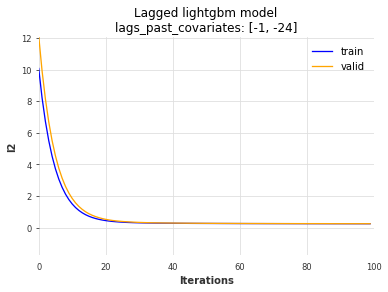

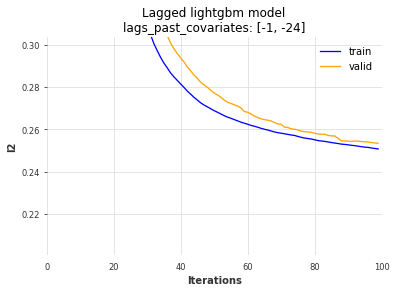

100%|██████████| 17263/17263 [10:24<00:00, 27.63it/s]




Backtest RMSE all: 1.923458
Backtest MAE all:  1.420351

# Backtest RMSE 48th: 2.140401
# Backtest MAE 48th:  1.639309

Backtest RMSE miss==0: 1.917552
Backtest MAE miss==0:  1.416353

Backtest RMSE miss==1: 2.477363
Backtest MAE miss==1:  1.850023


backtest['y_des']:
count	 801696
mean	 -0.406124
std	 3.308547
min	 -10.564353
25%	 -2.435426
50%	 -0.527623
75%	 1.650459
max	 13.087491

valid_df['y_des']:
count    16923.000000
mean        -0.309395
std          3.822988
min        -14.034760
25%         -2.770027
50%         -0.485923
75%          2.161211
max         14.355653
Name: y_des, dtype: float64


lags_past_covariates: [-1, -23, -24]


/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


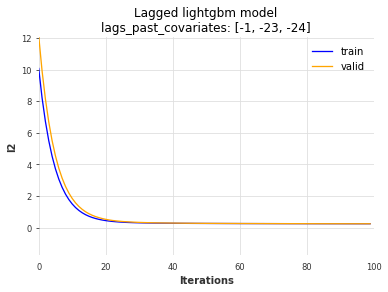

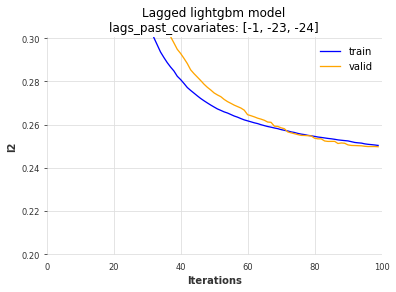

100%|██████████| 17263/17263 [10:15<00:00, 28.04it/s]




Backtest RMSE all: 1.913622
Backtest MAE all:  1.40839

# Backtest RMSE 48th: 2.139876
# Backtest MAE 48th:  1.633001

Backtest RMSE miss==0: 1.906815
Backtest MAE miss==0:  1.403692

Backtest RMSE miss==1: 2.540976
Backtest MAE miss==1:  1.913177


backtest['y_des']:
count	 801696
mean	 -0.399374
std	 3.346829
min	 -11.021627
25%	 -2.421915
50%	 -0.562307
75%	 1.649805
max	 13.288304

valid_df['y_des']:
count    16923.000000
mean        -0.309395
std          3.822988
min        -14.034760
25%         -2.770027
50%         -0.485923
75%          2.161211
max         14.355653
Name: y_des, dtype: float64


lags_past_covariates: [-1, -23, -24, -25]


/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')
/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


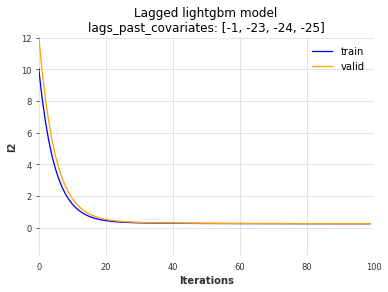

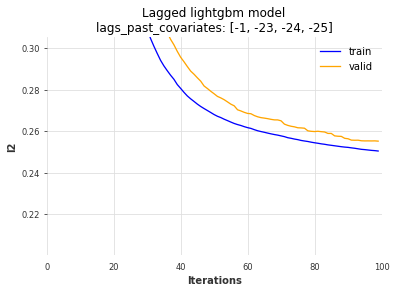

100%|██████████| 17263/17263 [10:18<00:00, 27.89it/s]




Backtest RMSE all: 1.91875
Backtest MAE all:  1.414701

# Backtest RMSE 48th: 2.127122
# Backtest MAE 48th:  1.624894

Backtest RMSE miss==0: 1.913332
Backtest MAE miss==0:  1.410918

Backtest RMSE miss==1: 2.431571
Backtest MAE miss==1:  1.821207


backtest['y_des']:
count	 801696
mean	 -0.395481
std	 3.341314
min	 -10.546376
25%	 -2.406353
50%	 -0.547646
75%	 1.638759
max	 13.259896

valid_df['y_des']:
count    16923.000000
mean        -0.309395
std          3.822988
min        -14.034760
25%         -2.770027
50%         -0.485923
75%          2.161211
max         14.355653
Name: y_des, dtype: float64


lags_past_covariates: [-1, -22, -23, -24, -25]


/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')
/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


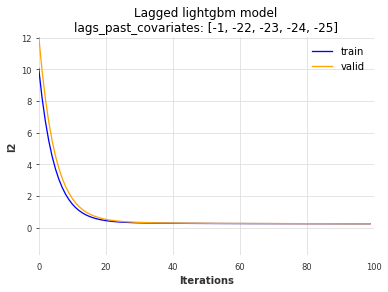

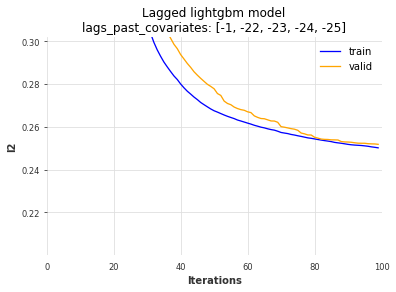

100%|██████████| 17263/17263 [10:22<00:00, 27.72it/s]




Backtest RMSE all: 1.906231
Backtest MAE all:  1.402435

# Backtest RMSE 48th: 2.126126
# Backtest MAE 48th:  1.620141

Backtest RMSE miss==0: 1.900164
Backtest MAE miss==0:  1.398363

Backtest RMSE miss==1: 2.472866
Backtest MAE miss==1:  1.840001


backtest['y_des']:
count	 801696
mean	 -0.406971
std	 3.334486
min	 -10.849533
25%	 -2.424668
50%	 -0.543843
75%	 1.624385
max	 13.351676

valid_df['y_des']:
count    16923.000000
mean        -0.309395
std          3.822988
min        -14.034760
25%         -2.770027
50%         -0.485923
75%          2.161211
max         14.355653
Name: y_des, dtype: float64


lags_past_covariates: [-1, -21, -22, -23, -24, -25]


/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')
/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


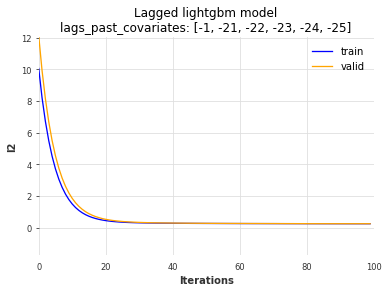

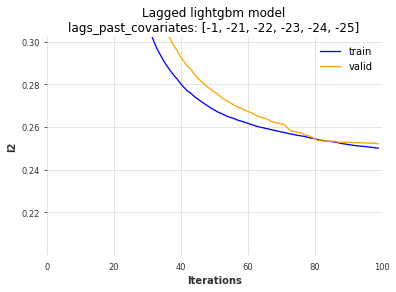

100%|██████████| 17263/17263 [10:25<00:00, 27.60it/s]




Backtest RMSE all: 1.916054
Backtest MAE all:  1.409885

# Backtest RMSE 48th: 2.146543
# Backtest MAE 48th:  1.640408

Backtest RMSE miss==0: 1.909905
Backtest MAE miss==0:  1.405704

Backtest RMSE miss==1: 2.489816
Backtest MAE miss==1:  1.859117


backtest['y_des']:
count	 801696
mean	 -0.415835
std	 3.343004
min	 -10.721719
25%	 -2.439995
50%	 -0.564548
75%	 1.621846
max	 13.392928

valid_df['y_des']:
count    16923.000000
mean        -0.309395
std          3.822988
min        -14.034760
25%         -2.770027
50%         -0.485923
75%          2.161211
max         14.355653
Name: y_des, dtype: float64




In [ ]:
pastcov_lags = [-1]
target_lags  = [-1, -2, -22, -23, -24, -47, -48]
print('target_lags:', target_lags)

for i in [-24, -23, -25, -22, -21]:
  pastcov_lags.append(i)
  pastcov_lags = sorted(pastcov_lags, reverse=True)
  print('lags_past_covariates:', pastcov_lags)

  model3 = LightGBMModel(lags = target_lags,
                         lags_past_covariates = pastcov_lags)
  model3_tr = LightGBMModel(lags = target_lags,
                            lags_past_covariates = pastcov_lags)  
  model3_tr.fit(series, 
                past_covariates = past_cov,
                val_series = series,
                val_past_covariates = past_cov,
                callbacks = [lgb.log_evaluation(0)]
               )
  model3.fit(series, 
             past_covariates = past_cov,
             val_series = val_ser,
             val_past_covariates = val_past_cov,
             callbacks = [lgb.log_evaluation(0)]
            )

  title = 'Lagged lightgbm model\nlags_past_covariates: ' + str(pastcov_lags)
  models = [model3_tr, model3]
  print("\n")
  plot_lgb_learning_curve(models, title)
  plot_lgb_learning_curve(models, title, margin = 0.05)
  print("\n")

  backtest3 = model3.historical_forecasts(series = val_ser, 
                                          past_covariates = val_past_cov,
                                          start   = 0.01, 
                                          retrain = False,
                                          verbose = True, 
                                          forecast_horizon = HORIZON,
                                          last_points_only = False
                                         )
  hist_comp3 = calculate_historic_comparison(backtest3, valid_df)
  summarise_hist_comp(hist_comp3, valid_df)
  print("\nvalid_df['", Y_COL, "']:\n", valid_df[Y_COL].describe(), '\n\n', sep='')

The following table shows the largest improvement in rmse and mae:

|       target_lag        | past_cov_lag | 48th valid rmse | 48th valid mae |
|-------------------------|--------------|-----------------|----------------|
|-1,-2,-22,-23,-24,-47,-48|-1,-23,-24,-25|	      2.127122 |	     1.624894 |
|-1,-2,-22,-23,-24,-47,-48|	           1 |	      2.173043 |	     1.664658 |
|           -1,-2,-47,-48 |	           1 |	      2.193131 |	     1.682955 |
|	                     2  |	           1 |	      2.233192 |	     1.717264 |
|	                     1  |	           1 |	      2.270981 |	     1.736981 |

Note that, past_cov_lag = -1, -22, -23, -24, -25 gives marginally lower rmse and mae but I choose to use past_cov_lag = -1, -23, -24, -25 instead for parsimony.

Overall, a substantial improvement in both rmse and mae.

---

Rebuild best model and plot diagnostics:

/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')
/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


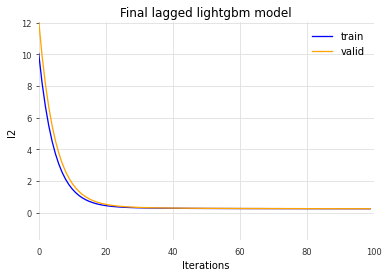

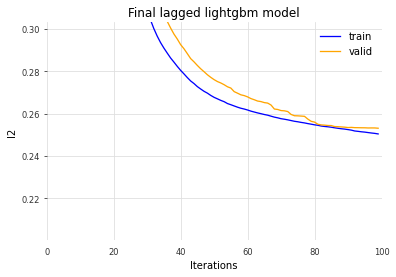

100%|██████████| 17263/17263 [15:29<00:00, 18.57it/s]




Backtest RMSE all: 1.922534
Backtest MAE all:  1.414872

# Backtest RMSE 48th: 2.154762
# Backtest MAE 48th:  1.6394

Backtest RMSE miss==0: 1.917156
Backtest MAE miss==0:  1.4109

Backtest RMSE miss==1: 2.432068
Backtest MAE miss==1:  1.841693


backtest['y_des']:
count	 801696
mean	 -0.420543
std	 3.325633
min	 -10.627875
25%	 -2.450568
50%	 -0.546935
75%	 1.607869
max	 13.127084

valid_df['y_des']:
count    16923.000000
mean        -0.309395
std          3.822988
min        -14.034760
25%         -2.770027
50%         -0.485923
75%          2.161211
max         14.355653
Name: y_des, dtype: float64




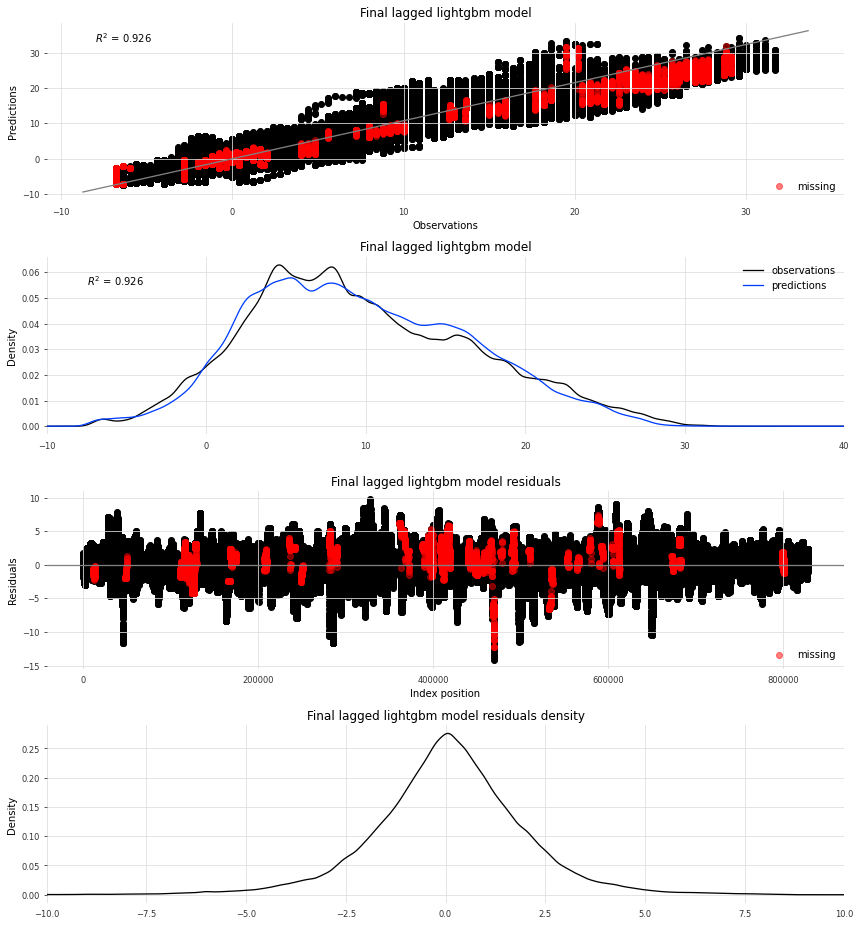

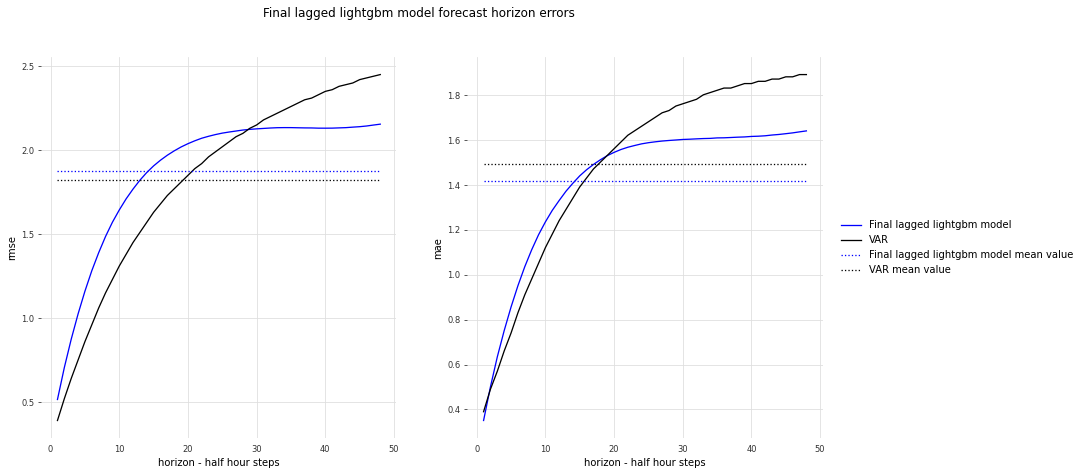

In [ ]:
pastcov_lags = [-1, -23, -24, -25]
target_lags  = [-1, -2, -22, -23, -24, -47, -48]
model4 = LightGBMModel(lags = target_lags,
                       lags_past_covariates = pastcov_lags)
model4_tr = LightGBMModel(lags = target_lags,
                          lags_past_covariates = pastcov_lags)  
model4_tr.fit(series, 
              past_covariates = past_cov,
              val_series = series,
              val_past_covariates = past_cov,
              callbacks = [lgb.log_evaluation(0)]
             )
model4.fit(series, 
           past_covariates = past_cov,
           val_series = val_ser,
           val_past_covariates = val_past_cov,
           callbacks = [lgb.log_evaluation(0)]
          )

title = 'Final lagged lightgbm model'
models = [model4_tr, model4]
print("\n")
plot_lgb_learning_curve(models, title)
plot_lgb_learning_curve(models, title, margin = 0.05)
print("\n")

backtest4 = model4.historical_forecasts(series = val_ser, 
                                        past_covariates = val_past_cov,
                                        start   = 0.01, 
                                        retrain = False,
                                        verbose = True, 
                                        forecast_horizon = HORIZON,
                                        last_points_only = False
                                       )
hist_comp4 = calculate_historic_comparison(backtest4, valid_df)
summarise_hist_comp(hist_comp4, valid_df)
print("\nvalid_df['", Y_COL, "']:\n", valid_df[Y_COL].describe(), '\n\n', sep='')

plot_obs_vs_preds(hist_comp4, title)
plot_obs_preds_dists(hist_comp4, title)
plot_residuals(hist_comp4, title + ' residuals')
plot_residuals_dist(hist_comp4, title + ' residuals density')
plot_horizon_metrics(hist_comp4, title)
# plot_forecast_examples(hist_comp4, title + ' forecast examples')

...

TODO Summarise diagnostics

---

### 2. darts catboost


It is unrealistic to concurrently optimise all of the time series gradient boosting components on google colab.  So, an iterative process is necessary.

I use the same features that were selected for the lightgbm models.
They include:
 * `day.cos.1`          
 * `year.cos.1`         
 * `year.sin.1`         
 * `dew.point`         
 * `pressure`         
 * `wind.y`         
 * `humidity`         
 * `wind.x`         
 * `day.sin.1`         
 * `irradiance`         
 * `y_des`  

There are 2 major components to optimise:
 * lag selection
   * target series lags
   * past covariate (feature) lags
 * hyperparameter tuning
```
param_grid = {
 'n_estimators':  [100, 500],
 'max_depth':     [3, 5, 10],
 'learning_rate': [0.01, 0.1]
 }
```

Before starting lag selection, build an initial `lags = 1` and `lags_past_covariates = 1` catboost model:

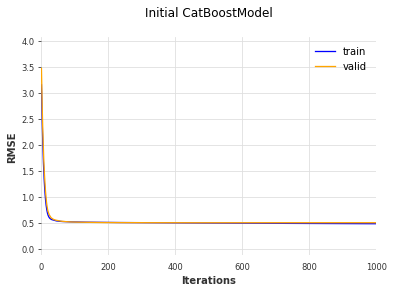

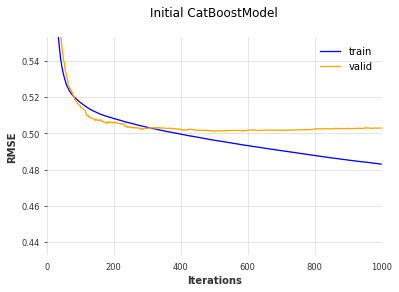

100%|██████████| 17263/17263 [18:03<00:00, 15.93it/s]


valid_df['y_des']:
count    16923.000000
mean        -0.366950
std          3.849934
min        -14.209171
25%         -2.839805
50%         -0.540260
75%          2.119017
max         14.288507
Name: y_des, dtype: float64



Backtest RMSE all: 0.752988
Backtest MAE all:  0.515287

# Backtest RMSE 48th: 0.759789
# Backtest MAE 48th:  0.523171

Backtest RMSE miss==0: 0.740467
Backtest MAE miss==0:  0.511026

Backtest RMSE miss==1: 1.605095
Backtest MAE miss==1:  0.973161


backtest['y_des']:
count	 801696
mean	 -0.3992
std	 3.653483
min	 -13.037721
25%	 -2.793664
50%	 -0.568705
75%	 1.99039
max	 12.112839


In [ ]:
series = TimeSeries.from_dataframe(train_df, value_cols=Y_COL)
past_cov = TimeSeries.from_dataframe(train_df.loc[:, inc_cols['feature']])
val_ser = TimeSeries.from_dataframe(valid_df, value_cols=Y_COL)
val_past_cov = TimeSeries.from_dataframe(valid_df.loc[:, inc_cols['feature']])
# target_lags  = [-1, -2, -22, -23, -24, -47, -48]
# pastcov_lags = [-1, -23, -24, -25]

model5 = CatBoostModel(lags = 1,
                       lags_past_covariates = 1)

model5.fit(series, 
           past_covariates = past_cov,
           val_series = val_ser,
           val_past_covariates = val_past_cov)
title5 = 'Initial CatBoostModel\n'
plot_catboost_learning_curve(model5, title5)
plot_catboost_learning_curve(model5, title5, margin=0.05)

backtest5 = model5.historical_forecasts(series = val_ser, 
                                       past_covariates = val_past_cov,
                                       start   = 0.01, 
                                       retrain = False,
                                       verbose = True, 
                                       forecast_horizon = HORIZON,
                                       last_points_only = False)

print("valid_df['", Y_COL, "']:\n", valid_df[Y_COL].describe(), "\n", sep='')
hist_comp5 = calculate_historic_comparison(backtest5, valid_df)
summarise_hist_comp(hist_comp5, valid_df)



# CatBoost
# missing == 0.0 only
#        feature  importance
# 5    dew.point          42
# 3    day.cos.1          66
# 1           ah          97
# 29  year.cos.1         111
# 30  year.sin.1         119
# 26      wind.y         221
# 21    pressure         226
# 4    day.sin.1         230
# 24      wind.x         231
# 8     humidity         254
# 10  irradiance         296
# 0        y_des         910
# Backtest RMSE: 0.628032
# Backtest MAE:  0.460348

# CatBoost
# df['mi_filled'] != 1.0 & df['hist_average'] != 1.0
#        feature  importance
# 3    day.cos.1          59
# 5    dew.point          65
# 1           ah          84
# 30  year.sin.1         114
# 29  year.cos.1         120
# 21    pressure         217
# 26      wind.y         218
# 4    day.sin.1         231
# 24      wind.x         242
# 8     humidity         255
# 10  irradiance         276
# 0        y_des         880
# Backtest RMSE: 0.641121
# Backtest MAE:  0.471475
# not as good as missing == 0.0 only :-(
    
# CatBoost
# df['mi_filled'] != 1.0 & df['hist_average'] != 1.0 and 
# no train_df.asfreq('30mins', method='ffill')
#        feature  importance
# 3    day.cos.1          63
# 5    dew.point          67
# 1           ah          75
# 29  year.cos.1         114
# 30  year.sin.1         121
# 21    pressure         206
# 24      wind.x         231
# 4    day.sin.1         232
# 26      wind.y         236
# 8     humidity         256
# 10  irradiance         288
# 0        y_des         873
# Backtest RMSE: 0.654792
# Backtest MAE:  0.480289

# CatBoost
# df['mi_filled'] != 1.0 & df['hist_average'] != 1.0 and
# no train_df.asfreq('30mins', method='ffill') and
# no ah or mixing_ratio
#        feature  importance
# 2    day.cos.1          72
# 28  year.sin.1         102
# 27  year.cos.1         117
# 4    dew.point         143
# 19    pressure         219
# 24      wind.y         231
# 3    day.sin.1         232
# 22      wind.x         247
# 7     humidity         253
# 9   irradiance         299
# 0        y_des         880
# Backtest RMSE: 0.568025
# Backtest MAE:  0.412278
# New baseline :-)

# CatBoost
# with irradiance
#        feature  importance
# 30  year.sin.1          92
# 3    day.cos.1         102
# 17   mi_filled         121
# 5    dew.point         122
# 26      wind.y         131
# 29  year.cos.1         139
# 10  irradiance         142
# 21    pressure         154
# 24      wind.x         154
# 4    day.sin.1         177
# 8     humidity         229
# 0        y_des         766
# Backtest RMSE: 0.672793
# Backtest MAE:  0.450387
# Overfitting??

# CatBoost
# with irradiance and y_des_48_cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)
# inc_cols = ['y_des', 'humidity', 'day.sin.1', 'wind.x', 'pressure', \
#             'irradiance', 'year.cos.1', 'wind.y', 'dew.point', \
#             'mi_filled', 'day.cos.1', 'year.sin.1', \
#             'y_des_48_cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)']
# Backtest RMSE: 0.710947
# Backtest MAE:  0.47479
# Worse than above :-(

# lightGBM
# with irradiance
#        feature  importance
# 30  year.sin.1          92
# 3    day.cos.1         102
# 17   mi_filled         121
# 5    dew.point         122
# 26      wind.y         131
# 29  year.cos.1         139
# 10  irradiance         142
# 21    pressure         154
# 24      wind.x         154
# 4    day.sin.1         177
# 8     humidity         229
# 0        y_des         766
# Backtest RMSE: 2.454909
# Backtest MAE:  1.917347

# lightGBM
# with irradiance and y_des_48_cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)
# inc_cols = ['y_des', 'humidity', 'day.sin.1', 'wind.x', 'pressure', \
#             'irradiance', 'year.cos.1', 'wind.y', 'dew.point', \
#             'mi_filled', 'day.cos.1', 'year.sin.1', \
#             'y_des_48_cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)']
# Backtest RMSE: 2.45328
# Backtest MAE:  1.928512
# not really worth it

# CatBoost
# with irradiance and "individual" tsfresh features 
#                                         feature  importance
# 42                                       wind.y          81
# 14                                 hist_average          81
# 32                                       wind.x          90
# 3                                     day.cos.1          92
# 5                                     dew.point          94
# 60                                   year.sin.1          98
# 59                                   year.cos.1         127
# 28                                     pressure         140
# 24                                    mi_filled         140
# 17                                   irradiance         141
# 4                                     day.sin.1         176
# 15                                     humidity         206
# 54  y_des__fft_coefficient__attr_"abs"__coeff_0         230
# 52                            y_des__abs_energy         255
# 0                                         y_des         294
# Backtest RMSE: 0.95214
# Backtest MAE:  0.498428
# Worse than the other CatBoost model

# CatBoost
# with irradiance and 48ish tsfresh features and importance >= 20
# Backtest RMSE: 0.715744
# Backtest MAE:  0.474267
# 38 mins 


# tsfresh
# Backtest RMSE: 2.584641
# Backtest MAE:  1.343045

# feature_importances_ >= 0
# Backtest RMSE: 0.9712860180698543
# Backtest MAE:  0.5159408377313741
#
# Backtest RMSE: 2.5577905523320172
# Backtest MAE:  1.3275633472184116

# feature_importances_ >= 15
# Backtest RMSE: 0.9566517297164219
# Backtest MAE:  0.5130991945354627
# Best so far

# feature_importances_ >= 15
# lags = [-1, -2, -3, -22, -23, -24, -25, -47, -48, -49, -71, -72, -73],
# lags_past_covariates = [-1, -22, -23, -24, -25]
# Backtest RMSE: 0.9119256007576663
# Backtest MAE:  0.4917939994435104

# CatBoostModel - approx. 38 mins run time :-(
# feature_importances_ >= 15
# lags = [-1, -2, -3, -22, -23, -24, -25, -47, -48, -49, -71, -72, -73],
# lags_past_covariates = [-1, -22, -23, -24, -25]
# Backtest RMSE: 0.5845118430367099
# Backtest MAE:  0.3710012069513114

# CatBoostModel - approx. 38 mins run time :-(
# feature_importances_ >= 0
# lags = [-1, -2, -3, -22, -23, -24, -25, -47, -48, -49, -71, -72, -73],
# lags_past_covariates = [-1, -22, -23, -24, -25]
# Backtest RMSE: 0.9779049136141091
# Backtest MAE:  0.5044682465050189

#                    feature  importance
# 1                 y_yearly    0.089133
# 3                  y_daily    0.120424
# 2               year.sin.1    0.128406
# 5   wind.speed.mean.sqrt.y    0.269275
# 7   wind.speed.mean.sqrt.x    0.312395
# 4                day.cos.1    0.312814
# 8             humidity_des    0.315279
# 9             pressure_des    0.319893
# 6            dew.point_des    0.432502
# 10              year.cos.1    0.586311
# 11               day.sin.1    0.751753
# 12              irradiance    0.910972
# 13                   y_des   32.469452
# 0                    y_des   62.981390
# Backtest RMSE 48th: 0.759789
# Backtest MAE 48th:  0.523171
# Clear overfitting

...

---

Plot diagnostics:

cols:
                   feature  importance
1                 y_yearly    0.089133
3                  y_daily    0.120424
2               year.sin.1    0.128406
5   wind.speed.mean.sqrt.y    0.269275
7   wind.speed.mean.sqrt.x    0.312395
4                day.cos.1    0.312814
8             humidity_des    0.315279
9             pressure_des    0.319893
6            dew.point_des    0.432502
10              year.cos.1    0.586311
11               day.sin.1    0.751753
12              irradiance    0.910972
13                   y_des   32.469452
0                    y_des   62.981390


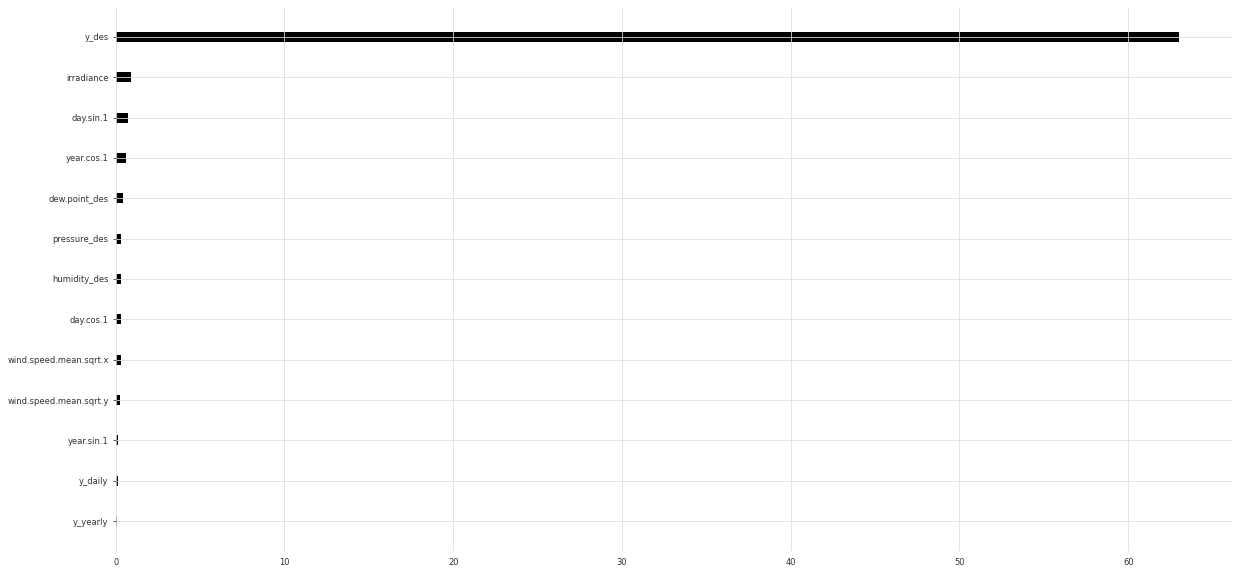

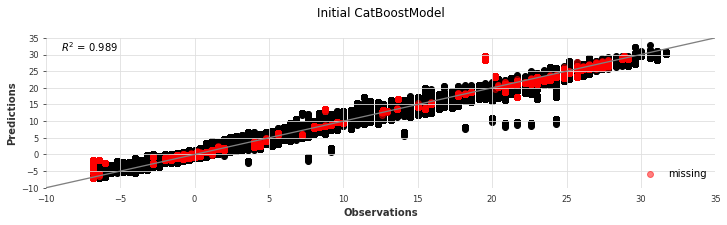

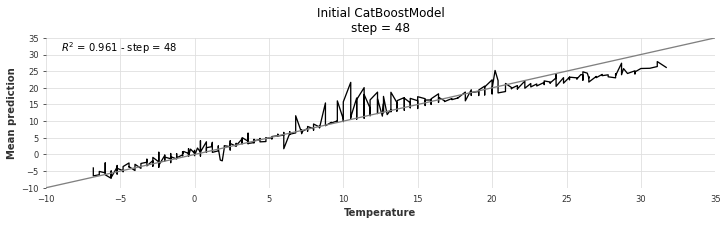

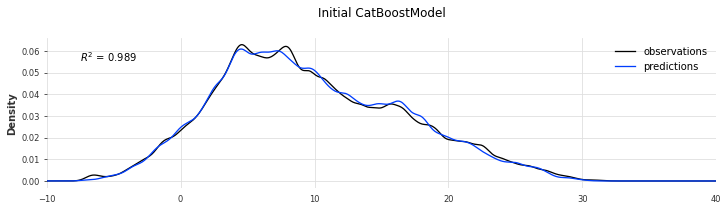

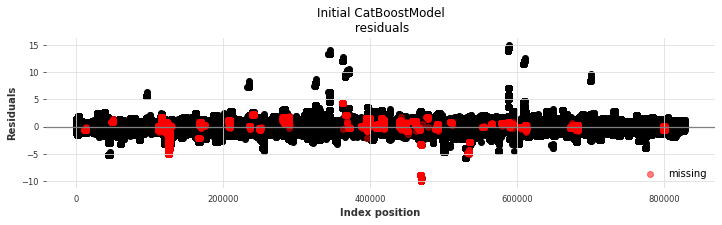

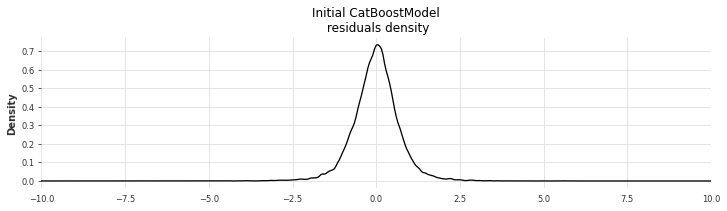

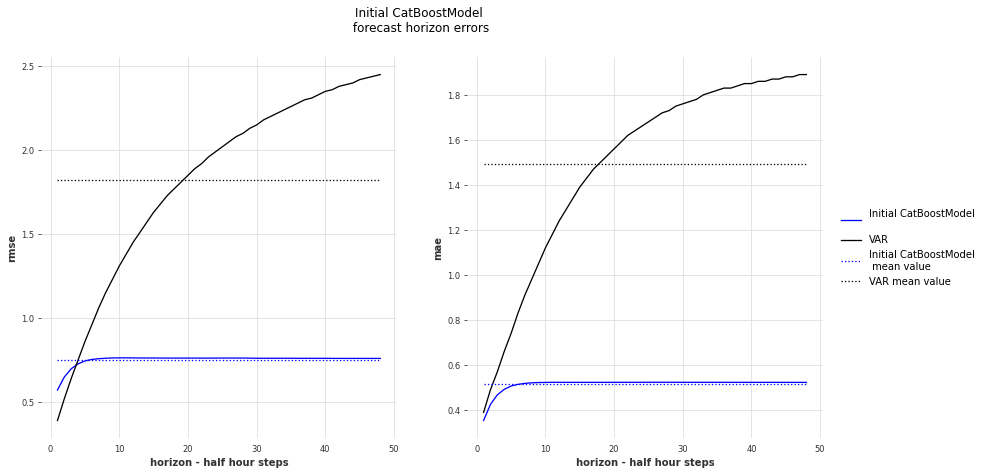

In [ ]:
plot_importances(model5, train_df, include_cols=inc_cols['feature'], exclude_cols = ex_cols)             
plot_obs_vs_preds(hist_comp5, title5)
plot_obs_vs_mean_preds_by_step(hist_comp5, title5)
plot_obs_preds_dists(hist_comp5, title5)
plot_residuals(hist_comp5, title5 + ' residuals')
plot_residuals_dist(hist_comp5, title5 + ' residuals density')
plot_horizon_metrics(hist_comp5, title5)
# plot_forecast_examples(hist_comp5, title5 + ' forecast examples')

... 

`y_des` and `irradiance` 

...

---

Build initial `y_des` and `irradiance` only model:

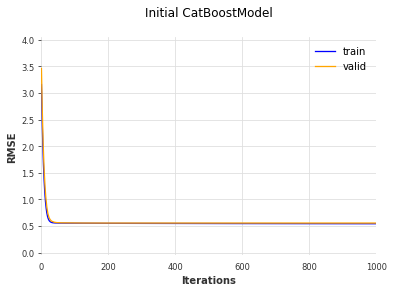

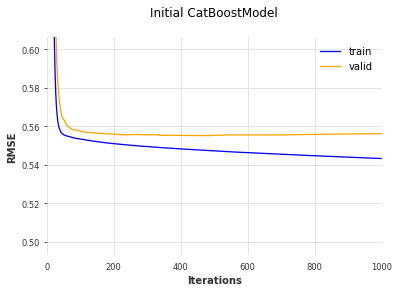

100%|██████████| 17263/17263 [17:21<00:00, 16.58it/s]


valid_df['y_des']:
count    16923.000000
mean        -0.366950
std          3.849934
min        -14.209171
25%         -2.839805
50%         -0.540260
75%          2.119017
max         14.288507
Name: y_des, dtype: float64



Backtest RMSE all: 0.84393
Backtest MAE all:  0.587124

# Backtest RMSE 48th: 0.852724
# Backtest MAE 48th:  0.595858

Backtest RMSE miss==0: 0.834281
Backtest MAE miss==0:  0.584189

Backtest RMSE miss==1: 1.565945
Backtest MAE miss==1:  0.902484


backtest['y_des']:
count	 801696
mean	 -0.394583
std	 3.690247
min	 -9.889972
25%	 -2.799876
50%	 -0.602385
75%	 2.042233
max	 11.919029
cols:
      feature  importance
2  irradiance    0.476091
1       y_des   43.356782
0       y_des   56.167126


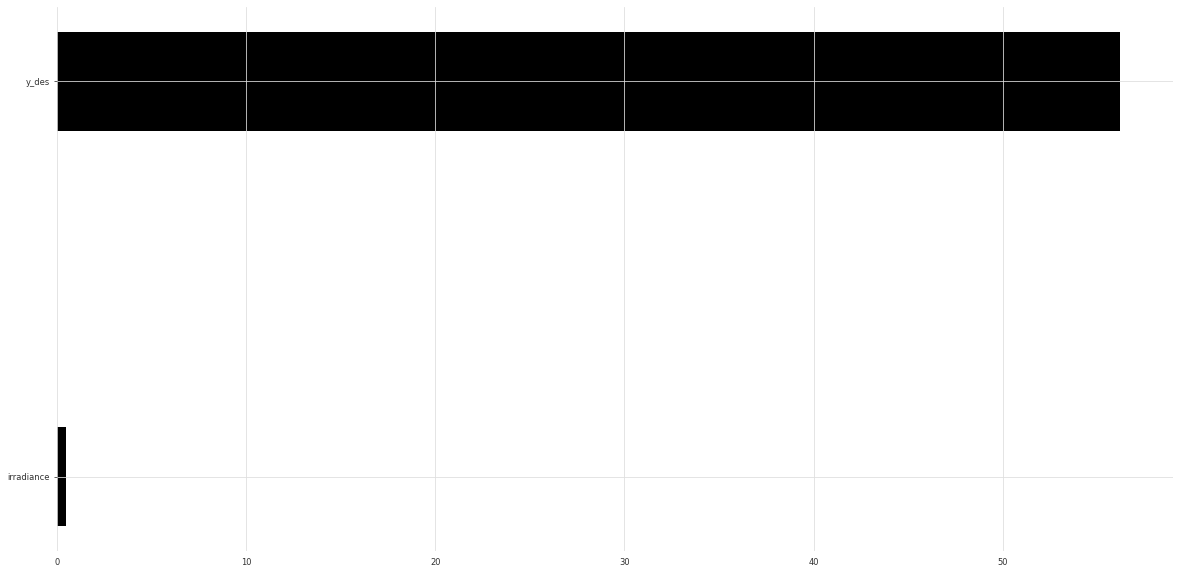

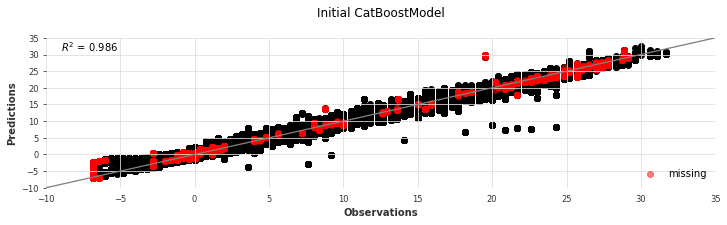

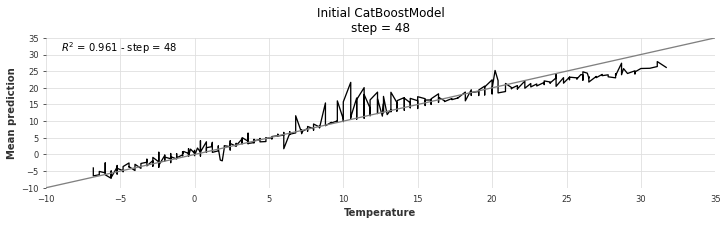

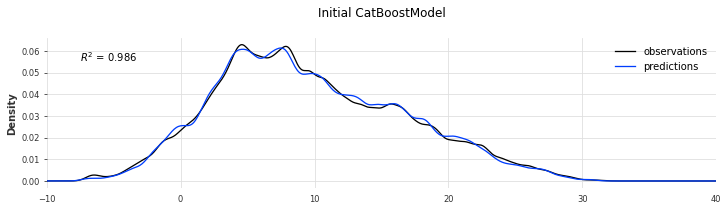

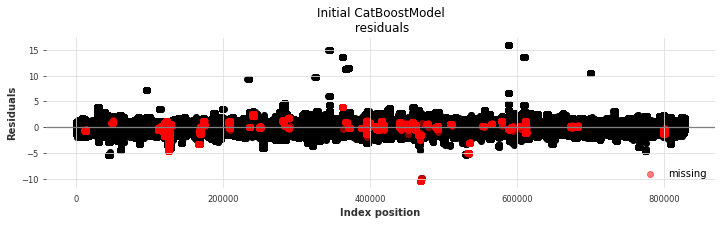

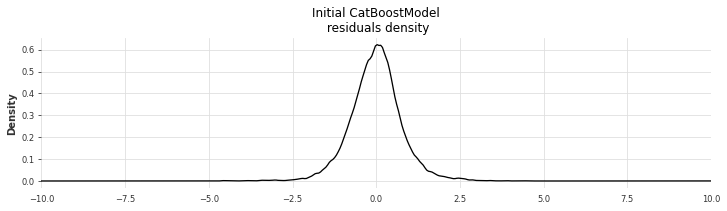

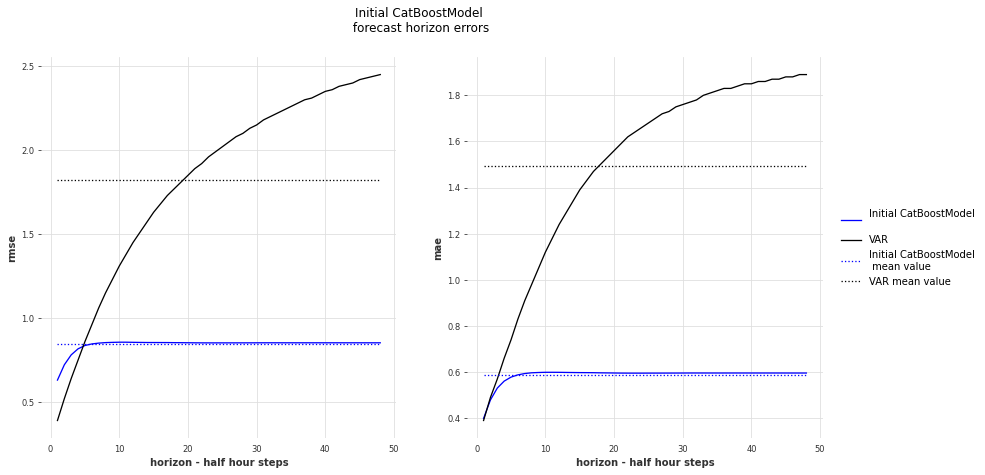

In [ ]:
series = TimeSeries.from_dataframe(train_df, value_cols=Y_COL)
past_cov = TimeSeries.from_dataframe(train_df.loc[:, ['y_des', 'irradiance']])
val_ser = TimeSeries.from_dataframe(valid_df, value_cols=Y_COL)
val_past_cov = TimeSeries.from_dataframe(valid_df.loc[:, ['y_des', 'irradiance']])
# target_lags  = [-1, -2, -22, -23, -24, -47, -48]
# pastcov_lags = [-1, -23, -24, -25]

model6 = CatBoostModel(lags = 1,
                       lags_past_covariates = 1)

model6.fit(series, 
           past_covariates = past_cov,
           val_series = val_ser,
           val_past_covariates = val_past_cov)
title6 = 'Initial CatBoostModel\n'
plot_catboost_learning_curve(model6, title6)
plot_catboost_learning_curve(model6, title6, margin=0.05)

backtest6 = model6.historical_forecasts(series = val_ser, 
                                       past_covariates = val_past_cov,
                                       start   = 0.01, 
                                       retrain = False,
                                       verbose = True, 
                                       forecast_horizon = HORIZON,
                                       last_points_only = False)

print("valid_df['", Y_COL, "']:\n", valid_df[Y_COL].describe(), "\n", sep='')
hist_comp6 = calculate_historic_comparison(backtest6, valid_df)
summarise_hist_comp(hist_comp6, valid_df)


plot_importances(model6, train_df, include_cols=['y_des', 'irradiance']) # , exclude_cols = ex_cols)             
plot_obs_vs_preds(hist_comp6, title6)
plot_obs_vs_mean_preds_by_step(hist_comp6, title6)
plot_obs_preds_dists(hist_comp6, title6)
plot_residuals(hist_comp6, title6 + ' residuals')
plot_residuals_dist(hist_comp6, title6 + ' residuals density')
plot_horizon_metrics(hist_comp6, title6)
# plot_forecast_examples(hist_comp6, title6 + ' forecast examples')

...

---

Optimise `y_des` plus `irradiance` and/or `za` model:

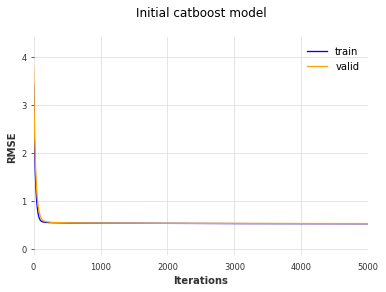

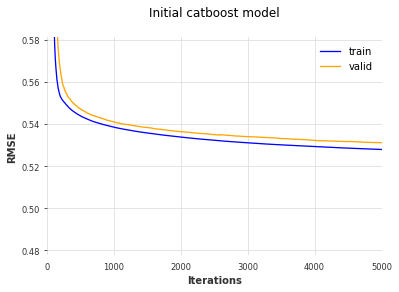

100%|██████████| 17263/17263 [19:48<00:00, 14.53it/s]




Backtest RMSE all: 0.725973
Backtest MAE all:  0.482074

# Backtest RMSE 48th: 0.72717
# Backtest MAE 48th:  0.485722

Backtest RMSE miss==0: 0.714272
Backtest MAE miss==0:  0.478634

Backtest RMSE miss==1: 1.52903
Backtest MAE miss==1:  0.851643


backtest['y_des']:
count	 801696
mean	 -0.404194
std	 3.720578
min	 -9.75922
25%	 -2.768653
50%	 -0.609411
75%	 2.000403
max	 11.972584

valid_df['y_des']:
count    16923.000000
mean        -0.366950
std          3.849934
min        -14.209171
25%         -2.839805
50%         -0.540260
75%          2.119017
max         14.288507
Name: y_des, dtype: float64



In [ ]:
#FUT_COV  = ['day.sin.1', 'day.cos.1', 'year.sin.1', 'year.cos.1', 'irradiance',
#            'y_daily', 'y_yearly']
#PAST_COV = ['dew.point_des', 'humidity_des', 'pressure_des', 
#            'wind.speed.mean.sqrt.x', 'wind.speed.mean.sqrt.y']
#FUT_COV  = ['y_daily', 'y_yearly']
PAST_COV = ['y_des', 'za']

series   = TimeSeries.from_dataframe(train_df, value_cols=Y_COL)
# past_cov = TimeSeries.from_dataframe(train_df[[Y_COL]])
past_cov = TimeSeries.from_dataframe(train_df.loc[:, PAST_COV])
#fut_cov  = TimeSeries.from_dataframe(train_df.loc[:, FUT_COV])

val_ser      = TimeSeries.from_dataframe(valid_df, value_cols=Y_COL)
# val_past_cov = TimeSeries.from_dataframe(valid_df[[Y_COL]])
val_past_cov = TimeSeries.from_dataframe(valid_df.loc[:, PAST_COV])
#val_fut_cov  = TimeSeries.from_dataframe(valid_df.loc[:, FUT_COV])

# target_lags  = [-1, -2, -22, -23, -24, -47, -48]
# pastcov_lags = [-1, -23, -24, -25]

# model_tr = LightGBMModel(lags = 1,
# model_tr = CatBoostModel(lags = 1,
#                          lags_past_covariates   = 1,
#                          lags_future_covariates = (1, 1)
#                         )
# model = LightGBMModel(lags = 1,
model = CatBoostModel(lags = 2,
                      lags_past_covariates = 2,
                      max_depth = 2,
                      n_estimators = 5000,
                     #lags_future_covariates = (1, 1)
                     )
# model_tr.fit(series, 
#              past_covariates       = past_cov,
#              future_covariates     = fut_cov,
#              val_series            = series,
#              val_past_covariates   = past_cov,
#              val_future_covariates = fut_cov,
#             #callbacks = [lgb.log_evaluation(0)]
#             )
model.fit(series, 
          past_covariates       = past_cov,
         #future_covariates     = fut_cov,
          val_series            = val_ser,
          val_past_covariates   = val_past_cov,
         #val_future_covariates = val_fut_cov,
         #callbacks = [lgb.log_evaluation(0)]
         )

title = 'Initial catboost model\n'
# title = 'Initial lightgbm model\n'
# models = [model_tr, model]
print("\n")
# plot_lgb_learning_curve(models, title)
# plot_lgb_learning_curve(models, title, margin = 0.05)
# plot_catboost_learning_curve(models, title)
# plot_catboost_learning_curve(models, title, margin = 0.05)
plot_catboost_learning_curve(model, title)
plot_catboost_learning_curve(model, title, margin = 0.05)
print("\n")

backtest = model.historical_forecasts(series = val_ser, 
                                      past_covariates = val_past_cov,
                                     #future_covariates = val_fut_cov,
                                      start   = 0.01, 
                                      retrain = False,
                                      verbose = True, 
                                      forecast_horizon = HORIZON,
                                      last_points_only = False
                                      )

hist_comp = calculate_historic_comparison(backtest, valid_df)
summarise_hist_comp(hist_comp, valid_df)
print("\nvalid_df['", Y_COL, "']:\n", valid_df[Y_COL].describe(), '\n', sep='')



# model = CatBoostModel(lags = 1, 
#                       past_cov_lags = 1,
#                       future_cov_lags = (1, 1))
# y_des series
# FUT_COV  = ['irradiance']
# PAST_COV = ['dew.point_des', 'humidity_des']
# Backtest RMSE 48th: 8.324057
# Backtest MAE 48th:  7.471046
# Worst model ever!

# model = CatBoostModel(lags = 1)
# only y_des
# no past_cov or fut_cov
# Backtest RMSE 48th: 3.474252
# Backtest MAE 48th:  2.577852
# no overfitting

# model = CatBoostModel(lags = 1, future_cov_lags = (1, 1))
# y_des series
# FUT_COV  = ['irradiance']
# Backtest RMSE 48th: 3.504235
# Backtest MAE 48th:  2.604671

# model = CatBoostModel(lags = 1, 
#                       past_cov_lags = 1,
#                       future_cov_lags = (1, 1))
# y_des series
# FUT_COV  = ['y_daily', 'y_yearly']
# PAST_COV = ['irradiance']
# Backtest RMSE 48th: 3.288044
# Backtest MAE 48th:  2.538138

# model = CatBoostModel(lags = 1, 
#                       past_cov_lags = 1)
# y_des series
# PAST_COV = ['irradiance']
# Backtest RMSE 48th: 3.236183
# Backtest MAE 48th:  2.456966

# model = CatBoostModel(lags = 1, 
#                       lags_past_covariates = 1, 
#                       lags_future_covariates = (1, 1))
# FUT_COV  = ['day.sin.1', 'day.cos.1', 'year.sin.1', 'year.cos.1', 'irradiance',
#             'y_daily', 'y_yearly']
# PAST_COV = ['y_des', 'dew.point_des', 'humidity_des', 'pressure_des', 
#             'wind.speed.mean.sqrt.x', 'wind.speed.mean.sqrt.y']
# Backtest RMSE 48th: 1.090365
# Backtest MAE 48th:  0.795913
# Clear overfitting but should be fixable

# model = CatBoostModel(lags = [-1, -2, -48], 
#                       past_cov_lags = [-1, -2, -48],
#                       max_depth = 2)
# y_des series
# PAST_COV = ['y_des', 'irradiance']
# Backtest RMSE 48th: 1.087608
# Backtest MAE 48th:  0.789923
# No overfitting

# model = CatBoostModel(lags = 1, 
#                       past_cov_lags = 1,
#                       max_depth = 4)
# y_des series
# PAST_COV = ['y_des', 'irradiance']
# Backtest RMSE 48th: 0.963096
# Backtest MAE 48th:  0.686289

# model = CatBoostModel(lags = 1, 
#                       past_cov_lags = 1,
#                       max_depth = 3)
# y_des series
# PAST_COV = ['y_des', 'irradiance']
# Backtest RMSE 48th: 0.919866
# Backtest MAE 48th:  0.664008
# No overfitting

# model = CatBoostModel(lags = 1, 
#                       past_cov_lags = 1)
# y_des series
# PAST_COV = ['y_des', 'irradiance', 'dew.point_des']
# Backtest RMSE 48th: 0.866685
# Backtest MAE 48th:  0.605214

# model = CatBoostModel(lags = 1, 
#                       past_cov_lags = 1)
# y_des series
# PAST_COV = ['y_des', 'irradiance', 'humidity_des']
# Backtest RMSE 48th: 0.86095
# Backtest MAE 48th:  0.601465

# model = CatBoostModel(lags = 1, 
#                       past_cov_lags = 1)
# y_des series
# PAST_COV = ['y_des', 'irradiance']
# Backtest RMSE 48th: 0.852724
# Backtest MAE 48th:  0.595858
# Co-linearity??
# Overfitting?

# model = CatBoostModel(lags = 3, 
#                       past_cov_lags = 3)
# y_des series
# PAST_COV = ['y_des', 'irradiance']
# Backtest RMSE 48th: 0.816748
# Backtest MAE 48th:  0.57059
# Overfitting :-(

# model = CatBoostModel(lags = 2, 
#                       past_cov_lags = 2)
# y_des series
# PAST_COV = ['y_des', 'irradiance']
# Backtest RMSE 48th: 0.792786
# Backtest MAE 48th:  0.545564
# Overfitting :-(

# model = CatBoostModel(lags = [-1, -2, -48], 
#                       past_cov_lags = [-1, -2, -48])
# y_des series
# PAST_COV = ['y_des', 'irradiance']
# Backtest RMSE 48th: 0.777291
# Backtest MAE 48th:  0.537376
# Overfitting :-(

# model = CatBoostModel(lags = [-1, -2, -24], 
#                       past_cov_lags = [-1, -2, -24],
#                       max_depth = 5)
# y_des series
# PAST_COV = ['y_des', 'irradiance']
# Backtest RMSE 48th: 0.776923
# Backtest MAE 48th:  0.524069
# No overfitting

# model = CatBoostModel(lags = [-1, -2, -24, -48], 
#                       past_cov_lags = [-1, -2, -24, -48],
#                       max_depth = 4)
# y_des series
# PAST_COV = ['y_des', 'irradiance']
# Backtest RMSE 48th: 0.771989
# Backtest MAE 48th:  0.528744
# No overfitting

# model = CatBoostModel(lags = [-1, -2, -24, -48], 
#                       past_cov_lags = [-1, -2, -24, -48],
#                       max_depth = 3)
# y_des series
# PAST_COV = ['y_des', 'irradiance']
# Backtest RMSE 48th: 0.806533
# Backtest MAE 48th:  0.556291

# model = CatBoostModel(lags = [-1, -2, -24], 
#                       past_cov_lags = [-1, -2, -24],
#                       max_depth = 4)
# y_des series
# PAST_COV = ['y_des', 'irradiance']
# Backtest RMSE 48th: 0.775002
# Backtest MAE 48th:  0.514915
# No overfitting


# model = CatBoostModel(lags = 2, 
#                       past_cov_lags = 2,
#                       max_depth = 3)
# y_des series
# PAST_COV = ['y_des', 'irradiance']
# Backtest RMSE 48th: 0.857354
# Backtest MAE 48th:  0.602878
# Overfitting pretty much all gone and still slowly learning
# Increase iterations to 1,400 or 1,600

# model = CatBoostModel(lags = 2, 
#                       past_cov_lags = 2,
#                       max_depth = 1,
#                       n_estimators = 5000)
# y_des series
# PAST_COV = ['y_des', 'irradiance']
# Backtest RMSE 48th: 0.827463
# Backtest MAE 48th:  0.573537

# model = CatBoostModel(lags = 2, 
#                       past_cov_lags = 2,
#                       max_depth = 3,
#                       n_estimators = 2000
# y_des series
# PAST_COV = ['y_des', 'irradiance']
# Backtest RMSE 48th: 0.821162
# Backtest MAE 48th:  0.567699

# model = CatBoostModel(lags = 3, 
#                       past_cov_lags = 3,
#                       max_depth = 4)
# y_des series
# PAST_COV = ['y_des', 'irradiance']
# Backtest RMSE 48th: 0.758379
# Backtest MAE 48th:  0.520362
# train learning curve crosses valid learning curve twice!
# Probably don't want these 2 crossings :-(

# model = CatBoostModel(lags = 2, 
#                       past_cov_lags = 2,
#                       max_depth = 2,
#                       n_estimators = 5000)
# y_des series
# PAST_COV = ['y_des', 'irradiance', 'declination']
# Backtest RMSE 48th: 0.797156
# Backtest MAE 48th:  0.544406
# Including declination does not improve results
# Probably overfitting

# model = CatBoostModel(lags = 2, 
#                       past_cov_lags = 2,
#                       max_depth = 2,
#                       n_estimators = 5000)
# y_des series
# PAST_COV = ['y_des', 'za', 'irradiance']
# Backtest RMSE 48th: 0.756133
# Backtest MAE 48th:  0.526587

# model = CatBoostModel(lags = 2, 
#                       past_cov_lags = 2,
#                       max_depth = 2,
#                       n_estimators = 5000)
# y_des series
# PAST_COV = ['y_des', 'za_rad', 'irradiance']
# Backtest RMSE 48th: 0.756133
# Backtest MAE 48th:  0.526587
# Early signs of overfitting

# model = CatBoostModel(lags = 2, 
#                       past_cov_lags = 2,
#                       max_depth = 2,
#                       n_estimators = 5000)
# y_des series
# PAST_COV = ['y_des', 'irradiance']
# Backtest RMSE 48th: 0.746428
# Backtest MAE 48th:  0.504856
# Remarkably good result and no overfitting :-)

# model = CatBoostModel(lags = 2, 
#                       past_cov_lags = 2,
#                       max_depth = 2,
#                       n_estimators = 5000)
# y_des series
# PAST_COV = ['y_des', 'za']
# Backtest RMSE 48th: 0.72717
# Backtest MAE 48th:  0.485722
# Best so far :-)

# model = CatBoostModel(lags = 2, 
#                       past_cov_lags = 2,
#                       max_depth = 2,
#                       n_estimators = 5000)
# y_des series
# PAST_COV = ['y_des', 'za_rad']
# Backtest RMSE 48th: 0.72717
# Backtest MAE 48th:  0.485722
# Unsurprisingly, the same as above

# model = CatBoostModel(lags = 4, 
#                       past_cov_lags = 4,
#                       max_depth = 4)
# y_des series
# PAST_COV = ['y_des', 'irradiance']
# Backtest RMSE 48th: 0.737195
# Backtest MAE 48th:  0.494465
# train learning curve crosses valid learning curve twice!
# Probably don't want these 2 crossings :-(

# model = CatBoostModel(lags = 2, 
#                       past_cov_lags = 2,
#                       max_depth = 4)
# y_des series
# PAST_COV = ['y_des', 'irradiance']
# Backtest RMSE 48th: 0.731943
# Backtest MAE 48th:  0.49085
# Minor overfitting


#model = CatBoostModel(lags = 48,
#                      lags_past_covariates = 24)
#[      'y_des', 'humidity', 'pressure', 'dew.point',
#       'mixing_ratio', 'ah', 'wind.x', 'wind.y', 'day.sin.1', 'day.cos.1',
#       'year.sin.1', 'year.cos.1', 'y_des_abs', 'dew.point_abs', 'wind.x_abs',
#       'wind.y_abs', 'y_des_square', 'humidity_square', 'pressure_square',
#       'dew.point_square', 'wind.x_square', 'wind.y_square', 'missing',
#       'known_inaccuracy', 'isd_outlier', 'long_run', 'spike', 'cooksd_out',
#       'isd_3_sigma', 'isd_filled', 'hist_average', 'mi_filled',
#       'mi_spike_interp', 'lin_interp']
# Backtest RMSE: 2.456602
# Backtest MAE:  1.202463

#model = CatBoostModel(lags = 48,
#                      lags_past_covariates = 24)
#[      'y_des', 'humidity', 'pressure', 'dew.point',
#       'mixing_ratio', 'ah', 'wind.x', 'wind.y', 'day.sin.1', 'day.cos.1',
#       'year.sin.1', 'year.cos.1', 'y_des_shadow', 'humidity_shadow',
#       'pressure_shadow', 'dew.point_shadow', 'wind.x_shadow', 'wind.y_shadow',
#       'y_des_abs', 'dew.point_abs', 'wind.x_abs', 'wind.y_abs',
#       'y_des_square', 'humidity_square', 'pressure_square',
#       'dew.point_square', 'wind.x_square', 'wind.y_square', 'day_spline_0',
#       'day_spline_1', 'day_spline_2', 'day_spline_3', 'day_spline_4',
#       'day_spline_5', 'day_spline_6', 'day_spline_7', 'day_spline_8',
#       'day_spline_9', 'day_spline_10', 'day_spline_11', 'year_spline_0',
#       'year_spline_1', 'year_spline_2', 'year_spline_3', 'year_spline_4',
#       'year_spline_5', 'year_spline_6', 'year_spline_7', 'year_spline_8',
#       'year_spline_9', 'year_spline_10', 'year_spline_11', 'missing',
#       'known_inaccuracy', 'isd_outlier', 'long_run', 'spike', 'cooksd_out',
#       'isd_3_sigma', 'isd_filled', 'hist_average', 'mi_filled',
#       'mi_spike_interp', 'lin_interp']
# Backtest RMSE: 2.447137
# Backtest MAE:  1.213873

...

---

Plot diagnostics:

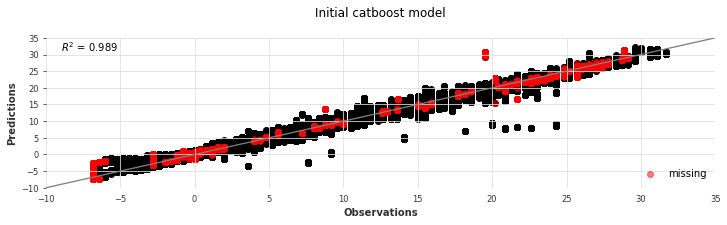

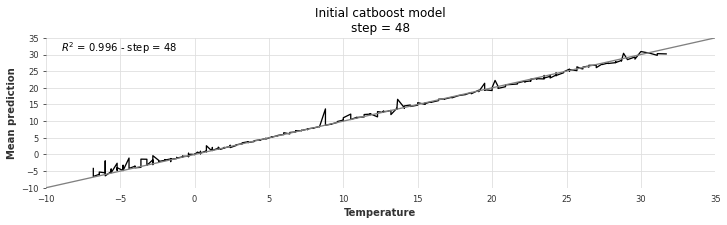

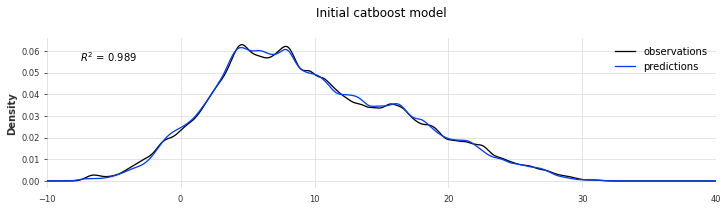

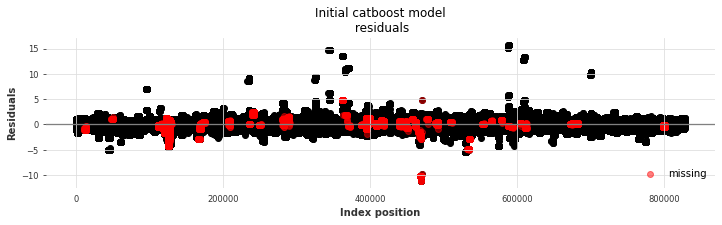

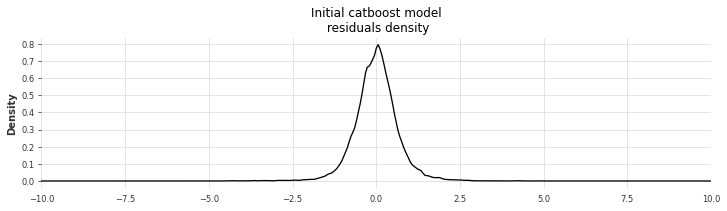

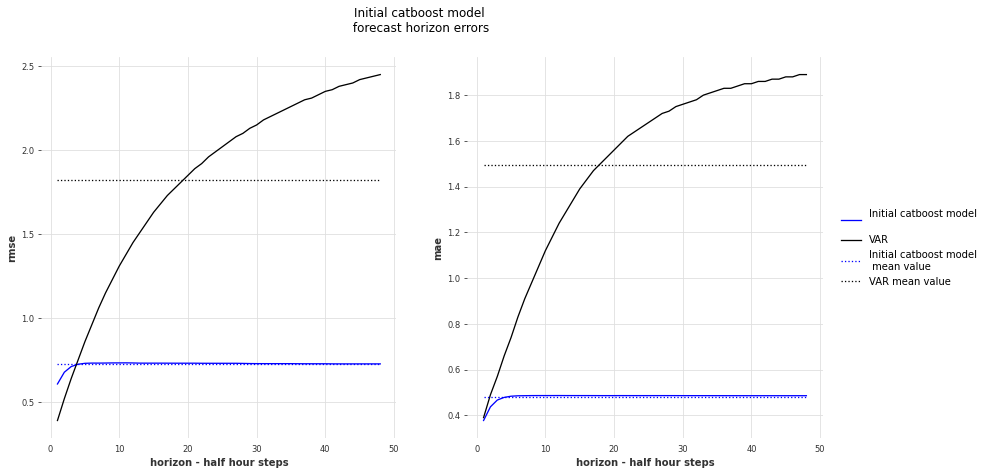

In [ ]:
plot_obs_vs_preds(hist_comp, title)
plot_obs_vs_mean_preds_by_step(hist_comp, title)
plot_obs_preds_dists(hist_comp, title)
plot_residuals(hist_comp, title + ' residuals')
plot_residuals_dist(hist_comp, title + ' residuals density')
plot_horizon_metrics(hist_comp, title)
# plot_forecast_examples(hist_comp, title + ' forecast examples')

...

---

Clearly overfitting on the learning curve.

Try reducing the number of trees (n_estimators):

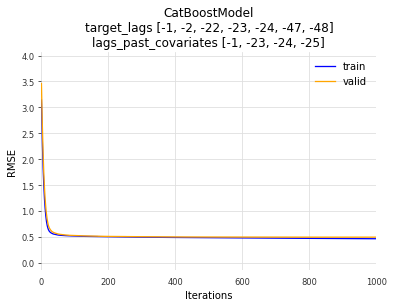

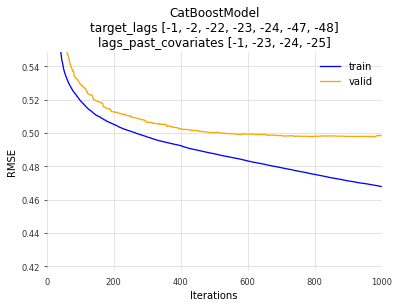

100%|██████████| 17263/17263 [26:03<00:00, 11.04it/s]


valid_df['y_des']:
count    16923.000000
mean        -0.309395
std          3.822988
min        -14.034760
25%         -2.770027
50%         -0.485923
75%          2.161211
max         14.355653
Name: y_des, dtype: float64



Backtest RMSE all: 2.153473
Backtest MAE all:  1.438785

# Backtest RMSE 48th: 2.384447
# Backtest MAE 48th:  1.666766

Backtest RMSE miss==0: 2.143231
Backtest MAE miss==0:  1.433248

Backtest RMSE miss==1: 3.060367
Backtest MAE miss==1:  2.033787


backtest['y_des']:
count	 801696
mean	 -0.514636
std	 3.509038
min	 -11.700672
25%	 -2.578714
50%	 -0.548931
75%	 1.710736
max	 12.526088


In [ ]:
model6 = CatBoostModel(lags = target_lags,
                       lags_past_covariates = pastcov_lags,
                      )

model6.fit(series, 
           past_covariates = past_cov,
           val_series = val_ser,
           val_past_covariates = val_past_cov)
title6 = 'CatBoostModel\n' + 'target_lags ' + str(target_lags) + \
         '\nlags_past_covariates ' + str(pastcov_lags)
plot_catboost_learning_curve(model6, title6)
plot_catboost_learning_curve(model6, title6, margin=0.05)

backtest6 = model6.historical_forecasts(series = val_ser, 
                                       past_covariates = val_past_cov,
                                       start   = 0.01, 
                                       retrain = False,
                                       verbose = True, 
                                       forecast_horizon = HORIZON,
                                       last_points_only = False)

print("valid_df['", Y_COL, "']:\n", valid_df[Y_COL].describe(), "\n", sep='')
hist_comp6 = calculate_historic_comparison(backtest6, valid_df)
summarise_hist_comp(hist_comp6, valid_df)



# Previously
# Backtest RMSE 48th: 0.677639
# Backtest MAE 48th:  0.45948

# Deseasonal y, humidity, dew.point
# Backtest RMSE 48th: 0.718218
# Backtest MAE 48th:  0.495263
# Still overfitting but less so

...

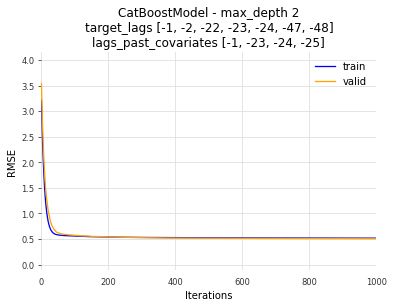

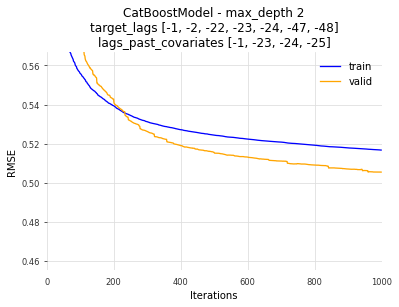

100%|██████████| 17263/17263 [25:35<00:00, 11.24it/s]


valid_df['y_des']:
count    16923.000000
mean        -0.309395
std          3.822988
min        -14.034760
25%         -2.770027
50%         -0.485923
75%          2.161211
max         14.355653
Name: y_des, dtype: float64



Backtest RMSE all: 2.113318
Backtest MAE all:  1.547757

# Backtest RMSE 48th: 2.315648
# Backtest MAE 48th:  1.781654

Backtest RMSE miss==0: 2.10391
Backtest MAE miss==0:  1.541949

Backtest RMSE miss==1: 2.954531
Backtest MAE miss==1:  2.171794


backtest['y_des']:
count	 801696
mean	 -0.45379
std	 3.359116
min	 -11.302231
25%	 -2.472439
50%	 -0.476459
75%	 1.659213
max	 12.83278


In [ ]:
max_d = 2
model7 = CatBoostModel(lags = target_lags,
                       lags_past_covariates = pastcov_lags,
                       max_depth = max_d)

model7.fit(series, 
           past_covariates = past_cov,
           val_series = val_ser,
           val_past_covariates = val_past_cov)
title7 = 'CatBoostModel - max_depth ' + str(max_d) + '\n' + \
         'target_lags ' + str(target_lags) + \
         '\nlags_past_covariates ' + str(pastcov_lags)
plot_catboost_learning_curve(model7, title7)
plot_catboost_learning_curve(model7, title7, margin=0.05)

backtest7 = model7.historical_forecasts(series = val_ser, 
                                        past_covariates = val_past_cov,
                                        start   = 0.01, 
                                        retrain = False,
                                        verbose = True, 
                                        forecast_horizon = HORIZON,
                                        last_points_only = False)

print("valid_df['", Y_COL, "']:\n", valid_df[Y_COL].describe(), "\n", sep='')
hist_comp7 = calculate_historic_comparison(backtest7, valid_df)
summarise_hist_comp(hist_comp7, valid_df)



# Previously
# Backtest RMSE 48th: 0.677639
# Backtest MAE 48th:  0.45948

# Deseasonal y, humidity, dew.point
# Backtest RMSE 48th: 0.718218
# Backtest MAE 48th:  0.495263
# Still overfitting but less so

This initial catboost model is clearly superior to all of the lightgbm models.
However the runtime has increased from approximately 5 mins to 13 mins.

|  model   | target_lag | past_cov_lag | 48th valid rmse | 48th valid mae |
|----------|------------|--------------|-----------------|----------------|
| catboost | 1	        | 1	           |	0.659983	     | 0.451157	      |
| lightgbm | 1	        | 1	           |	2.523787	     | 1.964767	      |

---

Plot diagnostics:

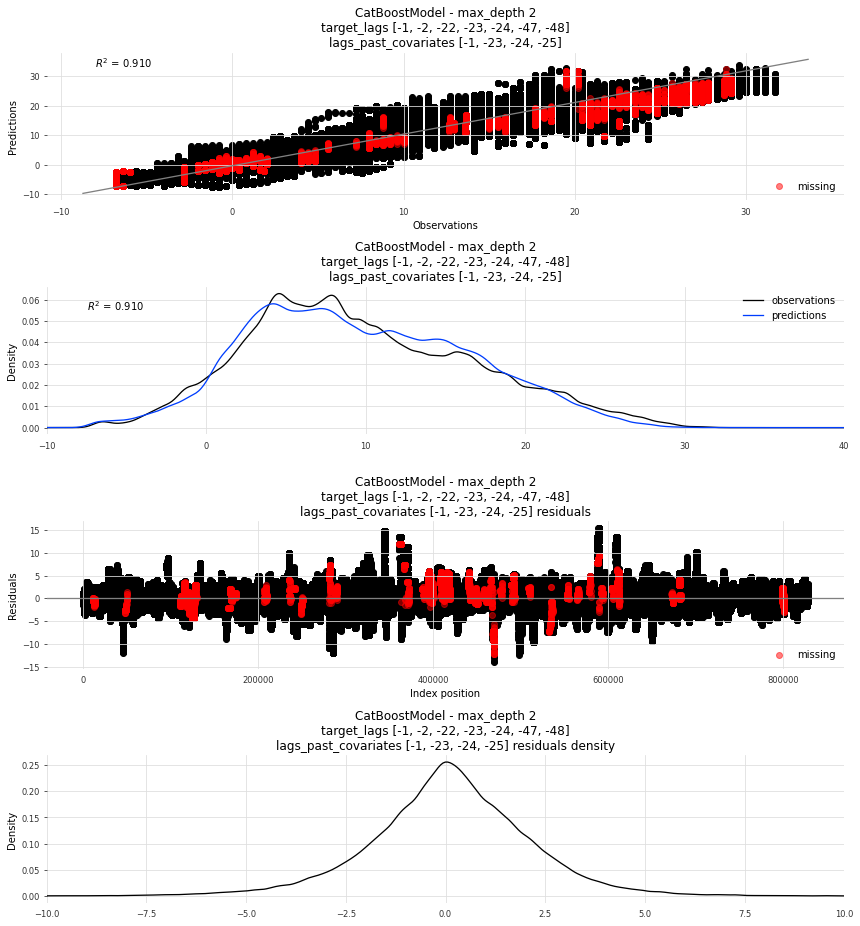

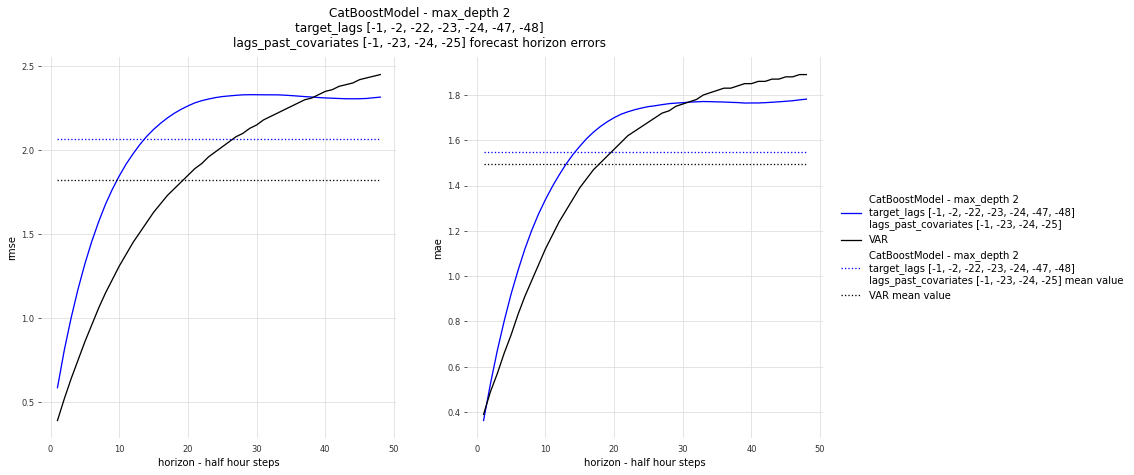

In [ ]:
plot_obs_vs_preds(hist_comp7, title7)
plot_obs_preds_dists(hist_comp7, title7)
plot_residuals(hist_comp7, title7 + ' residuals')
plot_residuals_dist(hist_comp7, title7 + ' residuals density')
plot_horizon_metrics(hist_comp7, title7)
# plot_forecast_examples(hist_comp7, title7 + ' forecast examples')

The forecast horizon plot shows the initial catboost model is clearly superior to the baseline VAR model.  However, the flatness of the catboost model and the large difference with the VAR model may indicate overfitting.

---

If overfitting is present then regularisation should help to lessen/prevent it.  The best parameter to regularise catboost models is `n_estimators` which is the number of trees built (default value 1,000).  See [catboost docs](https://catboost.ai/en/docs/references/training-parameters/common#iterations) for further details.

Here I try two extremely low values for `n_estimators`: 1 and 2.

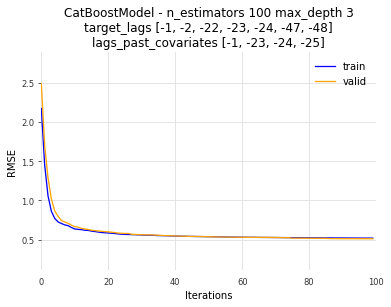

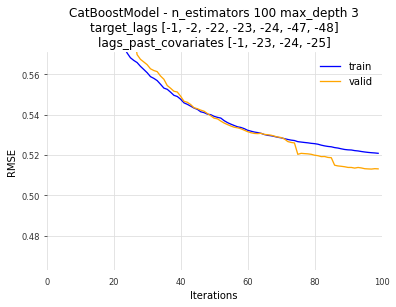

100%|██████████| 17263/17263 [36:07<00:00,  7.96it/s]




Backtest RMSE all: 2.338729
Backtest MAE all:  1.686968

# Backtest RMSE 48th: 2.630964
# Backtest MAE 48th:  2.011788

Backtest RMSE miss==0: 2.330256
Backtest MAE miss==0:  1.6813

Backtest RMSE miss==1: 3.117769
Backtest MAE miss==1:  2.296072


backtest['y_des']:
count	 801696
mean	 -0.469409
std	 3.412988
min	 -10.967603
25%	 -2.472506
50%	 -0.497071
75%	 1.578027
max	 14.216238


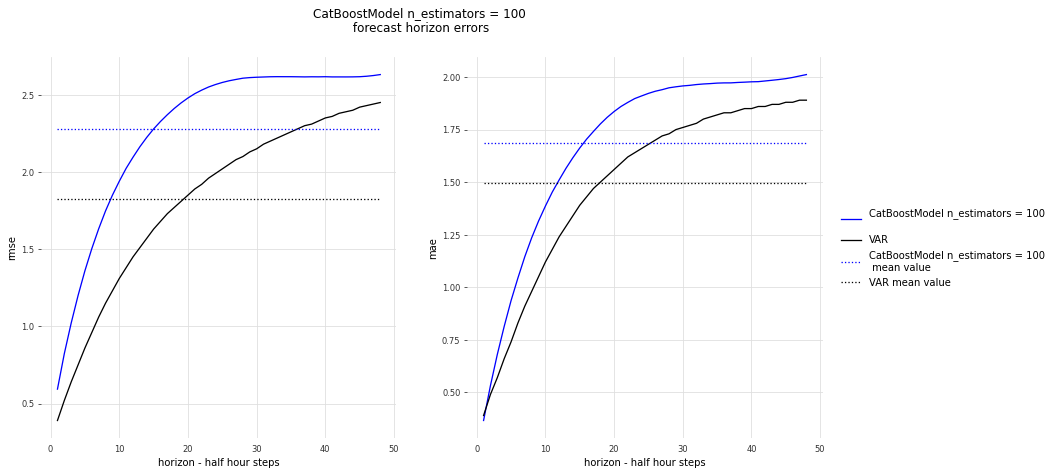

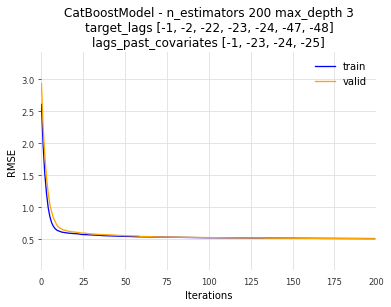

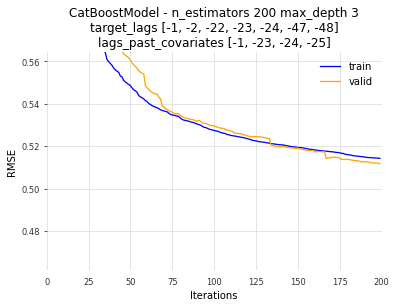

  4%|▍         | 675/17263 [01:30<37:03,  7.46it/s]


KeyboardInterrupt: ignored

In [ ]:
max_d = 3

for max_d in [1, 3]:
  model8 = CatBoostModel(lags = target_lags,
                         lags_past_covariates = pastcov_lags,
                         # n_estimators = n_est,
                         max_depth = max_d
                        )

  model8.fit(series, 
             past_covariates = past_cov,
             val_series = val_ser,
             val_past_covariates = val_past_cov)
  title8 = 'CatBoostModel - max_depth ' + str(max_d) + '\n' + \
           'target_lags ' + str(target_lags) + \
           '\nlags_past_covariates ' + str(pastcov_lags)
  plot_catboost_learning_curve(model8, title8)
  plot_catboost_learning_curve(model8, title8, margin=0.05)

  backtest8 = model8.historical_forecasts(series = val_ser, 
                                          past_covariates = val_past_cov,
                                          start   = 0.01, 
                                          retrain = False,
                                          verbose = True, 
                                          forecast_horizon = HORIZON,
                                          last_points_only = False)

  hist_comp8 = calculate_historic_comparison(backtest8, valid_df)
  summarise_hist_comp(hist_comp8, valid_df)
  title8 = 'CatBoostModel n_estimators = ' + str(n_est) + '\n'
  plot_horizon_metrics(hist_comp8, title8)
  print("\n\n")


# Default starting model above
# Backtest RMSE 48th: 0.659983
# Backtest MAE 48th:  0.451157
# Clearly overfitting

# max_depth   = 2,
# l2_leaf_reg = 5,
# Backtest RMSE 48th: 0.720456
# Backtest MAE 48th:  0.492479
# Still clearly overfitting

# max_depth    = 2,
# l2_leaf_reg  = 5,
# n_estimators = 200,
# Backtest RMSE 48th: 0.798144
# Backtest MAE 48th:  0.554892
# Still clearly overfitting

# max_depth    = 2,
# l2_leaf_reg  = 10,
# n_estimators = 100,
# Backtest RMSE 48th: 1.135996
# Backtest MAE 48th:  0.766384
# Still clearly overfitting despite much higher metrics

# max_depth    = 2,
# l2_leaf_reg  = 10,
# n_estimators = 50,
# Backtest RMSE 48th: 1.873379
# Backtest MAE 48th:  1.319863
# Higher mean rmse and mae but still flat!

# max_depth    = 1,
# l2_leaf_reg  = 20,
# n_estimators = 200,
# Backtest RMSE 48th: 1.017505
# Backtest MAE 48th:  0.695825
# Still very flat :-(


# max_depth    = 10,
# l2_leaf_reg  = 20,
# n_estimators = 200,
# Backtest RMSE 48th: 0.664518
# Backtest MAE 48th:  0.454226
# Flat :-(

# max_depth    = 10,
# l2_leaf_reg  = 200,
# n_estimators = 200,
# Backtest RMSE 48th: 0.679561
# Backtest MAE 48th:  0.464022


# l2_leaf_reg  = 200,
# Backtest RMSE 48th: 0.664198
# Backtest MAE 48th:  0.448039
# Flat

# l2_leaf_reg  = 2000,
# Backtest RMSE 48th: 0.681874
# Backtest MAE 48th:  0.464827
# Flat

# n_estimators = 2,
# Backtest RMSE 48th: 1.827069
# Backtest MAE 48th:  1.208621
# Little bit less flat
# VAR mean value and CatBoostModel mean value are close (CatBoostModel is lower)
# Probably the model that is most comparable to VAR/lightgbm

# n_estimators = 1,
# Backtest RMSE 48th: 2.502509
# Backtest MAE 48th:  1.900066
# Entirely above the VAR model

# max_depth    = 3,
# l2_leaf_reg  = 10,
# n_estimators = 2,
# Backtest RMSE 48th: 3.50903
# Backtest MAE 48th:  2.730899
# Way above the VAR model and very flat

# l2_leaf_reg  = 10,
# n_estimators = 2,
# Backtest RMSE 48th: 3.435778
# Backtest MAE 48th:  2.662379
# Way above the VAR model and very flat



When `n_estimators` = 1 the forecast horizon is entirely above the VAR model for both mse and mae.

When `n_estimators` = 2 the mean of the mse across the horizon values is similar to the mean for the VAR model.

The flatness of the forecast horizons persists for both of the extremely low `n_estimators` values (mse and mae).

No point plotting learning curves when there are only 1 or 2 estimators (iterations).

---

Another parameter to regularise catboost models is `max_depth` which is the depth of trees built (default value 6). See [catboost docs](https://catboost.ai/en/docs/references/training-parameters/common#depth) for further details.

Here I try two low values for `max_depth`: 1 and 2.

100%|██████████| 17263/17263 [16:56<00:00, 16.98it/s]


Backtest RMSE all: 1.147094
Backtest MAE all:  0.838029

# Backtest RMSE 48th: 1.209437
# Backtest MAE 48th:  0.899289

Backtest RMSE miss==0: 1.141919
Backtest MAE miss==0:  0.836474

Backtest RMSE miss==1: 1.608981
Backtest MAE miss==1:  1.005134


backtest['y_des']:
count	 801696
mean	 -0.416003
std	 3.436016
min	 -9.512902
25%	 -2.481409
50%	 -0.692695
75%	 1.627042
max	 10.013161


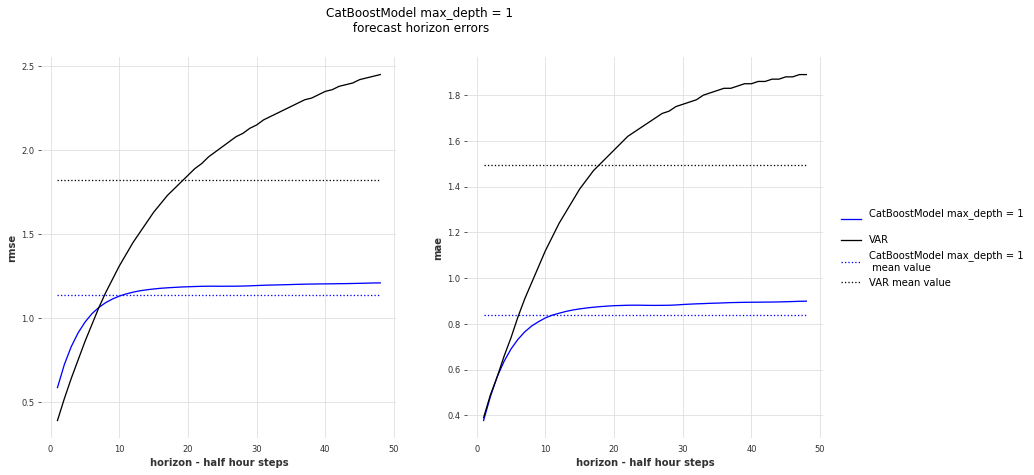

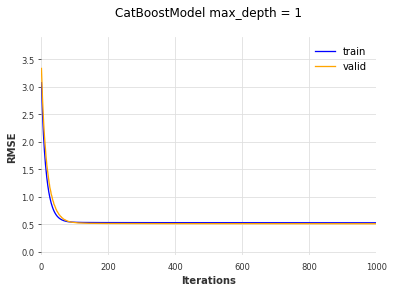

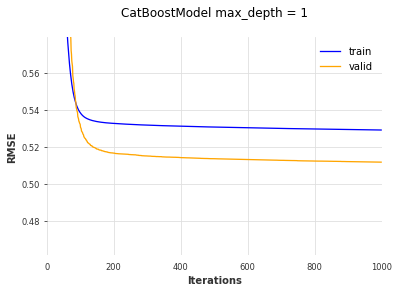

100%|██████████| 17263/17263 [17:04<00:00, 16.85it/s]


Backtest RMSE all: 0.779221
Backtest MAE all:  0.548126

# Backtest RMSE 48th: 0.787947
# Backtest MAE 48th:  0.55725

Backtest RMSE miss==0: 0.770323
Backtest MAE miss==0:  0.545478

Backtest RMSE miss==1: 1.445225
Backtest MAE miss==1:  0.83262


backtest['y_des']:
count	 801696
mean	 -0.390749
std	 3.423722
min	 -9.99258
25%	 -2.528091
50%	 -0.377385
75%	 1.708781
max	 10.355092


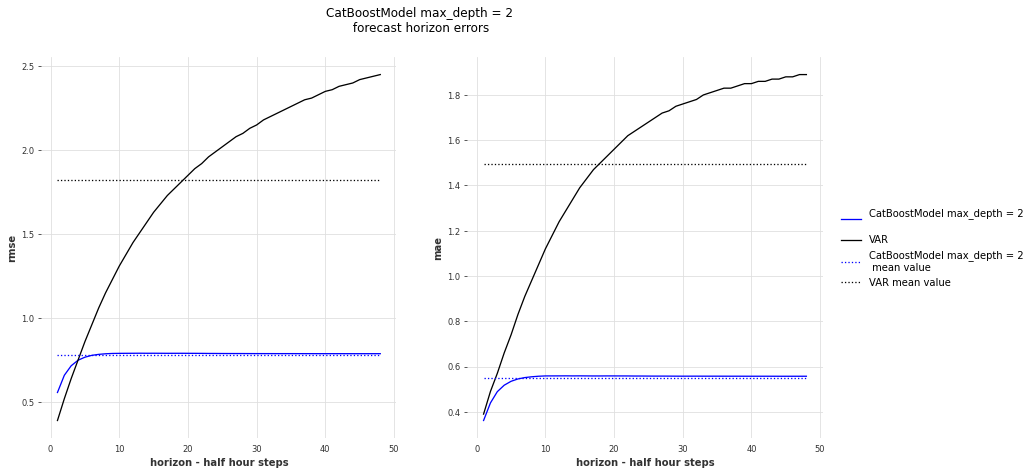

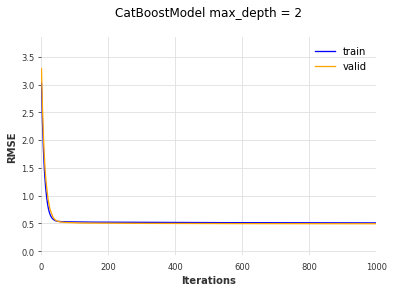

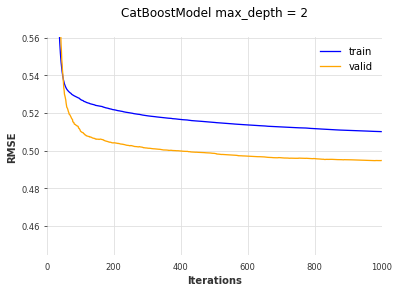

In [ ]:
for max_d in [1, 2]:
  model4 = CatBoostModel(lags = 1,
                         lags_past_covariates = 1,
                         max_depth = max_d,
                        )

  model4.fit(series, 
             past_covariates = past_cov,
             val_series = val_ser,
             val_past_covariates = val_past_cov)
  backtest4 = model4.historical_forecasts(series = val_ser, 
                                          past_covariates = val_past_cov,
                                          start   = 0.01, 
                                          retrain = False,
                                          verbose = True, 
                                          forecast_horizon = HORIZON,
                                          last_points_only = False)

  hist_comp4 = calculate_historic_comparison(backtest4, valid_df)
  summarise_hist_comp(hist_comp4, valid_df)
  title4 = 'CatBoostModel max_depth = ' + str(max_d) + '\n'
  plot_horizon_metrics(hist_comp4, title4)
  plot_catboost_learning_curve(model4, title4)
  plot_catboost_learning_curve(model4, title4, margin = 0.05)
  print("\n\n")

When `max_depth` equals 1 or 2 the forecast horizon is entirely below the VAR model but substantially above the initial catboost model for both mse and mae.

When `max_depth` = 1 the forecast horizon looks more reasonable for both mse and mae.

When `max_depth` = 2 the forecast horizon is again unrealisticaly flat.

Both learning curves look reasonable.

I don't show it here, but I also increased the `l2_leaf_reg` parameter.  It had a much smaller regularising effect.  See here for the relevant [catboost docs](https://catboost.ai/en/docs/references/training-parameters/common#l2_leaf_reg).

---

I briefly tried minimising `n_estimators` and `max_depth` together.

Here I show:
 * `n_estimators` 100
 * `max_depth` 4

100%|██████████| 17263/17263 [21:55<00:00, 13.12it/s]


Backtest RMSE all: 1.24717
Backtest MAE all:  0.826313

# Backtest RMSE 48th: 1.340434
# Backtest MAE 48th:  0.896625

Backtest RMSE miss==0: 1.239273
Backtest MAE miss==0:  0.82249

Backtest RMSE miss==1: 1.914522
Backtest MAE miss==1:  1.237134


backtest['y_des']:
count	 801696
mean	 -0.251192
std	 3.547629
min	 -12.277453
25%	 -2.245599
50%	 -0.543505
75%	 1.979674
max	 12.899214


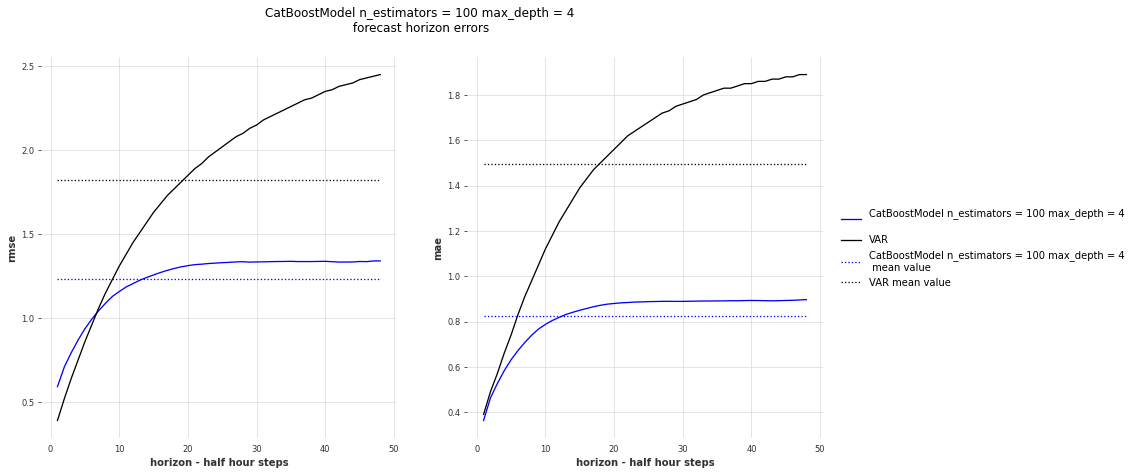

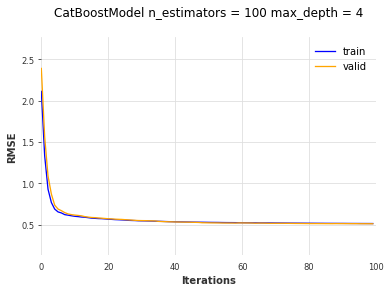

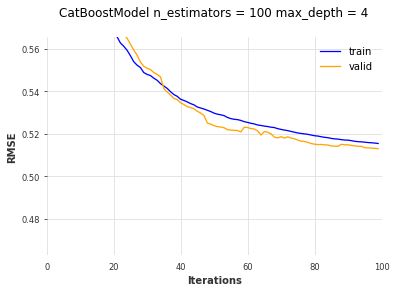

In [ ]:
n_est = 100
md    = 4

model6 = CatBoostModel(lags = 1,
                       lags_past_covariates = 1,
                       n_estimators = n_est,
                       max_depth    = md)

model6.fit(series, 
           past_covariates = past_cov,
           val_series = val_ser,
           val_past_covariates = val_past_cov)
backtest6 = model6.historical_forecasts(series = val_ser, 
                                        past_covariates = val_past_cov,
                                        start   = 0.01, 
                                        retrain = False,
                                        verbose = True, 
                                        forecast_horizon = HORIZON,
                                        last_points_only = False)

hist_comp6 = calculate_historic_comparison(backtest6, valid_df)
summarise_hist_comp(hist_comp6, valid_df)
title6 = 'CatBoostModel n_estimators = ' + str(n_est) + \
         ' max_depth = ' + str(md) + '\n'
plot_horizon_metrics(hist_comp6, title6)
plot_catboost_learning_curve(model6, title6)
plot_catboost_learning_curve(model6, title6, margin=0.05)

This is a large reduction in the number of catboost parameters.  Capacity for overfitting should be greatly reduced but it may not be entirely eliminated.  The learning curve looks reasonable.  The obvious overfitting has been eliminated.  It may be possible to further optimise the catboost models.

---

Next, plot model diagnostics:

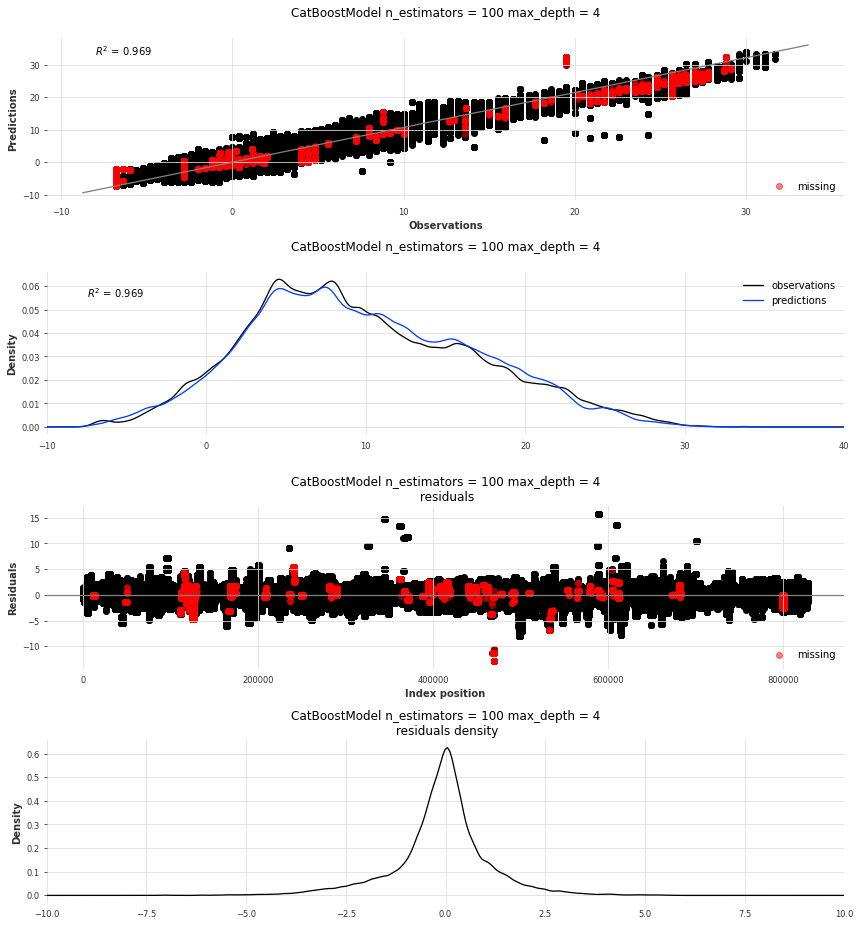

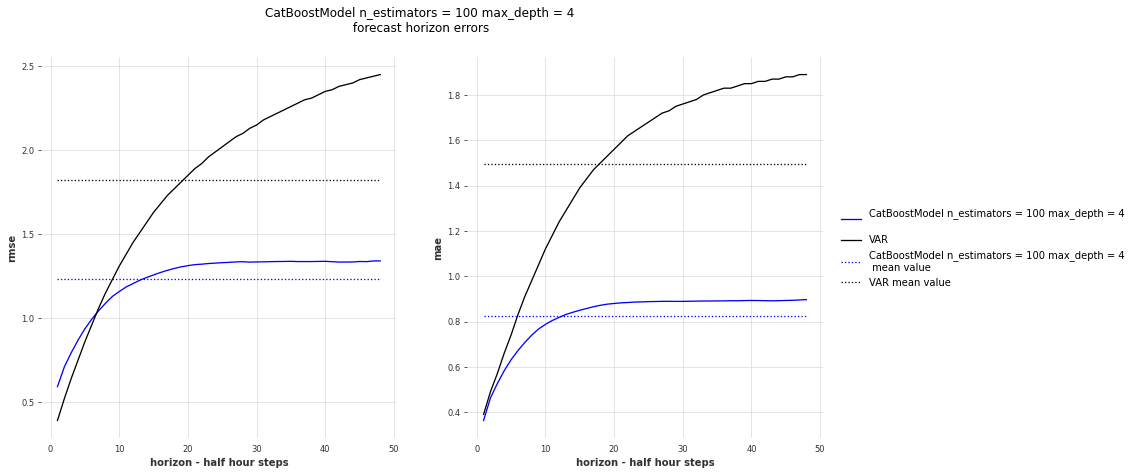

In [ ]:
plot_obs_vs_preds(hist_comp6, title6)
plot_obs_preds_dists(hist_comp6, title6)
plot_residuals(hist_comp6, title6 + ' residuals')
plot_residuals_dist(hist_comp6, title6 + ' residuals density')
plot_horizon_metrics(hist_comp6, title6)
# plot_forecast_examples(hist_comp6, title6 + ' forecast examples')


The catboost model remains substantially better than the VAR and lightgbm models.

#### Lag selection

Not doing this

Explain why


---

#### Hyperparameter tuning 

Not doing this

Explain why


---


### Comparison with baselines

Finally, we can compare the best performing gradient boosted etc models against the best baseline method.  The VAR (Vector Auto-Regression) model from the [baselines notebook](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/cammet_baselines_2021.ipynb) was the best performing baseline.

The best encoder decoder model, after 5 training epochs, was conv2dk2d_28l_48s_16bs_448fm_64f_1ksf_7kst.  Here I train the same model for 20 epochs.

Some points to note regarding the `plot_forecasts` diagnostic plot:
 * on validation data not test data
 * `plot_forecasts`
   * plot example forecasts with observations and lagged temperatures
      * first row shows examples of best near zero rmse forecasts
      * second row shows examples of worst positive rmse forecasts
      * third row shows examples of worst negative rmse forecasts
      * lagged observations are negative
      * the day of the year the forecast begins in and the rmse value is displayed above each sub-plot

In [24]:
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, medianabs


def plot_metrics(metrics, main_title):
  fig, axs = plt.subplots(1, 2, figsize = (14, 7))
  fig.suptitle(main_title)
  axs = axs.ravel()  # APL ftw!

  methods = metrics.method.unique()

  for method in methods:
    met_df = metrics.query('metric == "rmse" & method == "%s"' % method)
    axs[0].plot(met_df.horizon, met_df.value)
  axs[0].set_xlabel("horizon - hours")
  axs[0].set_ylabel("rmse")
  axs[0].legend(methods)

  for method in methods:
    met_df = metrics.query('metric == "mae" & method == "%s"' % method)
    axs[1].plot(met_df.horizon, met_df.value)
  axs[1].set_xlabel("horizon - hours")
  axs[1].set_ylabel("mae")
  axs[1].legend(methods)
  plt.show()


def update_metrics(metrics, test_data, method, get_metrics, 
                   model = None, 
                   met_cols = ['type', 'method', 'metric', 'horizon', 'value']):
  metrics_h = []

  if method in ['SES', 'HWES', 'VAR']:
    horizons = [i for i in range(4, 49, 4)]
    horizons.insert(0, 1)
  else:
    horizons = range(1, 49)

  if method in ['VAR']:
    variates = 'multivariate'
  else:
    variates = 'univariate'

  print("h\trmse\tmae")
  for h in horizons:
    if method in ['VAR']:
      rmse_h, mae_h = get_metrics(test_df, h, method, model)
    else:
      rmse_h, mae_h = get_metrics(test_df, h, method)

    metrics_h.append(dict(zip(met_cols, [variates, method, 'rmse', h, rmse_h])))
    metrics_h.append(dict(zip(met_cols, [variates, method,  'mae', h,  mae_h])))
    
    #if h in [1, 4, 48]:
    #  print(h, "\t", round(rmse_h, 2), "\t", round(mae_h, 2))

  print("\n")

  metrics_method = pd.DataFrame(metrics_h, columns = met_cols)
  metrics = metrics.append(metrics_method)

  return metrics


# rolling_cv with pre-trained model
def var_rolling_cv(data, horizon, method, model):
    lags = model.k_ar  # lag order
    i = lags
    h = horizon
    rmse_roll, mae_roll = [], []
    endo_vars = ['y', 'za_rad', 'irradiance']
    #endo_vars = ['y', 'za_rad', 'dew.point_des', 'pressure_des', 
    #             'humidity_des','irradiance', 'wind.speed.mean.sqrt.x', 
    #             'wind.speed.mean.sqrt.y',
    #             'day.cos.1', 'day.sin.1', 'year.cos.1', 'year.sin.1', 
    #             'y_yearly', 'y_daily']
    #endo_vars = ['y', 'za_rad', 'dew.point_des', 'pressure_des', 
    #             'humidity_des','irradiance', 'wind.speed.mean.sqrt.x', 
    #             'wind.speed.mean.sqrt.y'] 
    #exog_vars = ['day.cos.1', 'day.sin.1', 'year.cos.1', 'year.sin.1', 
    #             'y_yearly', 'y_daily']
    # endo_vars = ['y', 'humidity', 'dew.point', 'pressure']
    # exog_vars = ['day.cos', 'day.sin', 'year.cos', 'year.sin']
    # print("\ti:", i, "\th:", h, "\tlags:", lags)  # DEBUG

    while (i + h) < len(data):
        test_df = data[endo_vars].iloc[i:(i + h)]
        endo_df = data[endo_vars].iloc[(i - lags):i].values
        # exog_df = data[exog_vars].iloc[i:(i + h)]
        #print("\tendo:", endo_df.shape, "\texog:", exog_df.shape)  # DEBUG
        # display(endo_df)  # DEBUG

        y_hat = model.forecast(endo_df, steps = h)
        # y_hat = model.forecast(endo_df, exog_future = exog_df, steps = h)
        #print("yhat:", y_hat)  # DEBUG

        preds = pd.DataFrame(y_hat, columns = endo_vars)
        #print(preds)

        rmse_i = rmse(test_df.y,      preds.y)
        mae_i  = medianabs(test_df.y, preds.y)
        # print("i:", i, "rmse:", rmse_i, "\nmae:", mae_i, "\n")  # DEBUG
        rmse_roll.append(rmse_i)
        mae_roll.append(mae_i)

        i = i + 1

    print(h, '\t', np.nanmean(rmse_roll).round(3), '\t', np.nanmean(mae_roll).round(3))
   
    return [np.nanmean(rmse_roll).round(2), np.nanmean(mae_roll).round(2)]

In [25]:
train_df = train_df.asfreq(freq='30min')
valid_df = valid_df.asfreq(freq='30min')
test_df  = test_df.asfreq(freq='30min')

# train_df['y_orig'] = train_df['y']
# valid_df['y_orig'] = valid_df['y']
# test_df['y_orig']  = test_df['y']

train_df['y'] = train_df['y_des']
valid_df['y'] = valid_df['y_des']
test_df['y']  = test_df['y_des']

train_df.dropna(inplace=True)

# build model on 
#30              year.sin.1          64
#2                day.cos.1          67
#28                y_yearly          67
#9               irradiance          73
#29              year.cos.1         114
#26                 y_daily         152
#23  wind.speed.mean.sqrt.y         181
#19            pressure_des         181
#7             humidity_des         195
#22  wind.speed.mean.sqrt.x         197
#4            dew.point_des         206
#3                day.sin.1         213
#31                      za         382
#0                    y_des         764
#endo_vars = ['y', 'za_rad', 'dew.point_des', 'pressure_des', 'humidity_des',
#             'irradiance', 'wind.speed.mean.sqrt.x', 'wind.speed.mean.sqrt.y'] 
#exog_vars = ['day.cos.1', 'day.sin.1', 'year.cos.1', 'year.sin.1', 
#             'y_yearly', 'y_daily']
#endo_vars = ['y', 'za_rad', 'dew.point_des', 'pressure_des', 'humidity_des',
#             'irradiance', 'wind.speed.mean.sqrt.x', 'wind.speed.mean.sqrt.y', 
#             'day.cos.1', 'day.sin.1', 'year.cos.1', 'year.sin.1', 
#             'y_yearly', 'y_daily']
endo_vars = ['y', 'za_rad', 'irradiance']
endo_df = train_df[endo_vars]
# exog_df = train_df[exog_vars]

# var_model = VAR(endog = endo_df, exog = exog_df)
var_model = VAR(endog = endo_df)
MAX_LAGS = 48
lag_order_res = var_model.select_order(MAX_LAGS)
display(lag_order_res.summary())
display(lag_order_res.selected_orders)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.table.SimpleTable'>

{'aic': 48, 'bic': 48, 'hqic': 48, 'fpe': 48}

...

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 06, Mar, 2023
Time:                     13:51:56
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -3.86116
Nobs:                     202801.    HQIC:                  -3.86287
Log likelihood:          -471470.    FPE:                  0.0209928
AIC:                     -3.86358    Det(Omega_mle):       0.0209878
--------------------------------------------------------------------
Results for equation y
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -0.219036         0.010098          -21.690           0.000
L1.y                  1.051537         0.002219          473.981           0.000
L1.za_rad             0.929934         0.052210           17.811

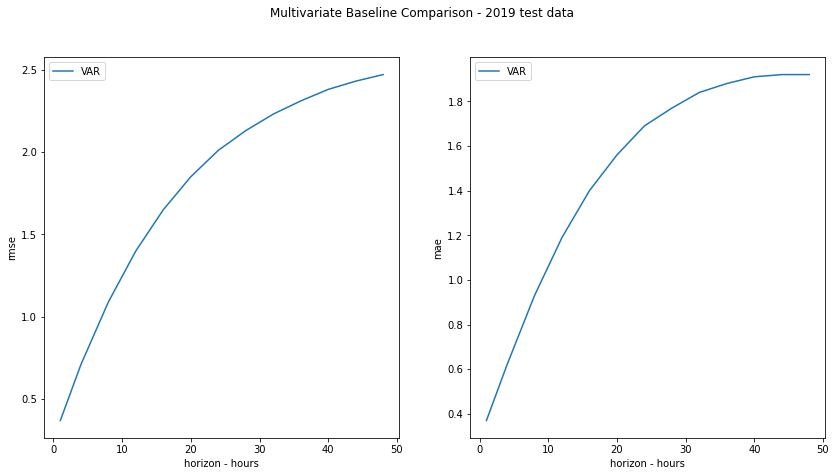

CPU times: user 10min 39s, sys: 6.63 s, total: 10min 46s
Wall time: 10min 39s


In [26]:
%%time


var_fit = var_model.fit(maxlags = 5, ic = 'aic')
print(var_fit.summary())

metric_cols = ['type', 'method', 'metric', 'horizon', 'value']
metrics = pd.DataFrame([], columns = metric_cols)

metrics = update_metrics(metrics, test_df, 'VAR', var_rolling_cv, var_fit)
plot_metrics(metrics, "Multivariate Baseline Comparison - 2019 test data")

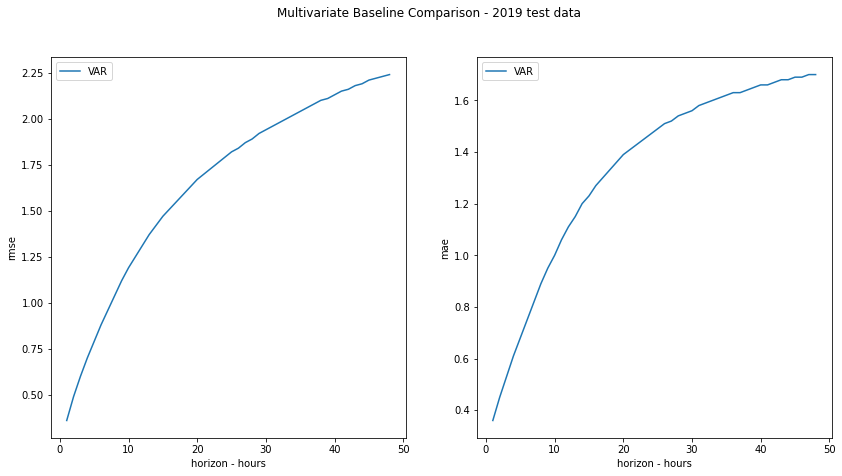

In [ ]:
plot_metrics(metrics, "Multivariate Baseline Comparison - 2019 test data")

In [ ]:
MAX_LAGS = 48
lag_order_res = var_model.select_order(MAX_LAGS)
display(lag_order_res.summary())
display(lag_order_res.selected_orders)

<class 'statsmodels.iolib.table.SimpleTable'>

{'aic': 48, 'bic': 48, 'hqic': 48, 'fpe': 48}

...

test_df['y_des']:
count    17219.000000
mean        -0.600270
std          3.084216
min        -10.071429
25%         -2.723750
50%         -0.664286
75%          1.400000
max         12.292857
Name: y_des, dtype: float64



100%|██████████| 17263/17263 [17:03<00:00, 16.86it/s]


Backtest RMSE all: 1.091552
Backtest MAE all:  0.780597

# Backtest RMSE 48th: 1.148537
# Backtest MAE 48th:  0.827723

Backtest RMSE miss==0: 1.089392
Backtest MAE miss==0:  0.779557

Backtest RMSE miss==1: 1.434299
Backtest MAE miss==1:  0.971738


backtest['y_des']:
count	 815904
mean	 -0.603618
std	 2.813045
min	 -9.695111
25%	 -2.596343
50%	 -0.660294
75%	 1.358895
max	 11.027392


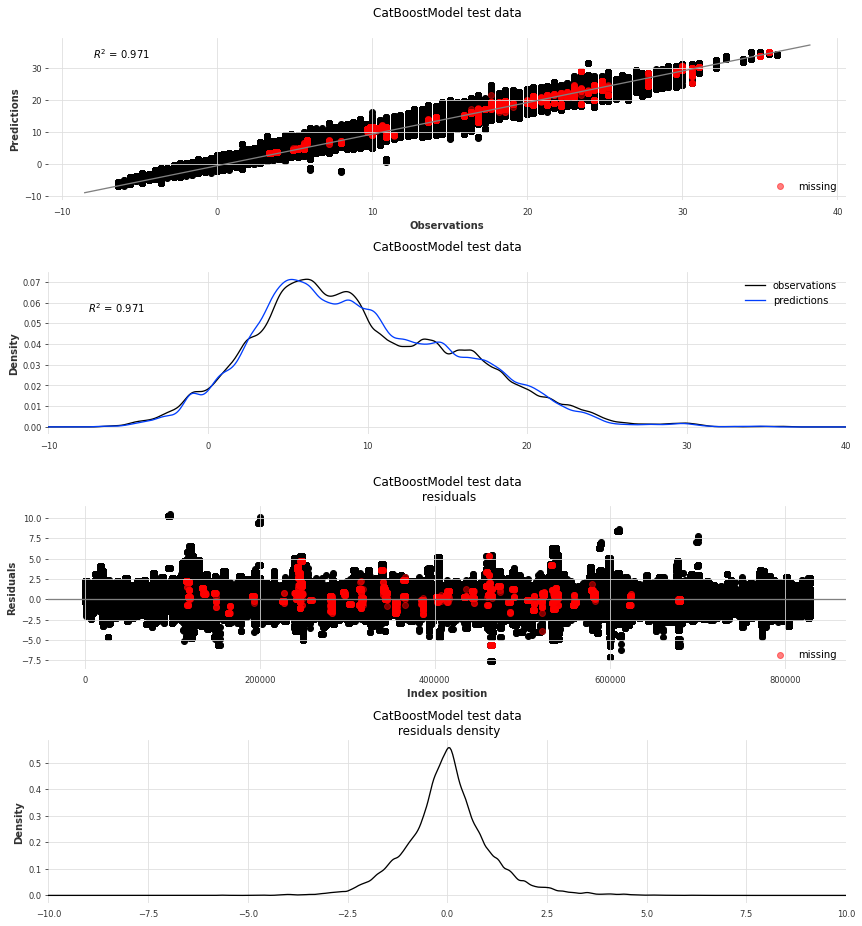

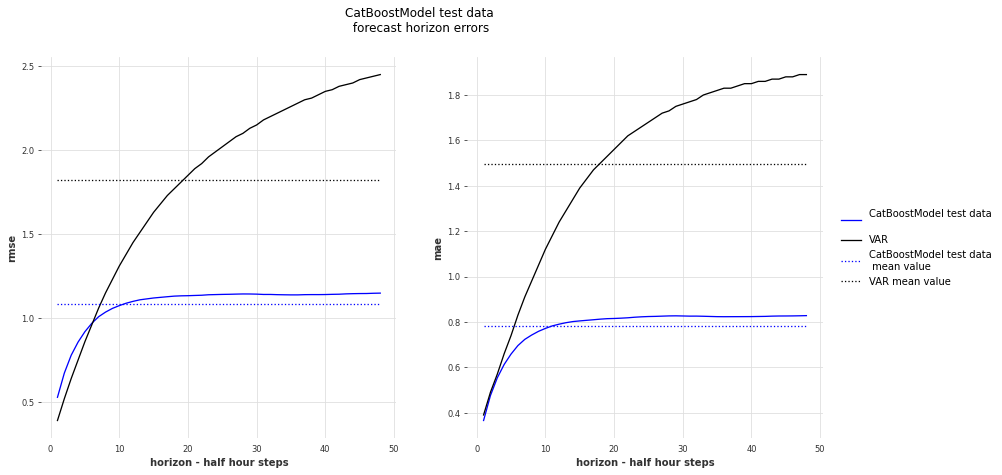

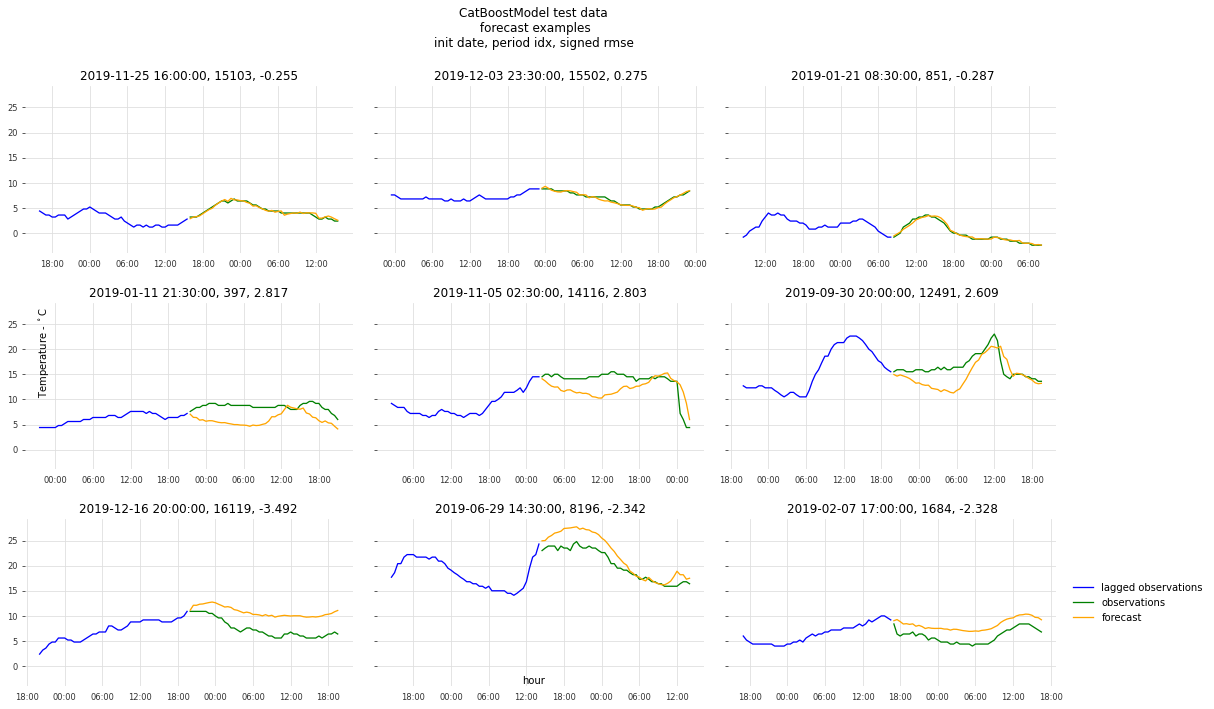

In [ ]:
test_ser = TimeSeries.from_dataframe(test_df, value_cols=Y_COL)
test_past_cov = TimeSeries.from_dataframe(test_df.loc[:, inc_cols['feature']])

print("test_df['", Y_COL, "']:\n", test_df[Y_COL].describe(), "\n", sep='')


n_est = 100
md    = 4

model7 = CatBoostModel(lags = 1,
                       lags_past_covariates = 1,
                       n_estimators = n_est,
                       max_depth    = md)

model7.fit(series, 
           past_covariates = past_cov,
           val_series = test_ser,
           val_past_covariates = test_past_cov)
backtest7 = model7.historical_forecasts(series = test_ser, 
                                       past_covariates = test_past_cov,
                                       start   = 0.01, 
                                       retrain = False,
                                       verbose = True, 
                                       forecast_horizon = HORIZON,
                                       last_points_only = False)

hist_comp7 = calculate_historic_comparison(backtest7, test_df)
summarise_hist_comp(hist_comp7, test_df)


title7 = 'CatBoostModel test data\n'
plot_obs_vs_preds(hist_comp7, title7)
plot_obs_preds_dists(hist_comp7, title7)
plot_residuals(hist_comp7, title7 + ' residuals')
plot_residuals_dist(hist_comp7, title7 + ' residuals density')
plot_horizon_metrics(hist_comp7, title7)
plot_forecast_examples(hist_comp7, title7 + ' forecast examples')

...

---

...

epochs : 20
Epoch 1/5
11759/11759 [==============================] - 13s 1ms/step - loss: 30942466.0000 - mae: 142.3176


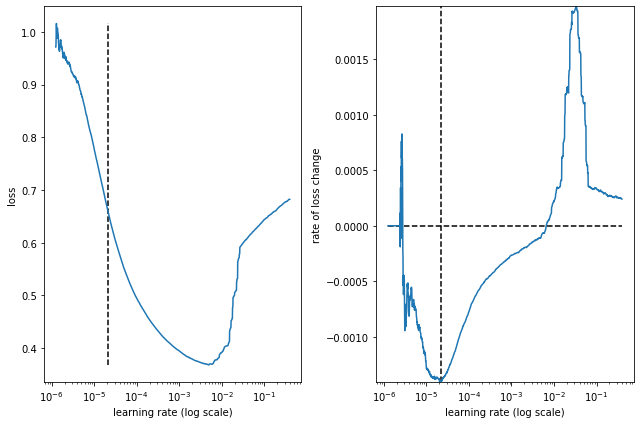

best lr: 2.1549979e-05 

Model: "conv2dk2d_28l_48s_16bs_448fm_64f_1ksf_7kst"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_4 (Reshape)         (None, 28, 10, 1)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 10, 64)        512       
                                                                 
 flatten_2 (Flatten)         (None, 17920)             0         
                                                                 
 dense_6 (Dense)             (None, 448)               8028608   
                                                                 
 dense_7 (Dense)             (None, 224)               100576    
                                                                 
 dense_8 (Dense)             (None, 48)                10800     
                                                                 

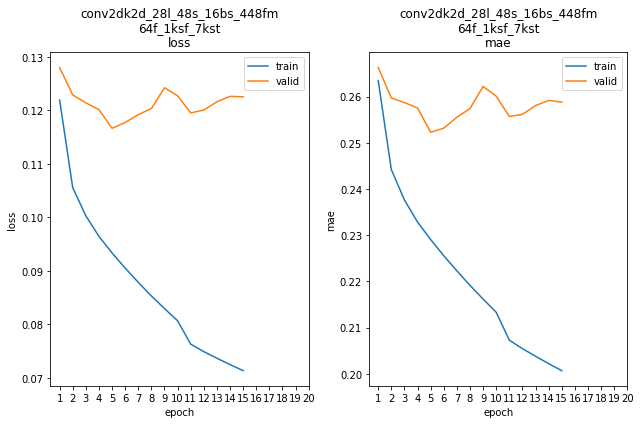

conv2dk2d_28l_48s_16bs_448fm_64f_1ksf_7kst train min loss: 0.071346	mae: 0.200707	epoch: 15
conv2dk2d_28l_48s_16bs_448fm_64f_1ksf_7kst valid min loss: 0.116655	mae: 0.252278	epoch: 5



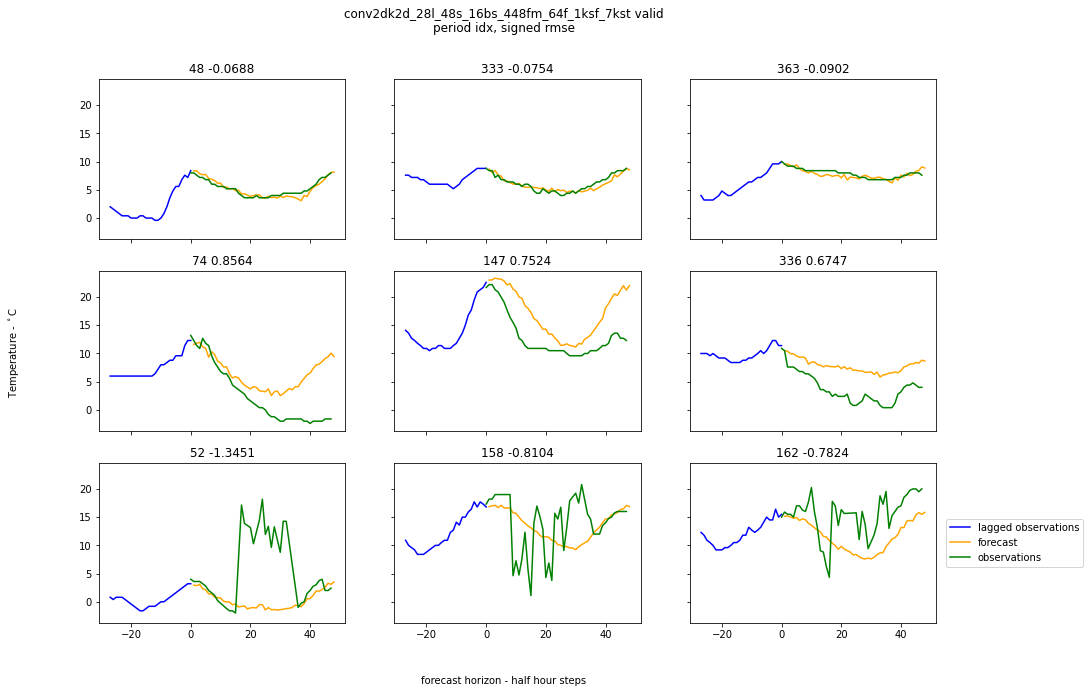

CPU times: user 20min 42s, sys: 3min 50s, total: 24min 32s
Wall time: 20min


In [ ]:
%%time


params = get_default_params('conv2dk2d')
params.update({'feat_maps':  448,
               'filters':     64,
               'lags':        28,
               'ks_feats':     1,
               'ks_time':      7,
               'lrf_params': [0.000001, 10, 32, 5, 100, 25]})
sweep_values = {'epochs': [20]}
models, epochs_model_names = sweep_param(models, params, sweep_values, verbose=True)

model_name = epochs_model_names[0]
plot_forecasts(models, model_name)

Results of the conv2dk2d_28l_48s_16bs_448fm_64f_1ksf_7kst model for 48 steps-ahead forecast after 20 epochs:

| CNN model             | params                         | mse     | mae     |
|-----------------------|--------------------------------|---------|---------|
|Conv2D Kern2D epochs= 5| lags=28, ks_feats=1, ks_time=7 | 0.11686 | 0.25261 |
|Conv2D Kern2D epochs=20| lags=28, ks_feats=1, ks_time=7 | 0.11665 | 0.25228 |

The model stopped training early after 15 epochs.  There was a marginal improvement in mse and mae.  As before, the minimal mse value was acheived at the 4th epoch.  The training plot shows some over-fitting.  Arguably, I should try the next best model but I doubt this will improve results by much.

Diagnostic plot summary:
 * once again, on validation data not test data
 * `plot_forecasts`
   * third row shows three highly suspect looking sets of observations for worst negative rmse forecast examples
   * clearly some remaining problem in the observations

---


Next, I plot the best Conv2D kernel 2D and VAR model rmse and mae values for forecast horizons up to 48 (24 hours, each horizon step is equivalent to 30 minutes).  This plot plus the two others are for forecasts on the previously unused 2019 "test" data.  This is different from the 2018 "validation" data used elsewhere in this notebook.

Some points to note regarding diagnostic plots:
 * once again, on test data not validation data
 * `plot_horizon_metrics`
   * plot rmse and mae values for each individual step-ahead
 * `check_residuals`
   * observations against predictions
   * residuals over time
   * residual distribution
 * `plot_forecasts`
   * see sub-section immediately above for notable points

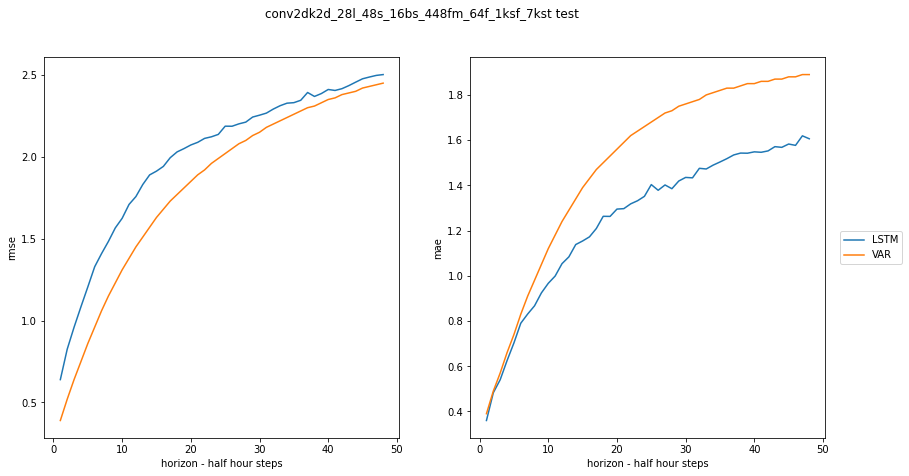

t rmse conv2dk2d_28l_48s_16bs_448fm_64f_1ksf_7kst: 2.057958616855633
t mae conv2dk2d_28l_48s_16bs_448fm_64f_1ksf_7kst:  1.179860027368246


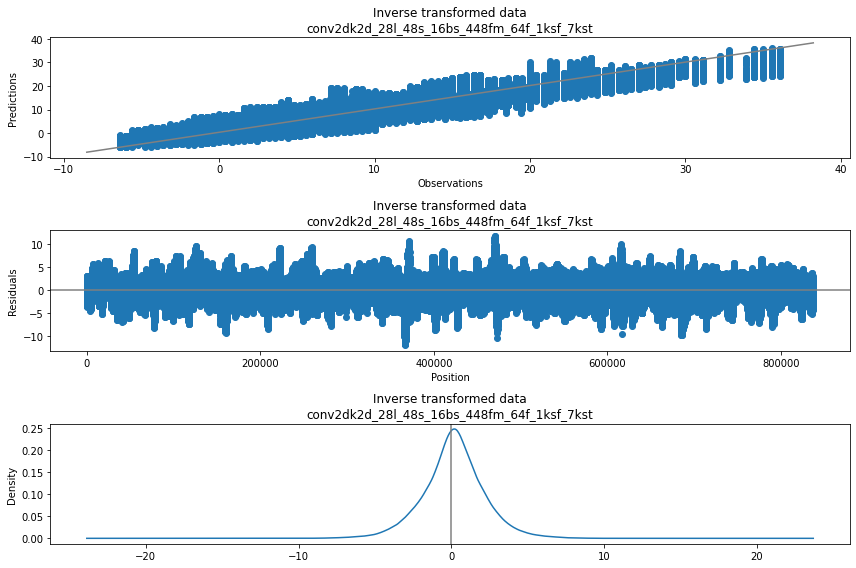

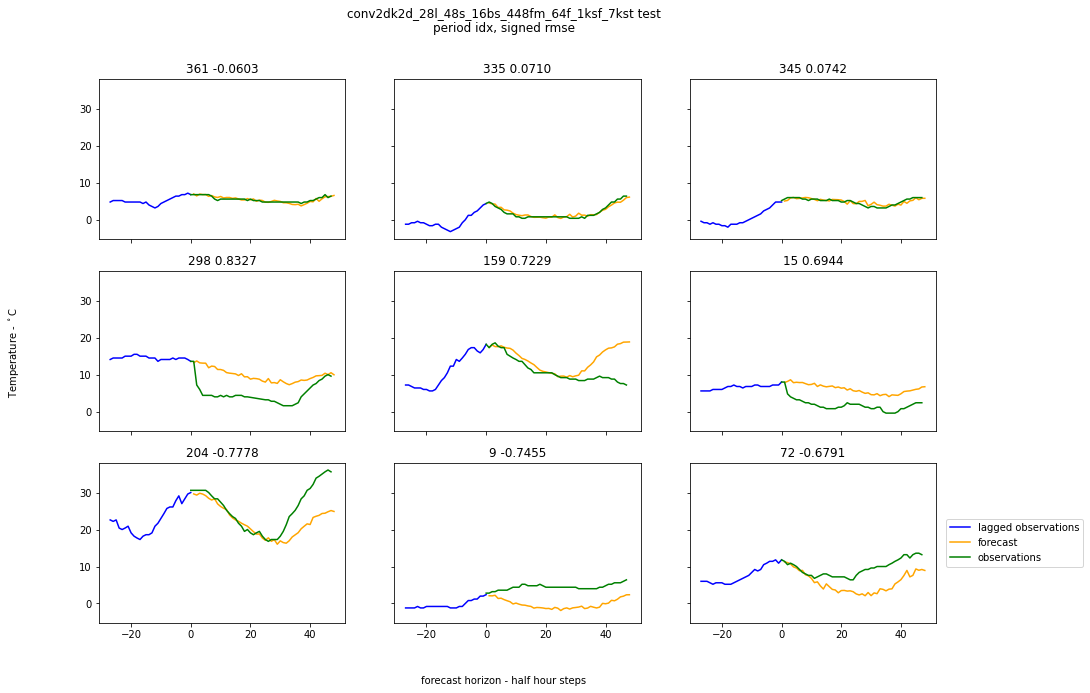

In [ ]:
ds = 'test'
best_mod = 'conv2dk2d_28l_48s_16bs_448fm_64f_1ksf_7kst'

plot_horizon_metrics(models, best_mod, dataset = ds)
check_residuals(models, best_mod, dataset = ds)
plot_forecasts(models, best_mod, dataset = ds)

Broadly speaking, these results are very similar to the results from the [best LSTM model](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/lstm_time_series.ipynb).


Diagnostic plots summary:
 * once again, these plots use test data not validation data
 * `plot_horizon_metrics`
   * initially, these results look quite contradictory
   * the rmse plot indicates better forecasts for the VAR method (in orange)
   * the mae plot indicates better forecasts for the Conv2D kernel 2D method (in blue, mis-labelled as LSTM)
 * `check_residuals`
   * the observations against predictions plot indicates
     * predictions are too high at cold temperatures (below 0 C) 
     * predictions are too low at hot temperatures (above 25 C)
   * residuals over time
     * no obvious heteroscadicity
     * no obvious periodicity
       * surprising given observations against predictions plot
   * residual distribution appears to be approximately normal (slightly right-skewed)
     * no obvious sign of fat tails
 * `plot_forecasts`
   * notable lack of noisy observations for the large positive and negative rmse examples

The median absolute error (mae) is less sensitive to outliers compared to the root mean squared error (rmse) metric.

Therefore, the rmse and mae plot difference may be due to the presence of outliers. I have maintained from the start that this data set is quite noisy, and attempts to correct these problems may have unintensionally introduced new issues.

Transformed mean values across the 48 step horizon:
 * rmse of 2.05796
 * mae of 1.17986

---


## Conclusion

The best results from the gradient boosted trees are similar/different to  results from the [best LSTM model](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/lstm_time_series.ipynb).

How and why are they similar/different?

Why are catboost models so much better than lightgbm models?

...

The conclusion is separated into the following sections:
 1. What worked
 2. What didn't work
 3. Rejected ideas
 4. Future work

The commit history for
 * [gradient_boosting.ipynb](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/commits/main/notebooks/gradient_boosting.ipynb)
 * [tsfresh_feature_engineering.ipynb](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/tsfresh_feature_engineering.ipynb)

provides details for the points summarised below.

1. What worked:
   * darts framework
   * lightgbm and catboost
     * variable importance was particularly useful
   * switching to forecasting deseasonalised temperature instead of temperature
   * adding zenith angle
      * for lightgbm and catboost models
   * adding solar irradiance
      * for lightgbm models
   * missing data annotation
     * particularly `missing` feature for plots
     * and `mi_filled` (multiple imputation filled) feature for models
        * perhaps this indicates the multiple imputation is problematic
     * `hist_average` (historic average) also appeared in a few models
        * again this may indicate problems
   * lags and past covariate lags
   * Borota-style shadow variables for feature selection
   * decomposing temperature, humidity and dew.point
      * using single additive daily mean plus residuals
   * decomposing temperature, humidity and dew.point with [UnobservedComponents](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html)
      * note that it supports additive seasonality
      * this worked well but I didn't use it
      * it was probably fast enough but almost exceeded available RAM on Colab
      * see last [relevant commit before removal](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/ddc35e3c8fcb91da49d8b24df240e3e484029ea1/notebooks/gradient_boosting.ipynb)
      * see also
         * [Detrending, Stylized Facts and the Business Cycle](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_structural_harvey_jaeger.html)
         * [Seasonality in time series data](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_seasonal.html)
   * catboost models with `y_des` and `irradiance`
      * these 2 features worked surprisingly well!


2. What didn't work:
   * [sktime](https://www.sktime.org/) framework
   * future covariates
     * with both lightgbm and catboost models
     * I checked sinusoidal and spline-based time components
     * daily and yearly temperature decomposition components
     * solar irradiance
     * some of these terms were useful in the past covariates though!
   * spline-based time components
   * higher frequency sinusoidal time components
   * phase-shifted sinusoidal time components
   * calculating mixing ratio and absolute humidity
      * both have high correlation with dew point
         * absolute humidity 0.962
         * mixing ratio 0.96
   * smoothing humidity with simple moving average
   * using darts [RegressionModel](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.regression_model.html) with lightGBM instead of [lightGBMModel](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.gradient_boosted_model.html#darts.models.forecasting.gradient_boosted_model.LightGBMModel.historical_forecasts)
      * much better results with darts builtin lightGBMModel
      * however, it would be interesting to re-run some of the sk-learn models through darts RegressionModel with optimised lags, variable selection etc
   * using darts [RandomForest](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.random_forest.html)
      * too slow
   * tsfresh features
      * some subset of these features may be useful
      * see also: Conclusion in the [tsfresh_feature_engineering.ipynb](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/tsfresh_feature_engineering.ipynb) notebook
   * temperature statistical features
      * rolling mean and standard deviations over 6, 12 and 48 step windows
   * [shap.Explainer](https://shap.readthedocs.io/en/latest/generated/shap.Explainer.html) with lightgbm model ran out of RAM and crashed after running for 2 hours
   * add confidence intervals to rmse and mae horizon plots
      * it's not immediately how to calculate CIs for rmse and mae
          * some discussion here: [Confidence interval of RMSE](https://stats.stackexchange.com/questions/78079/confidence-interval-of-rmse)
      * I am not going to consider bootstrapping CIs
   * mixup
      * darts TimeSeries requires `freq` be specified
      * won't work with irregularly time spaced mixup data augmentation
   * exact order to optimise parameters in remains unclear
      * feature selection
      * lag selection
      * hyperparameters
      * regularisation parameters _later_ on (best performing models only)
   * seasonal decomposition
     * pressure, wind.x and wind.y
        * using simple additive daily mean plus residuals
     * statsmodels MSTL
        * Season-Trend decomposition using LOESS for multiple seasonalities
        * still in development
        * documented on the [statsmodels website](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.MSTL.html) version 0.14.0 (+707)
        * but latest [release on github](https://github.com/statsmodels/statsmodels) is 0.13.5 without MSTL
        * current statsmodels version on colab is 0.12.2 again without MSTL
        * darts currently depends on and installs statsmodels version 0.13.5
        * installing statsmodels from source takes approx. 10 mins
        * the statsmodels STL and MSTL functions are currently additive only
        * too slow - stopped after 20 mins on 3 years of data :-(
           * see here for [relevant commit](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/b1ba45dd7e5d577109612d0da145d619a04593b3/notebooks/gradient_boosting.ipynb)
   * declination angle
      * [from solarpy](https://github.com/aqreed/solarpy/blob/master/examples/g_eq-of-time_declination.ipynb)
      * not useful in lightgbm or catboost models
   * lightgbm models with `y_des` and `irradiance`
      * these 2 features worked surprisingly well in catboost models!


3. Rejected ideas:
   * [El Niño–Southern Oscillation](https://en.wikipedia.org/wiki/El_Ni%C3%B1o%E2%80%93Southern_Oscillation)
      * might make sense if you live on the western coast of South America or a pacific island
      * there are many alternative [climate oscillations](https://en.wikipedia.org/wiki/Category:Climate_oscillations) and [regional climate effects](https://en.wikipedia.org/wiki/Category:Regional_climate_effects) that likely interact in non-trivial ways
      * having said that the [North Atlantic Oscillation](https://en.wikipedia.org/wiki/North_Atlantic_oscillation) affects on European temperatures may be a reasonable place to start a quick literature review
   * [calculating wind chill index](https://en.wikipedia.org/wiki/Wind_chill#North_American_and_United_Kingdom_wind_chill_index)
      * makes sense for electricity load forecasting but not for temperature forecasting
   * using [zenith delay signal](https://satellite-navigation.springeropen.com/articles/10.1186/s43020-021-00052-0) (ZTD) from the Global Navigation Satellite System ([GNSS](https://en.wikipedia.org/wiki/GNSS_applications)) signal to calculate [Precipitable Water Vapor](https://en.wikipedia.org/wiki/Precipitable_water) (PWV)
      * zenith delay signal is a measure of how much GNSS signals are affected by atmospheric refraction
      * precipitable water vapor is an important meteorological parameter for rainfall prediction
      * See: [Long-Term Rainfall Forecast Model Based on TheTabNet and LightGbm Algorithm](https://www.researchsquare.com/article/rs-107107/v1)
         * combine  pressure,  latitude,  height  of  weather  station into  ZTD feature, and combine date, height of the  station and ZTD into PWV feature


4. Future work:
   * reconsider using the rainfall observations
      * rainfall could work quite well with solar irradiance 
      * previously excluded due to noise though
   * use the temperature, dew point and relative humidity approximations to fill missing values instead of imputation, historic values etc
      * not just for the case where a single one of these variables are missing
      * hopefully will improve multiple imputation and historic averages issues
   * seasonal components
      * transform humidity before decomposition
         * relative humidity is both right and left censored
         * explore transformations
      * alternatively decompose calculated absolute humidity values
         * the raw calculated absolute humidity did not prove to be beneficial but perhaps a decomposed version would be better
      * decompose pressure, wind.x and wind.y
        * [prophet decomposition](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html) is worthwhile for lightgbm models but may not be ideal
        * [SSA](https://en.wikipedia.org/wiki/Singular_spectrum_analysis) try next
        * [DMD](https://en.wikipedia.org/wiki/Dynamic_mode_decomposition)
        [wavelets](https://en.wikipedia.org/wiki/Daubechies_wavelet), [VMD](https://github.com/vrcarva/vmdpy) etc
           * check method assumptions etc
           * check [dsatools](https://github.com/MVRonkin/dsatools) for python implementations
        * probably not [ICA](https://en.wikipedia.org/wiki/Independent_component_analysis) which has strong independence assumptions which may not apply to daily and yearly seasonality extraction
   * check denoising
      * for example [total variation denoising for signals](https://contrib.scikit-learn.org/lightning/auto_examples/plot_1d_total_variation.html)
        * note, not total variation for images
        * unlike moving averages total variation acts as an [edge-preserving filter](https://en.wikipedia.org/wiki/Edge-preserving_smoothing)
        * see also [1D-MCTV-Denoising](https://github.com/MrCredulous/1D-MCTV-Denoising)
        * many other methods to choose between
   * variable selection
      * calculate [Shapley values](https://en.wikipedia.org/wiki/Shapley_value) for each feature
      * on a subset of the training data to reduce compute time
         * hope to avoid earlier mentioned shap.Explainer problems
   * automate lag selection
   * observation selection
      * approximate the 'value' of each observation using 'data Shapley values'
      * again compute time could be a problem
      * [Data Shapley: equitable valuation of data for machine learning](http://proceedings.mlr.press/v97/ghorbani19c/ghorbani19c.pdf)
      * [Adrian Colyer's summary](https://blog.acolyer.org/2019/07/15/data-shapley/)
      * alternatively, consider exluding some of the older data
          * some of this data was gathered with older sensors now replaced
   * feature engineering
      * tsfresh 
        * explore feature selection with recursive elimination and/or recursive addition
           * or [Minimum Redundancy Maximum Relevance (mRMR)](https://en.wikipedia.org/wiki/Minimum_redundancy_feature_selection)
           * see [simple python implementation](https://towardsdatascience.com/mrmr-explained-exactly-how-you-wished-someone-explained-to-you-9cf4ed27458b)
        * try shorter and longer lagged windows - 12, 24, 96, 144
        * consider repeating without `mi_filled == 1` and `hist_average == 1`
           * or `missing == 0`
        * consider repeating on a subset of non-seasonal, non-cyclic decomposed time series
      * investigate [tsfeatures](https://github.com/Nixtla/tsfeatures)
   * use lightgbm/catboost to generate new features for use with other forecast methods
      * first introduced by facebook in [Practical Lessons from Predicting Clicks on Ads at
Facebook](http://quinonero.net/Publications/predicting-clicks-facebook.pdf)
      * effectively uses lightgbm/catboost as a feature transform
      * each element of the new feature vector corresponds to a leaf node from one of the trees in the boosting model
      * the length of the new feature vector is equal to the sum of the number of leaf nodes contained in all trees in the boosting model
      * you can use `predict(..., pred_leaf=True`), or similar option, to get the leaf_Index of each sample on each tree
      * then one-hot encode the result
      * see also: [The principle and practice of RF, GBDT and Xgboost constructing new features](https://blog.csdn.net/anshuai_aw1/article/details/82983997)
   * cross-validation
      * switch to 10-fold cross-validation
      * big increase in computation time :-(
   * data augmentation
      * explore range blending from [Forecasting with gradient boosted trees: augmentation, tuning, and cross-validation strategies: Winning solution to the M5 Uncertainty competition](https://www.sciencedirect.com/science/article/pii/S0169207021002090) with temperature, dew point and relative humidity approximation formulas
        * assume zero wind
      * randomly apply
        * randomly swap 2 observation rows
        * randomly delete observation rows
        * randomly insert observation rows
        * randomly replace observation rows with similar rows
   * add more diagnostic plots
      * residuals autocorrelation function
   * expand forecast horizon
      * 48 hours (96 steps)
   * explore alternative time series forecasting frameworks
        * [LazyProphet - Time Series Forecasting with LightGBM](https://github.com/tblume1992/LazyProphet)
           * lagged variables
           * exongenous variables
           * Fourier basis for seasonalities
           * recursive forecasting
           * weighted piecewise linear basis functions
           * [LazyProphet: Time Series Forecasting with LightGBM](https://towardsdatascience.com/lazyprophet-time-series-forecasting-with-lightgbm-3745bafe5ce5)
        * check [skforecast](https://github.com/JoaquinAmatRodrigo/skforecast) for multi-variate support
        * [GluonTS](https://ts.gluon.ai/stable/)
        * [NeuralProphet](https://github.com/ourownstory/neural_prophet)
           * combines Neural Network and traditional time-series algorithms, inspired by Facebook Prophet
           * supports multiple seasonalities, lagged regressors & future regressors
           * still in beta :-(
           * working on
              * cross-relation of lagged regressors!
              * cross-relation and non-linear modelling of future regressors!
              * multimodal seasonality??
        * the [Nixtla](https://github.com/Nixtla) group have several interesting packages
           * [statsforecast](https://github.com/Nixtla/statsforecast)
           * [mlforecast](https://github.com/Nixtla/mlforecast)
           * [neuralforecast](https://github.com/Nixtla/neuralforecast)
              * [NBEATSx](https://github.com/Nixtla/neuralforecast/blob/main/nbs/models.nbeatsx.ipynb) relatively good performance and supports exogenous variables
              * [NHITSx](https://github.com/Nixtla/neuralforecast/blob/main/nbs/models.nhits.ipynb) relatively good performance and supports exogenous variables
        * it's probably safe to [ignore AWS forecast for a while](https://github.com/Nixtla/statsforecast/tree/main/experiments/amazon_forecast) lol :-)



---

## Metadata

Python and Jupyter versions plus modules imported and their version strings. 
This is the poor man's python equivalent of R's sessionInfo().

Code for imported modules and versions adapted from this stackoverflow answer. 
There are simpler alternatives, such as watermark, but they all require installation.

In [ ]:
import sys
import IPython

print("Python version:")
print(sys.executable)
print(sys.version)
print("\nIPython version:")
print(IPython.__version__)

Python version:
/usr/bin/python3
3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]

IPython version:
5.5.0


In [ ]:
import pkg_resources
import types

def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names.  Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name.  You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL":       "Pillow",
            "sklearn":   "scikit-learn",
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name

imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != "pip":
        requirements.append((m.project_name, m.version))

reqs = pd.DataFrame(requirements, columns = ['name', 'version'])
print("Imported modules:")
reqs.style.hide_index()

Imported modules:


In [ ]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               85
Model name:          Intel(R) Xeon(R) CPU @ 2.00GHz
Stepping:            3
CPU MHz:             2000.178
BogoMIPS:            4000.35
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            1024K
L3 cache:            39424K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_si

In [ ]:
!date

Sat Jun 18 14:10:54 UTC 2022


---


## Archival

Archive code, markdown, history and formatted notebooks.

Assumes all pdf, html, latex etc dependencies are installed.

**WARNING** Will overwrite existing files.

Notebook name is hardcoded below because the alternative is ghastly globs of unreliable javascript or external ipython libraries I'd prefer to avoid installing :-(

In [ ]:
from time import sleep

notebook = "gradient_boosting.ipynb"
# !jupyter nbconvert --to script {notebook}
# !jupyter nbconvert --execute --to html {notebook}
# !jupyter nbconvert --execute --to pdf {notebook}
# !jupyter nbconvert --to pdf {notebook}

%rm history.txt
%history -f history.txt

!jupyter nbconvert --to python {notebook}
sleep(5)
!jupyter nbconvert --to markdown {notebook}
sleep(5)
!jupyter nbconvert --to html {notebook}